# Evaluation of stopping methods for safe use of priority screening in systematic reviews
This notebook contains all evaluations of the simulations used in the article 
> 2025 in Cochrane Evidence Synthesis and Methods.    
> *Tim Repke, Francesca Tinsdeall, Lena Schmidt, Diana Danilenko, Sergio Graziosi, Finn Müller-Hansen, James Thomas, Gert van Valkenhoef.*    
> Don’t stop me now, ’cause I’m having a good me screening: Evaluation of stopping methods for safe use of priority screening in systemaic maps and reviews. 

In [1]:
import logging
import re
from typing import Literal, Annotated

import numpy as np
import numpy.typing as npt
import pandas as pd
from matplotlib import pyplot as plt
import matplotlib.gridspec as gridspec
from pathlib import Path
from tqdm import tqdm
from scipy.stats import gaussian_kde
from sklearn.neighbors import KernelDensity
import seaborn as sns
from tqdm.notebook import tqdm
from IPython.display import display, Markdown

logging.basicConfig(format='%(asctime)s [%(levelname)s] %(name)s: %(message)s', level=logging.DEBUG)
logger = logging.getLogger('base')
logging.getLogger('matplotlib').setLevel(logging.WARNING)
logger.setLevel(logging.DEBUG)

pd.options.display.max_columns = 650
pd.options.display.max_rows = 20

# Load data

In [159]:
df['sim_key'].nunique()

223

In [2]:
files = list(Path('../data/results/').glob('simulation-*.csv'))
lst = []
for fp in files:
    print(fp, end='  ->  ')
    lst.append(pd.read_csv(fp))
    print(lst[-1].shape)
    
df = pd.concat(lst)
# temporary fix after renaming alison
df.loc[df['method']=='ALISON', 'method'] = 'CURVE_FITTING'

print()
print(f'Size of dataframe: {df.shape}')
print(f'Number of unique dataset keys: {len(df['dataset'].unique()):,}')
print(f'Number of simulations: {len(df.groupby(['sim_key', 'method-hash', 'sim-rep'])):,}')
print()
print(list(df.columns))

df.head()

../data/results/simulation-BUSCAR.csv  ->  (169280, 20)
../data/results/simulation-HEURISTIC_SCORES.csv  ->  (855040, 21)
../data/results/simulation-BATCHPRECISION.csv  ->  (480960, 22)
../data/results/simulation-KNEE.csv  ->  (1923840, 25)
../data/results/simulation-HEURISTIC_FIX.csv  ->  (213760, 20)
../data/results/simulation-HEURISTIC_FRAC.csv  ->  (267200, 21)
../data/results/simulation-S-CAL.csv  ->  (3557664, 22)
../data/results/simulation-IPP.csv  ->  (4275200, 21)
../data/results/simulation-APRIORI.csv  ->  (855040, 21)
../data/results/simulation-ALISON.csv  ->  (196496, 22)
../data/results/simulation-QUANT_CI.csv  ->  (641280, 22)
../data/results/simulation-METHOD2399.csv  ->  (160320, 22)
../data/results/simulation-SALτ.csv  ->  (335520, 25)
../data/results/simulation-HEURISTIC_RANDOM.csv  ->  (213760, 20)
../data/results/simulation-TM_QBCB.csv  ->  (3364960, 23)
../data/results/simulation-CURVE_FITTING.csv  ->  (2778960, 22)

Size of dataframe: (20289280, 51)
Number of uniq

dataset  sim-rep                     sim_key  batch_i  n_total  \
0  clef-CD005139        2  clef-CD005139-0-500-2-best        0     4564   
1  clef-CD005139        2  clef-CD005139-0-500-2-best        0     4564   
2  clef-CD005139        2  clef-CD005139-0-500-2-best        0     4564   
3  clef-CD005139        2  clef-CD005139-0-500-2-best        0     4564   
4  clef-CD005139        2  clef-CD005139-0-500-2-best        0     4564   

   n_seen  n_unseen  n_incl  n_incl_seen  n_incl_batch  n_records_batch  \
0      15      4549     105            0             0               15   
1      15      4549     105            0             0               15   
2      15      4549     105            0             0               15   
3      15      4549     105            0             0               15   
4      15      4549     105            0             0               15   

   method  safe_to_stop                                      method-hash  \
0  BUSCAR         False  BUSCAR-e6b188ab2401441c954b3acc265a9a392a27e610   
1  BUSCAR         False  BUSCAR-069a5aad55753c1c3bcec5ba79e6257df8816cc6   
2  BUSCAR         False  BUSCAR-9f1bda158f94fd8e02a9970953e418bf71ff3bfa   
3  BUSCAR         False  BUSCAR-22a925f404f24ca4bd63307b840218706d8a9850   
4  BUSCAR         False  BUSCAR-0dac10e070eda34f6805d5a285e84280dd9f5163   

  method-KEY  method-safe_to_stop  method-score  method-confidence_level  \
0     BUSCAR                False      0.996713                      0.8   
1     BUSCAR                False      0.993438                      0.8   
2     BUSCAR                False      0.983682                      0.8   
3     BUSCAR                False      0.967647                      0.8   
4     BUSCAR                False      0.996713                      0.9   

   method-recall_target  method-bias  method-est_incl  \
0                   0.8          1.0              NaN   
1                   0.8          2.0              NaN   
2                   0.8          5.0              NaN   
3                   0.8         10.0              NaN   
4                   0.8          1.0              NaN   

   method-inclusion_threshold  method-batch_size  method-threshold  \
0                         NaN                NaN               NaN   
1                         NaN                NaN               NaN   
2                         NaN                NaN               NaN   
3                         NaN                NaN               NaN   
4                         NaN                NaN               NaN   

   method-current_precision  method-window_size  method-polyorder  \
0                       NaN                 NaN               NaN   
1                       NaN                 NaN               NaN   
2                       NaN                 NaN               NaN   
3                       NaN                 NaN               NaN   
4                       NaN                 NaN               NaN   

   method-threshold_ratio  method-threshold_peak  method-slope_ratio  \
0                     NaN                    NaN                 NaN   
1                     NaN                    NaN                 NaN   
2                     NaN                    NaN                 NaN   
3                     NaN                    NaN                 NaN   
4                     NaN                    NaN                 NaN   

  method-smoothing  method-num_to_stop  method-fraction  method-sample_size  \
0              NaN                 NaN              NaN                 NaN   
1              NaN                 NaN              NaN                 NaN   
2              NaN                 NaN              NaN                 NaN   
3              NaN                 NaN              NaN                 NaN   
4              NaN                 NaN              NaN                 NaN   

   method-n_windows  method-est_recall  method-expected_includes  \
0               NaN                NaN

In [3]:
# BUSCAR is not published yet and clearly doesn't work with an exogeneous bias parameter. 
# Hence, dropping all buscar experiments and only keep bias=1, which is equivalent to CMH
df = df[df['method-bias'].isna() | (df['method-bias']==1)]

# Also, rename the method accordingly
df.loc[df['method']=='BUSCAR', 'method'] = 'CMH'

In [4]:
cached_df_res = Path('../data/df_res.csv')
RECALL_TARGETS = [0.8, 0.85, 0.9, 0.95, 0.99, 1.0]

if cached_df_res.exists():
    df_res = pd.read_csv(cached_df_res)
else:
    results = []
    
    for (hash_ranker, hash_method, repeat), sub_df in tqdm(df.groupby(['sim_key', 'method-hash', 'sim-rep'])):
        simulation = sub_df.sort_values(by=['batch_i'])
        simulation = simulation.where(simulation['dataset'].notna())
        rel_curve = simulation['n_incl_seen'] / simulation['n_incl']
        
        #info = simulation.iloc[0]
        #logger.info(f'Dataset "{info['dataset']}" stopped by "{info['method']}" (repeat {repeat} via {hash_method} / {hash_ranker})')
        stop_rows = simulation[simulation['safe_to_stop']]
        stop_row = (stop_rows.iloc[0] if  len(stop_rows) > 0 else simulation.iloc[-1]).to_dict()
    
        for t in RECALL_TARGETS:
            step = np.argwhere(rel_curve >= t).min()
            stop_row[f'seen@recall={t}'] = simulation.iloc[step]['n_seen']
            stop_row[f'unseen@recall={t}'] = simulation.iloc[step]['n_unseen']
            stop_row[f'seen_incl@recall={t}'] = simulation.iloc[step]['n_incl_seen']
            
            stop_row[f'too_late@recall={t}'] = max(0, stop_row['n_seen'] - simulation.iloc[step]['n_seen'])
            stop_row[f'too_late_left%@recall={t}'] = max(0, stop_row['n_seen'] - simulation.iloc[step]['n_seen']) / (simulation.iloc[step]['n_seen'])
            stop_row[f'too_late_right%@recall={t}'] = max(0, stop_row['n_seen'] - simulation.iloc[step]['n_seen']) / (stop_row['n_total'] - simulation.iloc[step]['n_seen'])
            
            stop_row[f'too_early@recall={t}'] = max(0, simulation.iloc[step]['n_seen'] - stop_row['n_seen'])
            stop_row[f'too_early%@recall={t}'] = -max(0, simulation.iloc[step]['n_seen'] - stop_row['n_seen']) / (simulation.iloc[step]['n_seen'])
    
            stop_row[f'missed@recall={t}'] =  max(0, simulation.iloc[step]['n_incl_seen'] - stop_row['n_incl_seen'])
            stop_row[f'missed%@recall={t}'] =  -max(0, simulation.iloc[step]['n_incl_seen'] - stop_row['n_incl_seen']) / stop_row['n_incl']
    
        results.append(stop_row)
    
    df_res = pd.DataFrame(results)
    df_res['stop_recall'] = df_res['n_incl_seen'] / df_res['n_incl']
    df_res['work_saved'] = df_res['n_unseen'] / df_res['n_total']
    df_res['incl_missed'] = (df_res['n_incl'] - df_res['n_incl_seen']) / df_res['n_incl']
    df_res['target_recall_reached'] = df_res['stop_recall'] >= df_res['method-recall_target']
    df_res['incl_rate'] = df_res['n_incl'] / df_res['n_total']
    
    df_res[df_res['method-recall_target'].notna()].groupby('method')['target_recall_reached'].value_counts(normalize=True).unstack()
    
    for t in RECALL_TARGETS:
        df_res[f'tetl_left@recall={t}'] = df_res[[f'too_early%@recall={t}', f'too_late_left%@recall={t}']].replace({0: np.nan}).bfill(axis=1).iloc[:, 0].fillna(0) * 100
        df_res[f'tetl_right@recall={t}'] = df_res[[f'too_early%@recall={t}', f'too_late_right%@recall={t}']].replace({0: np.nan}).bfill(axis=1).iloc[:, 0].fillna(0) * 100
        df_res[f'mtl_right@recall={t}'] = df_res[[f'missed%@recall={t}', f'too_late_right%@recall={t}']].replace({0: np.nan}).bfill(axis=1).iloc[:, 0].fillna(0) * 100
        df_res[f'mtl_left@recall={t}'] = df_res[[f'missed%@recall={t}', f'too_late_left%@recall={t}']].replace({0: np.nan}).bfill(axis=1).iloc[:, 0].fillna(0) * 100
        df_res[f'missed_%@recall={t}'] = df_res[f'missed%@recall={t}'] * -100
        df_res.loc[df_res['method-recall_target'] == t, 'additional_work'] = (df_res['n_seen'] - df_res[f'seen@recall={t}']) / df_res['n_total'] * 100
        
        df_res.loc[df_res['method-recall_target']==t, 'tetl_right'] = df_res[df_res['method-recall_target']==t][f'tetl_right@recall={t}']
        df_res.loc[df_res['method-recall_target']==t, 'tetl_left'] = df_res[df_res['method-recall_target']==t][f'tetl_left@recall={t}']
        df_res.loc[df_res['method-recall_target']==t, 'mtl_left'] = df_res[df_res['method-recall_target']==t][f'mtl_left@recall={t}']
        df_res.loc[df_res['method-recall_target']==t, 'mtl_right'] = df_res[df_res['method-recall_target']==t][f'mtl_right@recall={t}']
        df_res.loc[df_res['method-recall_target']==t, 'missed_%'] = df_res[df_res['method-recall_target']==t][f'missed_%@recall={t}']

    df_res.to_csv(cached_df_res, index=False)

/tmp/ipykernel_2276537/2542229014.py:4: DtypeWarning: Columns (44,45) have mixed types. Specify dtype option on import or set low_memory=False.
  df_res = pd.read_csv(cached_df_res)


In [5]:
print(df_res.shape)
print()
print(list(df_res.columns))
df_res.head()

(71291, 152)

['dataset', 'sim-rep', 'sim_key', 'batch_i', 'n_total', 'n_seen', 'n_unseen', 'n_incl', 'n_incl_seen', 'n_incl_batch', 'n_records_batch', 'method', 'safe_to_stop', 'method-hash', 'method-KEY', 'method-safe_to_stop', 'method-score', 'method-confidence_level', 'method-recall_target', 'method-bias', 'method-est_incl', 'method-inclusion_threshold', 'method-batch_size', 'method-threshold', 'method-current_precision', 'method-window_size', 'method-polyorder', 'method-threshold_ratio', 'method-threshold_peak', 'method-slope_ratio', 'method-smoothing', 'method-num_to_stop', 'method-fraction', 'method-sample_size', 'method-n_windows', 'method-est_recall', 'method-expected_includes', 'method-curve_estimate', 'method-nstd', 'method-est_var', 'method-alpha', 'method-constant', 'method-num_reviewed', 'method-num_relevant_reviewed', 'method-use_adjusted', 'method-use_margin', 'method-margin_recall', 'method-positive_sample_size', 'method-required_overlap', 'method-n_overlap', 'method-n

dataset  sim-rep                     sim_key  batch_i  n_total  \
0  clef-CD005139        1  clef-CD005139-0-500-1-best      304     4564   
1  clef-CD005139        1  clef-CD005139-0-500-1-best      230     4564   
2  clef-CD005139        1  clef-CD005139-0-500-1-best      304     4564   
3  clef-CD005139        1  clef-CD005139-0-500-1-best      304     4564   
4  clef-CD005139        1  clef-CD005139-0-500-1-best      235     4564   

   n_seen  n_unseen  n_incl  n_incl_seen  n_incl_batch  n_records_batch  \
0    4564         0     105          105             0               15   
1    3465      1099     105          105             1               15   
2    4564         0     105          105             0               15   
3    4564         0     105          105             0               15   
4    3540      1024     105          105             0               15   

          method  safe_to_stop  \
0  CURVE_FITTING         False   
1  CURVE_FITTING          True   
2  CURVE_FITTING         False   
3  CURVE_FITTING         False   
4  CURVE_FITTING          True   

                                       method-hash method-KEY  \
0  ALISON-417e55e2a26d7f24cad8370396678f36024acb8f     ALISON   
1  ALISON-502d519a5da2e428cb4ae83cc327d8199a4e6e28     ALISON   
2  ALISON-5f542022639c694d0c669ba3875bcea7f3fb8b3e     ALISON   
3  ALISON-6bfe1978bea8ac323c29190eb7a2762af868a3c4     ALISON   
4  ALISON-76f418714968ee3912325c36d41c893415c34486     ALISON   

   method-safe_to_stop  method-score  method-confidence_level  \
0                False           NaN                     0.80   
1                 True           NaN                     0.80   
2                False           NaN                     0.95   
3                False           NaN                     0.80   
4                 True           NaN                     0.80   

   method-recall_target  method-bias  method-est_incl  \
0                  0.99          NaN              NaN   
1                  0.80          NaN              NaN   
2                  0.99          NaN              NaN   
3                  0.90          NaN              NaN   
4                  0.80          NaN              NaN   

   method-inclusion_threshold  method-batch_size  method-threshold  \
0                         NaN                NaN               NaN   
1                         NaN                NaN               NaN   
2                         NaN                NaN               NaN   
3                         NaN                NaN               NaN   
4                         NaN                NaN               NaN   

   method-current_precision  method-window_size  method-polyorder  \
0                       NaN                 NaN               NaN   
1                       NaN                 NaN               NaN   
2                       NaN                 NaN               NaN   
3                       NaN                 NaN               NaN   
4                       NaN                 NaN               NaN   

   method-threshold_ratio  method-threshold_peak  method-slope_ratio  \
0                     NaN                    NaN                 NaN   
1                     NaN                    NaN                 NaN   
2                     NaN                    NaN                 NaN   
3                     NaN                    NaN                 NaN   
4                     NaN                    NaN                 NaN   

  method-smoothing  method-num_to_stop  method-fraction  method-sample_size  \
0              NaN                 NaN              NaN                 NaN   
1              NaN                 NaN              NaN                 NaN   
2              NaN                 NaN              NaN                 NaN   
3              NaN                 NaN              NaN                 NaN   
4              NaN                 NaN              NaN                 NaN   

   method-n_windows  method-est_r

# Dataset statistics
Some basic plots and tables to get a sense of dataset characteristics

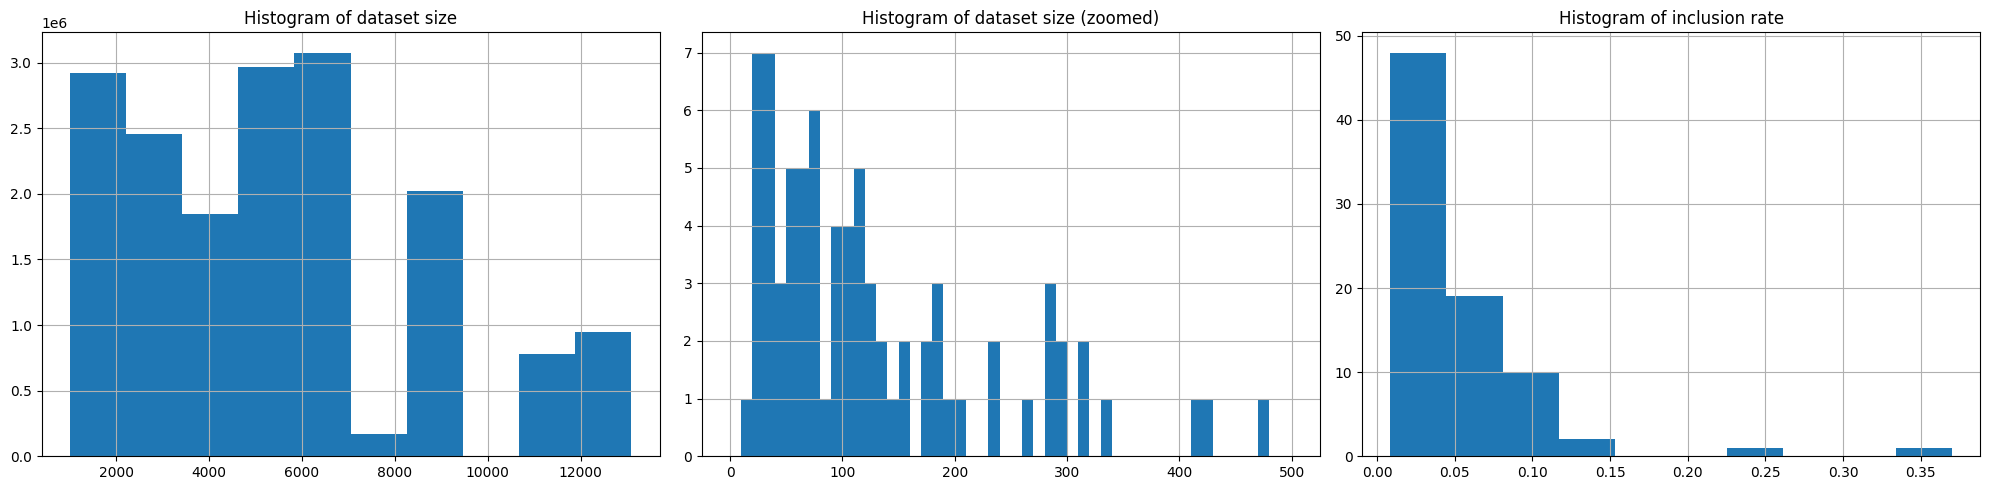

In [6]:
fig, axes = plt.subplots(1, 3, figsize=(20, 5))
ds_info = df.groupby('dataset').first()

axes[0].set_title('Histogram of dataset size')
df['n_total'].hist(ax=axes[0])

axes[1].set_title('Histogram of dataset size (zoomed)')
ds_info['n_incl'].hist(range=(0, 500), bins=50, ax=axes[1])

axes[2].set_title('Histogram of inclusion rate')
(ds_info['n_incl'] / ds_info['n_total']).hist(ax=axes[2])

fig.tight_layout()

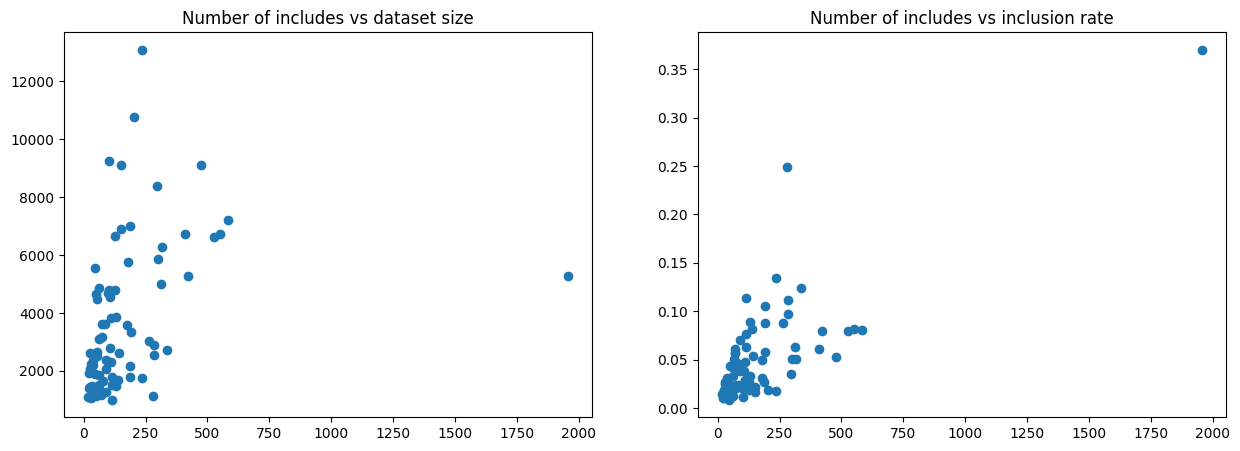

In [9]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

axes[0].set_title('Number of includes vs dataset size')
axes[0].scatter(ds_info['n_incl'], ds_info['n_total'])

axes[1].set_title('Number of includes vs inclusion rate')
axes[1].scatter(ds_info['n_incl'], ds_info['n_incl'] / ds_info['n_total'])

In [10]:
df_ds = df[['dataset', 'n_total', 'n_incl', 'n_incl_seen']].groupby('dataset').first().reset_index()
df_ds['incl_rate'] = df_ds['n_incl'] / df_ds['n_total']
df_ds.describe()

n_total       n_incl  n_incl_seen  incl_rate
count     81.000000    81.000000    81.000000  81.000000
mean    3601.148148   166.864198     0.740741   0.049976
std     2571.213367   240.074351     0.958877   0.052203
min     1000.000000    16.000000     0.000000   0.008462
25%     1665.000000    53.000000     0.000000   0.019760
50%     2627.000000   104.000000     0.000000   0.033308
75%     4862.000000   189.000000     1.000000   0.060925
max    13095.000000  1957.000000     4.000000   0.370083

In [11]:
df_ds = df[['dataset', 'n_total', 'n_incl', 'n_incl_seen']].groupby('dataset').max().reset_index()
df_ds['incl_rate'] = df_ds['n_incl'] / df_ds['n_total']
df_ds.describe()

n_total       n_incl  n_incl_seen  incl_rate
count     81.000000    81.000000    81.000000  81.000000
mean    3602.222222   167.086420   167.086420   0.050057
std     2570.583859   240.010635   240.010635   0.052197
min     1000.000000    16.000000    16.000000   0.008462
25%     1665.000000    53.000000    53.000000   0.019760
50%     2627.000000   105.000000   105.000000   0.033308
75%     4862.000000   189.000000   189.000000   0.060925
max    13095.000000  1957.000000  1957.000000   0.370083

## Dataset overview table for appendix

In [12]:
n_folds = 2
n_rpf = len(df_ds) // n_folds # rows per fold

df_ds = df[['dataset', 'n_total', 'n_incl', 'n_incl_seen']].groupby('dataset').max().reset_index()
df_ds['incl_rate'] = df_ds['n_incl'] / df_ds['n_total'] * 100
df_ds['ds_rename'] = [n.replace('generic-csv-', 'SYNERGY: ').replace('generic-paired-ris-', 'EPPI: ').replace('clef-', 'CLEF: ') for n in df_ds['dataset']]
df_ds = df_ds[['ds_rename', 'n_total', 'n_incl', 'incl_rate']].rename(columns={'ds_rename': 'Dataset', 'n_total': 'Records (total)', 'n_incl': 'Records (relevant)', 'incl_rate': 'Records (% relevant)' })#.drop(columns=['n_incl_seen', 'dataset'])

dfds = pd.concat([df_ds.iloc[n_rpf*f:n_rpf*(f+1)].reset_index(drop=True) for f in range(n_folds)], axis=1)
print(dfds.to_latex(index=False, escape=True, sparsify=True, float_format='{:0.1f}'.format))
dfds

\begin{tabular}{lrrrlrrr}
\toprule
Dataset & Records (total) & Records (relevant) & Records (\% relevant) & Dataset & Records (total) & Records (relevant) & Records (\% relevant) \\
\midrule
CLEF: CD005139 & 4564 & 105 & 2.3 & CLEF: CD012179 & 8376 & 297 & 3.5 \\
CLEF: CD007394 & 2375 & 90 & 3.8 & CLEF: CD012347 & 1093 & 16 & 1.5 \\
CLEF: CD007427 & 1497 & 115 & 7.7 & CLEF: CD012599 & 6617 & 527 & 8.0 \\
CLEF: CD007431 & 1921 & 20 & 1.0 & CLEF: CD012661 & 3344 & 192 & 5.7 \\
CLEF: CD008054 & 3023 & 265 & 8.8 & CLEF: CD012669 & 1155 & 70 & 6.1 \\
CLEF: CD008122 & 1762 & 237 & 13.5 & SYNERGY: Leenaars\_2020 & 7216 & 583 & 8.1 \\
CLEF: CD008691 & 1254 & 71 & 5.7 & SYNERGY: Muthu\_2021 & 2719 & 336 & 12.4 \\
CLEF: CD008803 & 4692 & 99 & 2.1 & SYNERGY: Smid\_2020 & 2627 & 27 & 1.0 \\
CLEF: CD008874 & 1798 & 114 & 6.3 & SYNERGY: van\_der\_Waal\_2022 & 1970 & 33 & 1.7 \\
CLEF: CD008892 & 1276 & 64 & 5.0 & EPPI: Heart 0503 & 5554 & 47 & 0.8 \\
CLEF: CD009020 & 1468 & 130 & 8.9 & EPPI: Heart 08

Dataset  Records (total)  Records (relevant)  Records (% relevant)  \
0   CLEF: CD005139             4564                 105              2.300613   
1   CLEF: CD007394             2375                  90              3.789474   
2   CLEF: CD007427             1497                 115              7.682031   
3   CLEF: CD007431             1921                  20              1.041124   
4   CLEF: CD008054             3023                 265              8.766126   
..             ...              ...                 ...                   ...   
35  CLEF: CD011787             3842                 110              2.863092   
36  CLEF: CD011975             6743                 552              8.186267   
37  CLEF: CD011984             6746                 411              6.092499   
38  CLEF: CD012010             5758                 178              3.091351   
39  CLEF: CD012069             2903                 283              9.748536   

                          Dataset  Records (total)  Records (relevant)  \
0                  CLEF: CD012179             8376                 297   
1                  CLEF: CD012347             1093                  16   
2                  CLEF: CD012599             6617                 527   
3                  CLEF: CD012661             3344                 192   
4                  CLEF: CD012669             1155                  70   
..                            ...              ...                 ...   
35  EPPI: projectChildInvolvement             4997                 313   
36         EPPI: projectCovidBarn             2799                 108   
37              EPPI: review-1253             6676                 126   
38              EPPI: review-1453             3629                  75   
39  EPPI: shareddecisionmaking1.1             6897                 151   

    Records (% relevant)  
0               3.545845  
1               1.463861  
2               7.964334  
3               5.741627  
4               6.060606  
..                   ...  
35              6.263758  
36              3.858521  
37              1.887358  
38              2.066685  
39              2.189358  

[40 rows x 8 columns]

# Stopping method statistics (high-level)

In [13]:
for (hash_ranker, hash_method, repeat), sub_df in df.groupby(['sim_key', 'method-hash', 'sim-rep']):
    simulation = sub_df.sort_values(by=['batch_i'])
    info = simulation.iloc[0]
    logger.info(f'Dataset "{info['dataset']}" stopped by "{info['method']}" (repeat {repeat} via {hash_method} / {hash_ranker})')
    for _, step in simulation.iterrows():
        recall = step['n_incl_seen'] / step['n_incl']

        logger.info(f'Batch {step['batch_i']}: {step['n_seen']:,}/{step['n_total']:,} seen; '
              f'{step['n_incl_seen']:,}/{step['n_incl']:,} includes found; '
              f'recall={recall:.2%} | safe to stop: {step['safe_to_stop']}')

    logger.info('---')
    break

2025-10-23 14:36:56,507 [INFO] base: Dataset "clef-CD005139" stopped by "CURVE_FITTING" (repeat 1 via ALISON-417e55e2a26d7f24cad8370396678f36024acb8f / clef-CD005139-0-500-1-best)
2025-10-23 14:36:56,508 [INFO] base: Batch 0: 15/4,564 seen; 0/105 includes found; recall=0.00% | safe to stop: False
2025-10-23 14:36:56,508 [INFO] base: Batch 1: 30/4,564 seen; 0/105 includes found; recall=0.00% | safe to stop: False
2025-10-23 14:36:56,509 [INFO] base: Batch 2: 45/4,564 seen; 0/105 includes found; recall=0.00% | safe to stop: False
2025-10-23 14:36:56,509 [INFO] base: Batch 3: 60/4,564 seen; 0/105 includes found; recall=0.00% | safe to stop: False
2025-10-23 14:36:56,509 [INFO] base: Batch 4: 75/4,564 seen; 0/105 includes found; recall=0.00% | safe to stop: False
2025-10-23 14:36:56,509 [INFO] base: Batch 5: 90/4,564 seen; 0/105 includes found; recall=0.00% | safe to stop: False
2025-10-23 14:36:56,510 [INFO] base: Batch 6: 105/4,564 seen; 1/105 includes found; recall=0.95% | safe to stop:

<Axes: >

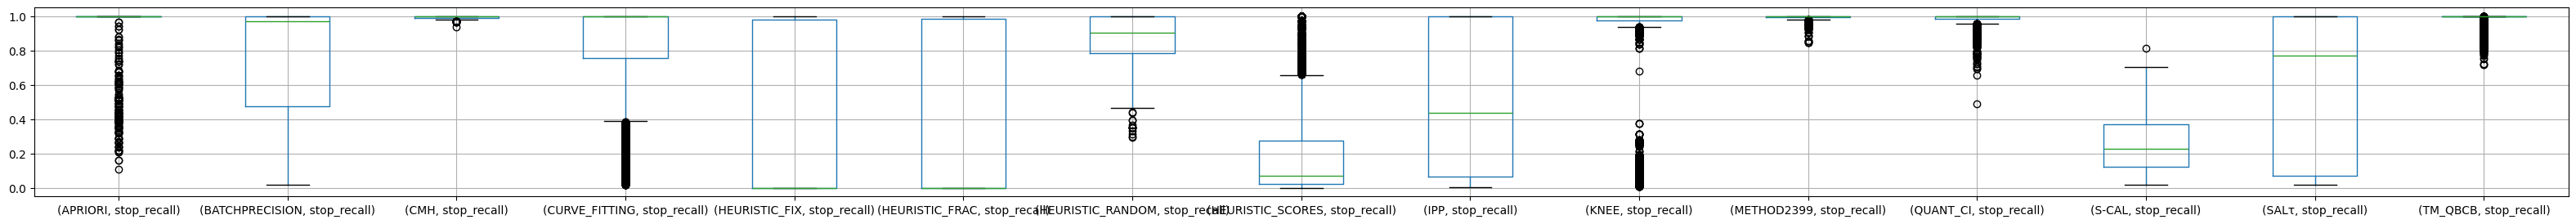

In [14]:
df_res.groupby('method').boxplot(subplots=False, column='stop_recall',  orientation='vertical', figsize=(40, 3))

<Axes: >

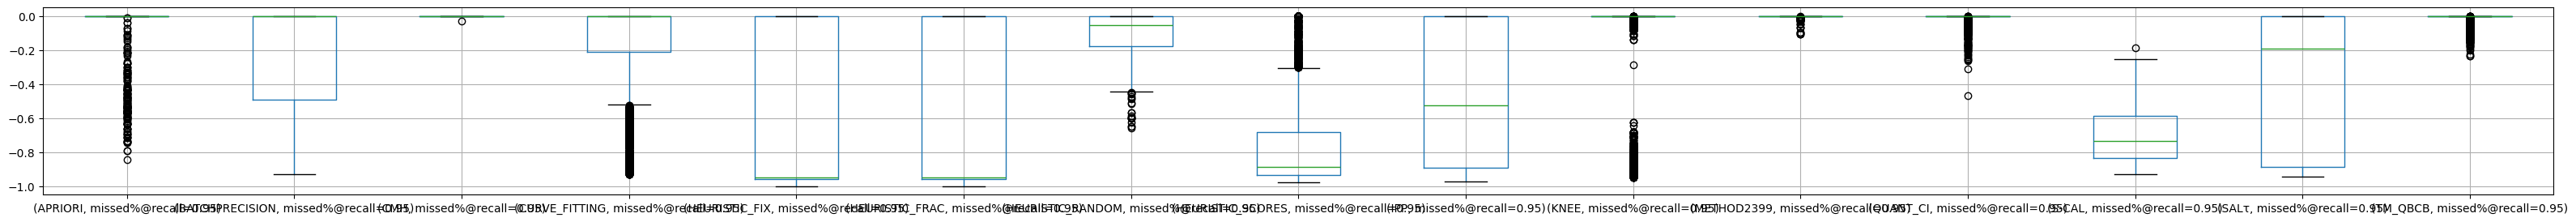

In [15]:
df_res.groupby('method').boxplot(subplots=False, column='missed%@recall=0.95', figsize=(40, 3))

<Axes: >

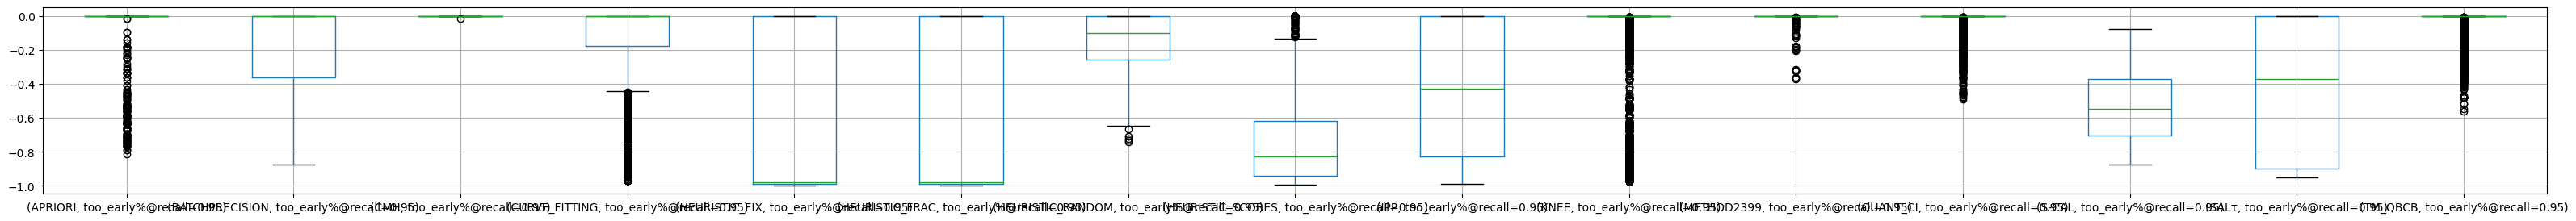

In [16]:
df_res.groupby('method').boxplot(subplots=False, column='too_early%@recall=0.95', figsize=(40, 3))

<Axes: >

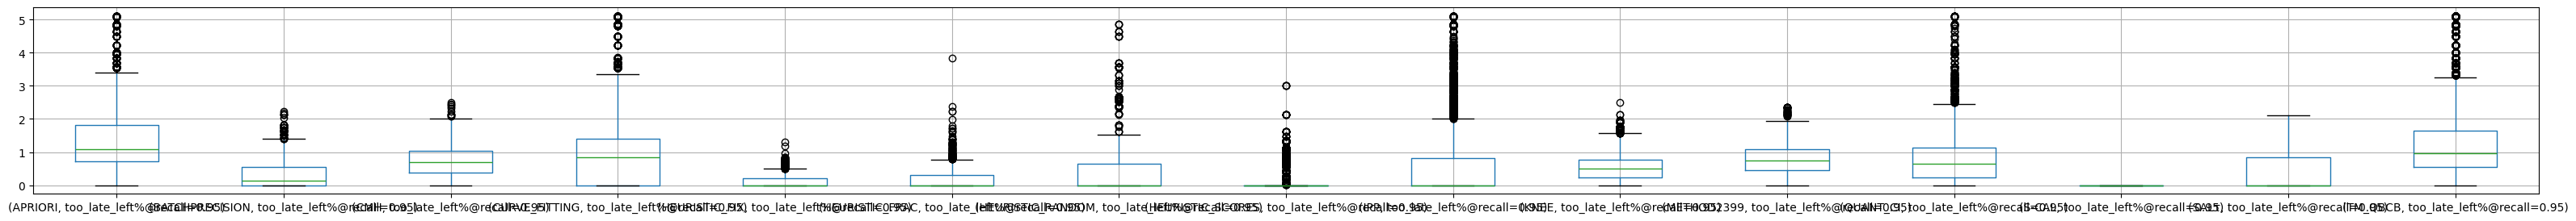

In [17]:
df_res.groupby('method').boxplot(subplots=False, column='too_late_left%@recall=0.95', figsize=(40, 3))

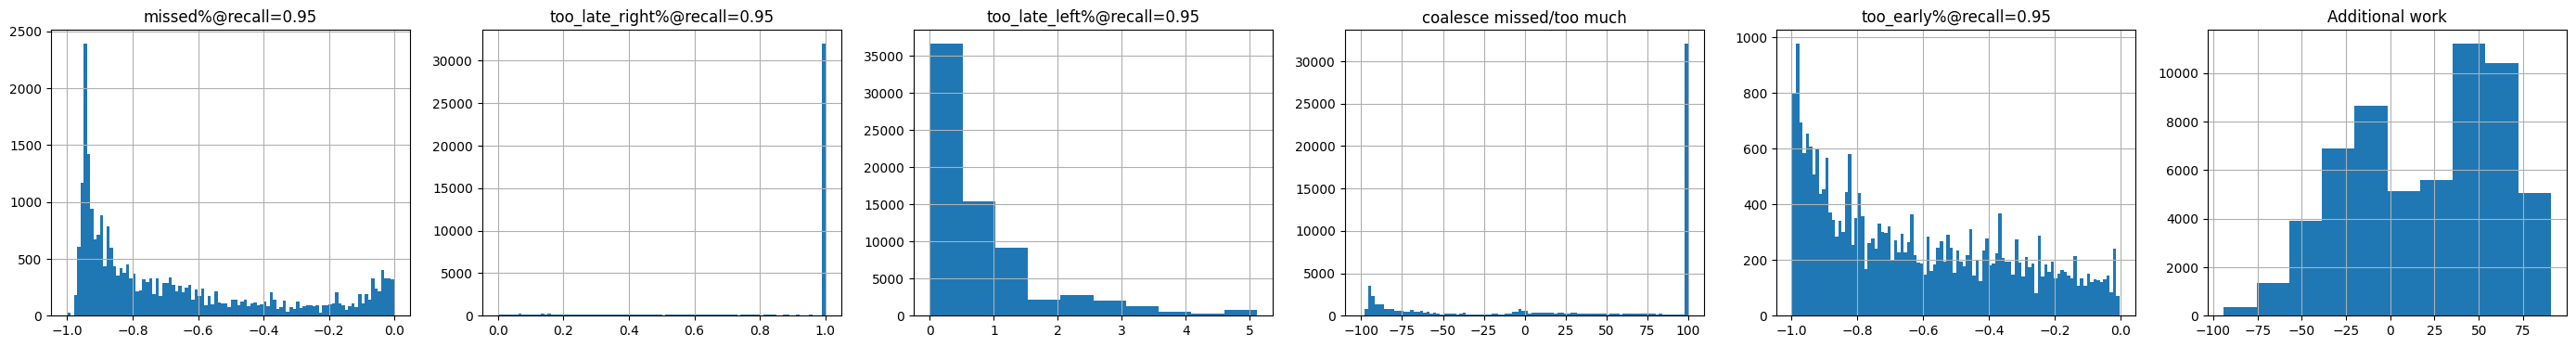

In [18]:
rt = 0.95
fig, (ax1, ax2, ax3, ax4, ax5, ax6) = plt.subplots(1, 6, figsize=(35, 4))

late_ref = ['left', 'right'][1]

df_res['x'] = df_res[[f'too_late_{late_ref}%@recall={rt}', f'missed%@recall={rt}']].replace({0: np.nan}).bfill(axis=1).iloc[:, 0].fillna(0) * 100

ax1.set_title(f'missed%@recall={rt}')
df_res.loc[df_res[f'missed%@recall={rt}']<0, f'missed%@recall={rt}'].hist(bins=100, ax=ax1)

ax2.set_title(f'too_late_{late_ref}%@recall={rt}')
df_res.loc[df_res[f'too_late_{late_ref}%@recall={rt}']>0, f'too_late_{late_ref}%@recall={rt}'].hist(bins=100, ax=ax2)

ax3.set_title('too_late_left%@recall=0.95')
df_res['too_late_left%@recall=0.95'].hist(ax=ax3)

ax4.set_title('coalesce missed/too much')
df_res['x'].hist(bins=100, ax=ax4)

ax5.set_title(f'too_early%@recall={rt}')
df_res.loc[df_res[f'too_early%@recall={rt}']<0, f'too_early%@recall={rt}'].hist(bins=100, ax=ax5)

ax6.set_title('Additional work')
df_res['additional_work'].hist(ax=ax6)

df_res = df_res.drop(columns=['x'])

# Stopping method statistics (missed records)

In [20]:
pd.options.display.max_columns = 650
pd.options.display.max_rows = 100

# 50th Percentile
def q10(x):
    return x.quantile(0.1)

# 90th Percentile
def q90(x):
    return x.quantile(0.9)

table = (
    df_res
    .groupby(['method', 'method-recall_target'], dropna=False)
    .agg({
        'method-hash' : 'count',
        'target_recall_reached': 'sum',
        'stop_recall': [q10, 'median', 'mean', q90],
        'additional_work': 'mean'
    }, skipna=True)
)

# Set zero counts to nan so that downstream we can replace it with ---
# S-CAL never stopped, so value is nan and needs force setting to 0
table['target_recall_reached'] = table['target_recall_reached'].replace(0, np.nan)
table.loc[table.reset_index(level=1).index=='S-CAL', ('target_recall_reached', 'sum')] = 0

# how often is the recall target not achieved?
table['%target_recall_missed'] = 100 * (table[('method-hash', 'count')] - table[('target_recall_reached', 'sum')]) / table[('method-hash', 'count')]
table['recall@stopping [mean (10--90q)]'] = [
    f'{r[('stop_recall', 'mean')]*100:.0f} ({r[('stop_recall', 'q10')]*100:.0f}--{r[('stop_recall', 'q90')]*100:.0f})'
    for _, r in table.iterrows()
]

table = table.reset_index(level=1)
table['method-recall_target'] = table['method-recall_target'] * 100

table_print = table[['method-recall_target',  '%target_recall_missed', 'recall@stopping [mean (10--90q)]', 'additional_work']]
table_print.columns = table_print.columns.droplevel(1)
print(
    table_print
      .style.format({
          'method-recall_target': "{:.0f}",
          '%target_recall_missed': "{:.0f}",
          'additional_work': "{:.0f}",
      }, na_rep='---', escape='latex')
      .to_latex()
      .replace('HEURISTIC','H.')
      .replace('BATCHPRECISION','BATCHP.')
      .replace('METHOD2399','M.2399')
      .replace('CURVE_FITTING','CURVE.')
      .replace('RANDOM','RAND.')
      .replace('_', '\\_')
)

table

\begin{tabular}{lrrlr}
 & method-recall\_target & %target\_recall\_missed & recall@stopping [mean (10--90q)] & additional\_work \\
method &  &  &  &  \\
APRIORI & 80 & 13 & 92 (51--100) & 54 \\
APRIORI & 90 & 4 & 98 (100--100) & 58 \\
APRIORI & 95 & 0 & 100 (100--100) & 54 \\
APRIORI & 99 & 0 & 100 (100--100) & 40 \\
BATCHP. & --- & --- & 76 (16--100) & --- \\
CMH & 80 & 0 & 98 (97--100) & 23 \\
CMH & 90 & 0 & 99 (97--100) & 28 \\
CMH & 95 & 0 & 100 (99--100) & 34 \\
CMH & 99 & 0 & 100 (100--100) & 37 \\
CURVE. & 80 & 32 & 76 (11--100) & 35 \\
CURVE. & 90 & 26 & 82 (18--100) & 40 \\
CURVE. & 95 & 23 & 84 (23--100) & 37 \\
CURVE. & 99 & 22 & 85 (24--100) & 22 \\
H.\_FIX & --- & --- & 34 (0--100) & --- \\
H.\_FRAC & --- & --- & 35 (0--100) & --- \\
H.\_RAND. & 80 & 45 & 79 (61--100) & 8 \\
H.\_RAND. & 90 & 49 & 87 (67--100) & 15 \\
H.\_RAND. & 95 & 51 & 89 (70--100) & 14 \\
H.\_RAND. & 99 & 51 & 91 (73--100) & 5 \\
H.\_SCORES & 80 & 91 & 20 (0--76) & -18 \\
H.\_SCORES & 90 & 91 & 23 (0--

method-recall_target method-hash target_recall_reached  \
                                            count                   sum   
method                                                                    
APRIORI                          80.0         892                 772.0   
APRIORI                          90.0         892                 859.0   
APRIORI                          95.0         892                 888.0   
APRIORI                          99.0         892                 892.0   
BATCHPRECISION                    NaN        2007                   NaN   
CMH                              80.0          44                  44.0   
CMH                              90.0          44                  44.0   
CMH                              95.0          44                  44.0   
CMH                              99.0          44                  44.0   
CURVE_FITTING                    80.0        2976                2034.0   
CURVE_FITTING                    90.0        2976                2190.0   
CURVE_FITTING                    95.0        2976                2277.0   
CURVE_FITTING                    99.0        2976                2312.0   
HEURISTIC_FIX                     NaN         892                   NaN   
HEURISTIC_FRAC                    NaN        1115                   NaN   
HEURISTIC_RANDOM                 80.0         223                 122.0   
HEURISTIC_RANDOM                 90.0         223                 114.0   
HEURISTIC_RANDOM                 95.0         223                 109.0   
HEURISTIC_RANDOM                 99.0         223                 110.0   
HEURISTIC_SCORES                 80.0         892                  84.0   
HEURISTIC_SCORES                 90.0         892                  81.0   
HEURISTIC_SCORES                 95.0         892                  78.0   
HEURISTIC_SCORES                 99.0         892                  73.0   
IPP                              80.0        4460                1852.0   
IPP                              90.0        4460                1812.0   
IPP                              95.0        4460                1775.0   
IPP                              99.0        4460                1687.0   
KNEE                              NaN        8028                   NaN   
METHOD2399                        NaN         669                   NaN   
QUANT_CI                         80.0         669                 645.0   
QUANT_CI                         90.0         669                 652.0   
QUANT_CI                         95.0         669                 648.0   
QUANT_CI                         99.0         669                 636.0   
S-CAL                            80.0         609                   0.0   
S-CAL                            90.0         609                   0.0   
S-CAL                            95.0         609                   0.0   
S-CAL                            99.0         609                   0.0   
SALτ                             80.0         480                  72.0   
SALτ                             90.0         480                 176.0   
SALτ                             95.0         480                 196.0   
SALτ                             99.0         480                 216.0   
TM_QBCB                          80.0        3400                3382.0   
TM_QBCB                          90.0        3400                3397.0   
TM_QBCB                          95.0        3400                3400.0   
TM_QBCB                          99.0        3400                3400.0   

                 stop_recall                               additional_work  \
                         q10    median      mean       q90            mean   
method                                                                       
APRIORI             0.514453  1.000000  0.922383  1.000000       54.397675   
APRIORI             1.000000  1.000000  0.984498  1.000000       57.765430   
APRIORI             1.0000

# Main figure

In [21]:
df_res['method'].unique()

array(['CURVE_FITTING', 'APRIORI', 'BATCHPRECISION', 'HEURISTIC_FIX',
       'HEURISTIC_FRAC', 'HEURISTIC_RANDOM', 'HEURISTIC_SCORES', 'IPP',
       'KNEE', 'METHOD2399', 'QUANT_CI', 'S-CAL', 'TM_QBCB', 'CMH',
       'SALτ'], dtype=object)

In [214]:
n_methods = len(df_res['method'].unique())
n_cols = 4
n_rows = int(np.ceil(n_methods / n_cols))
bins = 20
rt = 0.95

print(n_methods, n_rows, n_cols)

markers = ['x', '.', '+', 'o', 'v', '2', 'D', 's']
colours = ['red', 'green', 'blue', 'orange', 'pink']

def scattered(
      xval, xlab, xlim,
      yval, ylab, ylim,
      vred=False, hred=False,
      fname:str|None = None,
    scalex=1,scaley=1,
):  
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 5 * n_rows), dpi=120)
    xys = []
    hists_x, hists_y = {}, {}
    for meth in sorted(df_res['method'].unique()):
        print(meth)
        mask = df_res['method'] == meth
        df_meth = df_res[mask]
        rt_grp = False
        if meth in ['BUSCAR', 'CMH', 'APRIORI', 'HEURISTIC_SCORES', 'HEURISTIC_RANDOM', 'CURVE_FITTING', 'QUANT_CI', 'IPP', 'TM_QBCB', 'SALτ', 'S-CAL']:
            group_col, groups = 'method-recall_target', {float(v_): f'{v_:.0%} recall target' for v_ in sorted(df_meth['method-recall_target'].unique())}
            rt_grp = True
        elif meth == 'BATCHPRECISION':
            group_col, groups = 'method-threshold', {float(v_): f'Threshold {v_:.0%}' for v_ in sorted(df_meth['method-threshold'].unique())}
        elif meth == 'HEURISTIC_FIX':
            group_col, groups = 'method-num_to_stop', {int(v_): f'{v_:,.0f} consecutive excl.' for v_ in sorted(df_meth['method-num_to_stop'].unique())}
        elif meth == 'HEURISTIC_FRAC':
            group_col, groups = 'method-fraction', {float(v_): f'{v_:.0%} consecutive excl.' for v_ in sorted(df_meth['method-fraction'].unique())}
        elif meth == 'KNEE':
            group_col, groups = 'method-threshold_peak', {float(v_): f'Knee threshold {v_:.0%}' for v_ in sorted(df_meth['method-threshold_peak'].unique())}
        elif meth == 'METHOD2399':
            group_col, groups = 'method-alpha', {float(v_): f'alpha={v_:.1f}' for v_ in sorted(df_meth['method-alpha'].unique())}
    
        for vi, (g, v) in enumerate(groups.items()):
            for rt_ in ([g] if rt_grp else RECALL_TARGETS):
                xy = (
                    df_meth[df_meth[group_col] == g]
                    .rename(columns={xval(rt_): 'x', yval(rt_): 'y'})
                    [['x', 'y']]
                    .assign(
                        xlabel=xlab,
                        ylabel=ylab,
                        method=meth,
                        glabel=v,
                        gval=g,
                    )
                )
    
            xys.append(xy)
    
    df_xy = pd.concat(xys)
    print(df_xy.shape)

    print(len(axes), len(axes[0]))
    
    for mi, (meth, df_meth) in enumerate(df_xy.groupby('method')):
        print(meth, df_meth.shape)
        ax = axes[int(mi / n_rows)][mi % n_cols]
    
        #ax.set_aspect('equal')
        ax_histx = ax.inset_axes([0, 1.05, 1, 0.25])
        ax_histy = ax.inset_axes([1.05, 0, 0.25, 1])
    
        if vred:
            ax.fill_between(np.arange(len(df_meth)) - 100, 5, ylim[1], where=(np.arange(len(df_meth))-100) < 0, facecolor='red', alpha=0.1)
            ax.fill_between(np.arange(len(df_meth)) - 100, 10, ylim[1], where=(np.arange(len(df_meth))-100) < 0, facecolor='red', alpha=0.1)
            ax.fill_between(np.arange(len(df_meth)) - 100, 15, ylim[1], where=(np.arange(len(df_meth))-100) < 0, facecolor='red', alpha=0.1)
            ax.fill_between(np.arange(len(df_meth)) - 100, 20, ylim[1], where=(np.arange(len(df_meth))-100) < 0, facecolor='red', alpha=0.1)
            ax.fill_between(np.arange(len(df_meth)) - 100, ylim[0], ylim[1], where=(np.arange(len(df_meth))-100) < 0, facecolor='red', alpha=0.1)
        if hred:
            ax.fill_between(np.arange(len(df_meth)) - 100, ylim[0], ylim[1], where=(np.arange(len(df_meth))-100) < 0, facecolor='red', alpha=0.1)
            ax.fill_between(np.arange(len(df_meth)) - 100, ylim[0], ylim[1], where=(np.arange(len(df_meth))-100) < -5, facecolor='red', alpha=0.1)
            ax.fill_between(np.arange(len(df_meth)) - 100, ylim[0], ylim[1], where=(np.arange(len(df_meth))-100) < -10, facecolor='red', alpha=0.1)
            ax.fill_between(np.arange(len(df_meth)) - 100, ylim[0], ylim[1], where=(np.arange(len(df_meth))-100) < -15, facecolor='red', alpha=0.1)
            ax.fill_between(np.arange(len(df_meth)) - 100, ylim[0], ylim[1], where=(np.arange(len(df_meth))-100) < -20, facecolor='red', alpha=0.1)
    
        histx, edgex = np.histogram(df_meth['x'], bins=bins, range=xlim)
        histy, edgey = np.histogram(df_meth['y'], bins=bins, range=ylim)
        hists_x[meth] = histx
        hists_y[meth] = histy

        display(pd.DataFrame([edgex, histx/ histx.sum() * 100, edgey, histy/ histy.sum() * 100]))
      
        ax_histx.bar(edgex[:-1], height=histx / histx.sum() * 100, width=(edgex[-1] - edgex[0]) / bins, alpha=0.2)
        ax_histy.barh(y=edgey[:-1], width=histy / histy.sum() * 100, height=(edgey[-1] - edgey[0]) / bins, alpha=0.2)
        
        for vi, (glabel, df_grp) in enumerate(df_meth.groupby('glabel')):
            ax.scatter(df_grp['x'], df_grp['y'], s=3, c=colours[vi], marker=markers[vi], label=glabel)
            
            histx, edgex = np.histogram(df_grp['x'], bins=bins, range=xlim)
            histy, edgey = np.histogram(df_grp['y'], bins=bins, range=ylim)
            ax_histx.plot(edgex[:-1], histx / histx.sum() * 100, alpha=0.5, c=colours[vi], marker=markers[vi], ms=3, lw=1)
            ax_histy.plot(histy / histy.sum() * 100, edgey[:-1], alpha=0.5, c=colours[vi], marker=markers[vi], ms=3, lw=1)
        
        #ax_histy.set_xscale('log')
        ax_histx.tick_params(axis="x", labelbottom=False)
        ax_histy.tick_params(axis="y", labelleft=False)
        #ax_histx.axis('off')
        #ax_histy.axis('off')
        ax.axes.xaxis.set_visible(True)
        ax.axes.yaxis.set_visible(True)
        ax.legend()
    
        ax.set_title(meth)
        ax.set_xlabel(df_meth.iloc[0]['xlabel'])
        ax.set_ylabel(df_meth.iloc[0]['ylabel'])
        ax.grid(lw=0.2, ls='--')
        ax_histx.grid(lw=0.2, ls='--')
        ax_histy.grid(lw=0.2, ls='--')
    
        ax.set_xlim(xlim)
        ax.set_ylim(ylim)
        ax_histx.set_xlim(xlim)
        ax_histx.set_ylim(-5, 50)
        ax_histy.set_xlim(-5, 100)
        ax_histy.set_ylim(ylim)

    for di in range((n_rows * n_cols) - n_methods):
        print(f'dropping axis {n_rows - 1},{n_cols - di - 1}')
        fig.delaxes(axes[n_rows - 1][n_cols - di -1])
        
    fig.tight_layout()
    #fig.show()
    if fname is not None:
        fig.savefig(fname)

    df_hx = pd.DataFrame(hists_x | {xlab: (edgex[:-1]*scalex).astype(int)})
    df_hx_ = df_hx.iloc[:,0:-1].apply(lambda x: x/ x.sum()  * 100, axis=0).join(df_hx.iloc[:,-1])
    print(' & '.join([f'\\rot{{{c.replace('_','\\_')}}}' for c in df_hx_.columns]))
    print(df_hx_.to_latex(index=False, float_format='{:.1f}'.format))
    display(df_hx_.style.background_gradient(cmap='Blues', axis=0))

    df_hy = pd.DataFrame(hists_y | {ylab: (edgey[:-1]*scaley).astype(int)})
    df_hy_ = df_hy.iloc[:,0:-1].apply(lambda y: y / y.sum()  * 100, axis=0).join(df_hy.iloc[:,-1])
    print(df_hy_.to_latex(index=False, float_format='{:.1f}'.format))
    display(df_hy_.style.background_gradient(cmap='Blues', axis=0))
    
    return fig, axes, df_hx, df_hy

15 4 4


## Scatter 1 (remaining abs vs %missed/%WS)

APRIORI
BATCHPRECISION
CMH
CURVE_FITTING
HEURISTIC_FIX
HEURISTIC_FRAC
HEURISTIC_RANDOM
HEURISTIC_SCORES
IPP
KNEE
METHOD2399
QUANT_CI
S-CAL
SALτ
TM_QBCB
(71291, 7)
4 4
APRIORI (3568, 7)


0           1            2            3            4            5   \
0 -105.000000  -94.500000   -84.000000   -73.500000   -63.000000   -52.500000   
1    0.000000    0.000000     0.028027     0.112108     0.588565     1.008969   
2    0.000000  650.000000  1300.000000  1950.000000  2600.000000  3250.000000   
3   20.403587   26.681614    14.910314     5.156951     6.838565     7.959641   

            6            7            8            9            10  \
0   -42.000000   -31.500000   -21.000000   -10.500000     0.000000   
1     0.952915     0.868834     0.476457     0.364350     0.308296   
2  3900.000000  4550.000000  5200.000000  5850.000000  6500.000000   
3     5.156951     3.923767     2.130045     0.672646     1.233184   

           11           12           13           14           15  \
0    10.50000    21.000000    31.500000    42.000000    52.500000   
1     0.00000     0.000000     0.000000     0.000000     0.000000   
2  7150.00000  7800.000000  8450.000000  9100.000000  9750.000000   
3     2.35426     1.121076     0.336323     0.112108     0.112108   

             16           17            18           19       20  
0     63.000000     73.50000     84.000000     94.50000    105.0  
1      0.000000      0.00000      0.000000     95.29148      NaN  
2  10400.000000  11050.00000  11700.000000  12350.00000  13000.0  
3      0.224215      0.44843      0.224215      0.00000      NaN

BATCHPRECISION (2007, 7)


0           1            2            3            4            5   \
0 -105.000000  -94.500000   -84.000000   -73.500000   -63.000000   -52.500000   
1    0.149477    6.527155     5.680120     9.666168     8.570005     9.815645   
2    0.000000  650.000000  1300.000000  1950.000000  2600.000000  3250.000000   
3   44.843049   26.008969     5.829596     8.520179     4.484305     4.932735   

            6            7            8            9            10  \
0   -42.000000   -31.500000   -21.000000   -10.500000     0.000000   
1     8.121574     7.374190     5.779771     4.334828     2.740409   
2  3900.000000  4550.000000  5200.000000  5850.000000  6500.000000   
3     1.345291     1.793722     1.345291     0.448430     0.000000   

            11           12           13           14           15  \
0    10.500000    21.000000    31.500000    42.000000    52.500000   
1     3.238665     2.441455     2.640757     1.893373     1.843548   
2  7150.000000  7800.000000  8450.000000  9100.000000  9750.000000   
3     0.448430     0.000000     0.000000     0.000000     0.000000   

             16            17            18           19       20  
0     63.000000     73.500000     84.000000     94.50000    105.0  
1      1.644245      1.544594      0.896861     15.09716      NaN  
2  10400.000000  11050.000000  11700.000000  12350.00000  13000.0  
3      0.000000      0.000000      0.000000      0.00000      NaN

CMH (176, 7)


0           1            2            3            4            5   \
0 -105.000000  -94.500000   -84.000000   -73.500000   -63.000000   -52.500000   
1    0.000000    0.000000     0.000000     0.000000     0.000000     0.000000   
2    0.000000  650.000000  1300.000000  1950.000000  2600.000000  3250.000000   
3   13.636364   36.363636     6.818182     4.545455     9.090909     6.818182   

            6            7            8       9            10           11  \
0   -42.000000   -31.500000   -21.000000   -10.5     0.000000    10.500000   
1     0.000000     0.000000     0.000000     0.0     0.000000     2.840909   
2  3900.000000  4550.000000  5200.000000  5850.0  6500.000000  7150.000000   
3     6.818182     6.818182     2.272727     0.0     2.272727     2.272727   

            12           13           14      15            16            17  \
0    21.000000    31.500000    42.000000    52.5     63.000000     73.500000   
1    18.750000    13.068182    14.204545    12.5     11.931818     10.795455   
2  7800.000000  8450.000000  9100.000000  9750.0  10400.000000  11050.000000   
3     2.272727     0.000000     0.000000     0.0      0.000000      0.000000   

             18            19       20  
0     84.000000     94.500000    105.0  
1      7.954545      7.954545      NaN  
2  11700.000000  12350.000000  13000.0  
3      0.000000      0.000000      NaN

CURVE_FITTING (11904, 7)


0           1            2            3            4            5   \
0 -105.000000  -94.500000   -84.000000   -73.500000   -63.000000   -52.500000   
1    0.184812    2.444556     2.923387     3.629032     3.242608     3.612231   
2    0.000000  650.000000  1300.000000  1950.000000  2600.000000  3250.000000   
3   19.086022   23.387097    15.893817     6.619624     7.896505     9.173387   

            6            7            8            9            10  \
0   -42.000000   -31.500000   -21.000000   -10.500000     0.000000   
1     3.217406     3.049395     2.200941     1.461694     0.504032   
2  3900.000000  4550.000000  5200.000000  5850.000000  6500.000000   
3     5.241935     3.897849     1.209677     0.537634     1.041667   

            11           12           13           14           15  \
0    10.500000    21.000000    31.500000    42.000000    52.500000   
1     0.067204     0.042003     0.201613     0.613239     1.335685   
2  7150.000000  7800.000000  8450.000000  9100.000000  9750.000000   
3     2.251344     1.444892     0.537634     0.168011     0.168011   

             16            17            18            19       20  
0     63.000000     73.500000     84.000000     94.500000    105.0  
1      1.663306      2.041331      1.814516     65.751008      NaN  
2  10400.000000  11050.000000  11700.000000  12350.000000  13000.0  
3      0.369624      0.705645      0.369624      0.000000      NaN

HEURISTIC_FIX (892, 7)


0           1            2            3            4            5   \
0 -105.000000  -94.500000   -84.000000   -73.500000   -63.000000   -52.500000   
1   56.950673    5.493274     2.017937     1.457399     1.681614     3.026906   
2    0.000000  650.000000  1300.000000  1950.000000  2600.000000  3250.000000   
3   44.843049   26.008969     5.829596     8.520179     4.484305     4.932735   

            6            7            8            9            10  \
0   -42.000000   -31.500000   -21.000000   -10.500000     0.000000   
1     3.811659     5.156951     5.044843     4.035874     1.008969   
2  3900.000000  4550.000000  5200.000000  5850.000000  6500.000000   
3     1.345291     1.793722     1.345291     0.448430     0.000000   

           11           12           13           14           15  \
0    10.50000    21.000000    31.500000    42.000000    52.500000   
1     1.90583     1.457399     1.681614     0.560538     0.896861   
2  7150.00000  7800.000000  8450.000000  9100.000000  9750.000000   
3     0.44843     0.000000     0.000000     0.000000     0.000000   

             16            17           18            19       20  
0     63.000000     73.500000     84.00000     94.500000    105.0  
1      0.560538      0.336323      0.44843      2.466368      NaN  
2  10400.000000  11050.000000  11700.00000  12350.000000  13000.0  
3      0.000000      0.000000      0.00000      0.000000      NaN

HEURISTIC_FRAC (1115, 7)


0           1            2            3            4            5   \
0 -105.000000  -94.500000   -84.000000   -73.500000   -63.000000   -52.500000   
1   58.654709    3.856502     1.614350     1.165919     0.807175     1.165919   
2    0.000000  650.000000  1300.000000  1950.000000  2600.000000  3250.000000   
3   44.843049   26.008969     5.829596     8.520179     4.484305     4.932735   

            6            7            8            9            10  \
0   -42.000000   -31.500000   -21.000000   -10.500000     0.000000   
1     2.780269     5.022422     5.201794     4.125561     0.538117   
2  3900.000000  4550.000000  5200.000000  5850.000000  6500.000000   
3     1.345291     1.793722     1.345291     0.448430     0.000000   

            11           12          13           14           15  \
0    10.500000    21.000000    31.50000    42.000000    52.500000   
1     2.959641     2.331839     2.06278     1.255605     1.255605   
2  7150.000000  7800.000000  8450.00000  9100.000000  9750.000000   
3     0.448430     0.000000     0.00000     0.000000     0.000000   

             16            17            18            19       20  
0     63.000000     73.500000     84.000000     94.500000    105.0  
1      0.717489      0.896861      0.538117      3.049327      NaN  
2  10400.000000  11050.000000  11700.000000  12350.000000  13000.0  
3      0.000000      0.000000      0.000000      0.000000      NaN

HEURISTIC_RANDOM (892, 7)


0           1            2            3            4            5   \
0 -105.000000  -94.500000   -84.000000   -73.500000   -63.000000   -52.500000   
1    0.000000    0.000000     0.336323     1.793722     2.578475     3.587444   
2    0.000000  650.000000  1300.000000  1950.000000  2600.000000  3250.000000   
3   20.403587   26.681614    14.910314     5.156951     6.838565     7.959641   

            6            7            8            9            10  \
0   -42.000000   -31.500000   -21.000000   -10.500000     0.000000   
1     5.605381     8.183857    14.237668    12.668161    16.591928   
2  3900.000000  4550.000000  5200.000000  5850.000000  6500.000000   
3     5.156951     3.923767     2.130045     0.672646     1.233184   

            11           12           13           14           15  \
0    10.500000    21.000000    31.500000    42.000000    52.500000   
1     3.026906     1.457399     0.784753     0.448430     0.336323   
2  7150.000000  7800.000000  8450.000000  9100.000000  9750.000000   
3     2.354260     1.121076     0.336323     0.112108     0.112108   

             16            17            18            19       20  
0     63.000000     73.500000     84.000000     94.500000    105.0  
1      0.112108      0.224215      0.112108     27.914798      NaN  
2  10400.000000  11050.000000  11700.000000  12350.000000  13000.0  
3      0.224215      0.448430      0.224215      0.000000      NaN

HEURISTIC_SCORES (3568, 7)


0           1            2            3            4            5   \
0 -105.000000  -94.500000   -84.000000   -73.500000   -63.000000   -52.500000   
1   23.542601   23.150224    14.798206    10.650224     6.950673     4.568386   
2    0.000000  650.000000  1300.000000  1950.000000  2600.000000  3250.000000   
3   20.403587   26.681614    14.910314     5.156951     6.838565     7.959641   

            6            7            8            9            10  \
0   -42.000000   -31.500000   -21.000000   -10.500000     0.000000   
1     3.391256     1.905830     1.205157     0.980942     0.728700   
2  3900.000000  4550.000000  5200.000000  5850.000000  6500.000000   
3     5.156951     3.923767     2.130045     0.672646     1.233184   

            11           12           13           14           15  \
0    10.500000    21.000000    31.500000    42.000000    52.500000   
1     0.224215     0.056054     0.028027     0.028027     0.056054   
2  7150.000000  7800.000000  8450.000000  9100.000000  9750.000000   
3     2.354260     1.121076     0.336323     0.112108     0.112108   

             16           17            18            19       20  
0     63.000000     73.50000     84.000000     94.500000    105.0  
1      0.000000      0.00000      0.000000      7.735426      NaN  
2  10400.000000  11050.00000  11700.000000  12350.000000  13000.0  
3      0.224215      0.44843      0.224215      0.000000      NaN

IPP (17840, 7)


0           1            2            3            4            5   \
0 -105.000000  -94.500000   -84.000000   -73.500000   -63.000000   -52.500000   
1    8.385650   14.943946     9.299327     6.367713     4.938341     4.988789   
2    0.000000  650.000000  1300.000000  1950.000000  2600.000000  3250.000000   
3   20.403587   26.681614    14.910314     5.156951     6.838565     7.959641   

            6            7            8            9            10  \
0   -42.000000   -31.500000   -21.000000   -10.500000     0.000000   
1     4.260090     3.110987     2.343049     1.418161     1.216368   
2  3900.000000  4550.000000  5200.000000  5850.000000  6500.000000   
3     5.156951     3.923767     2.130045     0.672646     1.233184   

            11           12           13           14           15  \
0    10.500000    21.000000    31.500000    42.000000    52.500000   
1     0.874439     1.272422     1.653587     1.440583     0.924888   
2  7150.000000  7800.000000  8450.000000  9100.000000  9750.000000   
3     2.354260     1.121076     0.336323     0.112108     0.112108   

             16            17            18            19       20  
0     63.000000     73.500000     84.000000     94.500000    105.0  
1      1.160314      1.272422      0.952915     29.176009      NaN  
2  10400.000000  11050.000000  11700.000000  12350.000000  13000.0  
3      0.224215      0.448430      0.224215      0.000000      NaN

KNEE (8028, 7)


0           1            2            3            4            5   \
0 -105.000000  -94.500000   -84.000000   -73.500000   -63.000000   -52.500000   
1    2.055306    3.923767     2.528650     2.777778     3.612357     4.471849   
2    0.000000  650.000000  1300.000000  1950.000000  2600.000000  3250.000000   
3   44.843049   26.008969     5.829596     8.520179     4.484305     4.932735   

            6            7            8            9           10          11  \
0   -42.000000   -31.500000   -21.000000   -10.500000     0.00000    10.50000   
1     5.854509     7.286996     7.100149     7.424016     4.22272     4.57150   
2  3900.000000  4550.000000  5200.000000  5850.000000  6500.00000  7150.00000   
3     1.345291     1.793722     1.345291     0.448430     0.00000     0.44843   

            12           13           14           15            16  \
0    21.000000    31.500000    42.000000    52.500000     63.000000   
1     4.546587     3.226208     3.263577     2.615845      3.139013   
2  7800.000000  8450.000000  9100.000000  9750.000000  10400.000000   
3     0.000000     0.000000     0.000000     0.000000      0.000000   

             17            18            19       20  
0     73.500000     84.000000     94.500000    105.0  
1      2.017937      1.930742     23.430493      NaN  
2  11050.000000  11700.000000  12350.000000  13000.0  
3      0.000000      0.000000      0.000000      NaN

METHOD2399 (669, 7)


0           1            2            3            4            5   \
0 -105.000000  -94.500000   -84.000000   -73.500000   -63.000000   -52.500000   
1    0.000000    0.000000     0.149477     2.391629     3.736921     2.690583   
2    0.000000  650.000000  1300.000000  1950.000000  2600.000000  3250.000000   
3   44.843049   26.008969     5.829596     8.520179     4.484305     4.932735   

            6            7            8            9            10  \
0   -42.000000   -31.500000   -21.000000   -10.500000     0.000000   
1     7.025411     5.381166     6.128550     4.633782     2.242152   
2  3900.000000  4550.000000  5200.000000  5850.000000  6500.000000   
3     1.345291     1.793722     1.345291     0.448430     0.000000   

            11          12           13           14           15  \
0    10.500000    21.00000    31.500000    42.000000    52.500000   
1     1.195815     2.84006     3.139013     1.644245     1.943199   
2  7150.000000  7800.00000  8450.000000  9100.000000  9750.000000   
3     0.448430     0.00000     0.000000     0.000000     0.000000   

             16            17            18            19       20  
0     63.000000     73.500000     84.000000     94.500000    105.0  
1      0.149477      2.242152      1.943199     50.523169      NaN  
2  10400.000000  11050.000000  11700.000000  12350.000000  13000.0  
3      0.000000      0.000000      0.000000      0.000000      NaN

QUANT_CI (2676, 7)


0           1            2            3            4            5   \
0 -105.000000  -94.500000   -84.000000   -73.500000   -63.000000   -52.500000   
1    0.000000    0.000000     0.000000     0.000000     0.000000     0.000000   
2    0.000000  650.000000  1300.000000  1950.000000  2600.000000  3250.000000   
3   20.403587   26.681614    14.910314     5.156951     6.838565     7.959641   

            6            7            8            9            10  \
0   -42.000000   -31.500000   -21.000000   -10.500000     0.000000   
1     0.037369     0.112108     1.195815     2.204783     8.146487   
2  3900.000000  4550.000000  5200.000000  5850.000000  6500.000000   
3     5.156951     3.923767     2.130045     0.672646     1.233184   

            11           12           13           14           15  \
0    10.500000    21.000000    31.500000    42.000000    52.500000   
1    10.313901     8.707025     5.979073     5.306428     5.418535   
2  7150.000000  7800.000000  8450.000000  9100.000000  9750.000000   
3     2.354260     1.121076     0.336323     0.112108     0.112108   

             16            17            18            19       20  
0     63.000000     73.500000     84.000000     94.500000    105.0  
1      4.484305      4.147982      4.671151     39.275037      NaN  
2  10400.000000  11050.000000  11700.000000  12350.000000  13000.0  
3      0.224215      0.448430      0.224215      0.000000      NaN

S-CAL (2436, 7)


0           1            2            3            4            5   \
0 -105.000000  -94.500000   -84.000000   -73.500000   -63.000000   -52.500000   
1    0.000000    4.802956    13.505747    14.244663    14.696223    15.804598   
2    0.000000  650.000000  1300.000000  1950.000000  2600.000000  3250.000000   
3   20.320197   25.492611    15.270936     5.541872     7.266010     7.758621   

            6            7            8            9           10  \
0   -42.000000   -31.500000   -21.000000   -10.500000     0.00000   
1    14.408867    10.591133     9.482759     2.463054     0.00000   
2  3900.000000  4550.000000  5200.000000  5850.000000  6500.00000   
3     5.049261     3.940887     1.847291     0.738916     1.35468   

            11           12           13           14           15  \
0    10.500000    21.000000    31.500000    42.000000    52.500000   
1     0.000000     0.000000     0.000000     0.000000     0.000000   
2  7150.000000  7800.000000  8450.000000  9100.000000  9750.000000   
3     2.586207     1.231527     0.369458     0.123153     0.123153   

             16            17            18       19       20  
0     63.000000     73.500000     84.000000     94.5    105.0  
1      0.000000      0.000000      0.000000      0.0      NaN  
2  10400.000000  11050.000000  11700.000000  12350.0  13000.0  
3      0.246305      0.492611      0.246305      0.0      NaN

SALτ (1920, 7)


0           1            2         3            4        5   \
0 -105.000000  -94.500000   -84.000000   -73.500   -63.000000   -52.50   
1    8.333333   25.416667     0.416667     3.125     1.666667     3.75   
2    0.000000  650.000000  1300.000000  1950.000  2600.000000  3250.00   
3   18.750000   43.750000    18.750000     0.000     6.250000    12.50   

       6        7         8            9         10        11      12  \
0   -42.0   -31.50   -21.000   -10.500000     0.000    10.500    21.0   
1     5.0     6.25     1.875     9.791667     1.875     1.875     0.0   
2  3900.0  4550.00  5200.000  5850.000000  6500.000  7150.000  7800.0   
3     0.0     0.00     0.000     0.000000     0.000     0.000     0.0   

            13      14           15       16       17       18        19  \
0    31.500000    42.0    52.500000     63.0     73.5     84.0     94.50   
1     0.833333     0.0     1.041667      0.0      0.0      0.0     28.75   
2  8450.000000  9100.0  9750.000000  10400.0  11050.0  11700.0  12350.00   
3     0.000000     0.0     0.000000      0.0      0.0      0.0      0.00   

        20  
0    105.0  
1      NaN  
2  13000.0  
3      NaN

TM_QBCB (13600, 7)


0           1            2            3            4            5   \
0 -105.000000  -94.500000   -84.000000   -73.500000   -63.000000   -52.500000   
1    0.000000    0.000000     0.000000     0.000000     0.000000     0.000000   
2    0.000000  650.000000  1300.000000  1950.000000  2600.000000  3250.000000   
3   18.823529   25.147059    16.470588     6.176471     7.058824     8.088235   

       6            7            8            9            10           11  \
0   -42.0   -31.500000   -21.000000   -10.500000     0.000000    10.500000   
1     0.0     0.000000     0.007353     0.147059     7.529412     4.301471   
2  3900.0  4550.000000  5200.000000  5850.000000  6500.000000  7150.000000   
3     5.0     3.970588     1.323529     0.735294     1.470588     2.500000   

            12           13           14           15            16  \
0    21.000000    31.500000    42.000000    52.500000     63.000000   
1     2.411765     1.279412     0.919118     0.544118      0.404412   
2  7800.000000  8450.000000  9100.000000  9750.000000  10400.000000   
3     1.323529     0.441176     0.147059     0.147059      0.294118   

             17            18            19       20  
0     73.500000     84.000000     94.500000    105.0  
1      0.279412      0.088235     82.088235      NaN  
2  11050.000000  11700.000000  12350.000000  13000.0  
3      0.588235      0.294118      0.000000      NaN

dropping axis 3,3
\rot{APRIORI} & \rot{BATCHPRECISION} & \rot{CMH} & \rot{CURVE\_FITTING} & \rot{HEURISTIC\_FIX} & \rot{HEURISTIC\_FRAC} & \rot{HEURISTIC\_RANDOM} & \rot{HEURISTIC\_SCORES} & \rot{IPP} & \rot{KNEE} & \rot{METHOD2399} & \rot{QUANT\_CI} & \rot{S-CAL} & \rot{SALτ} & \rot{TM\_QBCB} & \rot{% missed includes / % unused work-saving}
\begin{tabular}{rrrrrrrrrrrrrrrr}
\toprule
APRIORI & BATCHPRECISION & CMH & CURVE_FITTING & HEURISTIC_FIX & HEURISTIC_FRAC & HEURISTIC_RANDOM & HEURISTIC_SCORES & IPP & KNEE & METHOD2399 & QUANT_CI & S-CAL & SALτ & TM_QBCB & % missed includes / % unused work-saving \\
\midrule
0.0 & 0.1 & 0.0 & 0.2 & 57.0 & 58.7 & 0.0 & 23.5 & 8.4 & 2.1 & 0.0 & 0.0 & 0.0 & 8.3 & 0.0 & -105 \\
0.0 & 6.5 & 0.0 & 2.4 & 5.5 & 3.9 & 0.0 & 23.2 & 14.9 & 3.9 & 0.0 & 0.0 & 4.8 & 25.4 & 0.0 & -94 \\
0.0 & 5.7 & 0.0 & 2.9 & 2.0 & 1.6 & 0.3 & 14.8 & 9.3 & 2.5 & 0.1 & 0.0 & 13.5 & 0.4 & 0.0 & -84 \\
0.1 & 9.7 & 0.0 & 3.6 & 1.5 & 1.2 & 1.8 & 10.7 & 6.4 & 2.8 & 2.4 & 0.0 & 14.2 

\begin{tabular}{rrrrrrrrrrrrrrrr}
\toprule
APRIORI & BATCHPRECISION & CMH & CURVE_FITTING & HEURISTIC_FIX & HEURISTIC_FRAC & HEURISTIC_RANDOM & HEURISTIC_SCORES & IPP & KNEE & METHOD2399 & QUANT_CI & S-CAL & SALτ & TM_QBCB & Remaining after recall target \\
\midrule
20.4 & 44.8 & 13.6 & 19.1 & 44.8 & 44.8 & 20.4 & 20.4 & 20.4 & 44.8 & 44.8 & 20.4 & 20.3 & 18.8 & 18.8 & 0 \\
26.7 & 26.0 & 36.4 & 23.4 & 26.0 & 26.0 & 26.7 & 26.7 & 26.7 & 26.0 & 26.0 & 26.7 & 25.5 & 43.8 & 25.1 & 650 \\
14.9 & 5.8 & 6.8 & 15.9 & 5.8 & 5.8 & 14.9 & 14.9 & 14.9 & 5.8 & 5.8 & 14.9 & 15.3 & 18.8 & 16.5 & 1300 \\
5.2 & 8.5 & 4.5 & 6.6 & 8.5 & 8.5 & 5.2 & 5.2 & 5.2 & 8.5 & 8.5 & 5.2 & 5.5 & 0.0 & 6.2 & 1950 \\
6.8 & 4.5 & 9.1 & 7.9 & 4.5 & 4.5 & 6.8 & 6.8 & 6.8 & 4.5 & 4.5 & 6.8 & 7.3 & 6.2 & 7.1 & 2600 \\
8.0 & 4.9 & 6.8 & 9.2 & 4.9 & 4.9 & 8.0 & 8.0 & 8.0 & 4.9 & 4.9 & 8.0 & 7.8 & 12.5 & 8.1 & 3250 \\
5.2 & 1.3 & 6.8 & 5.2 & 1.3 & 1.3 & 5.2 & 5.2 & 5.2 & 1.3 & 1.3 & 5.2 & 5.0 & 0.0 & 5.0 & 3900 \\
3.9 & 1.8 &

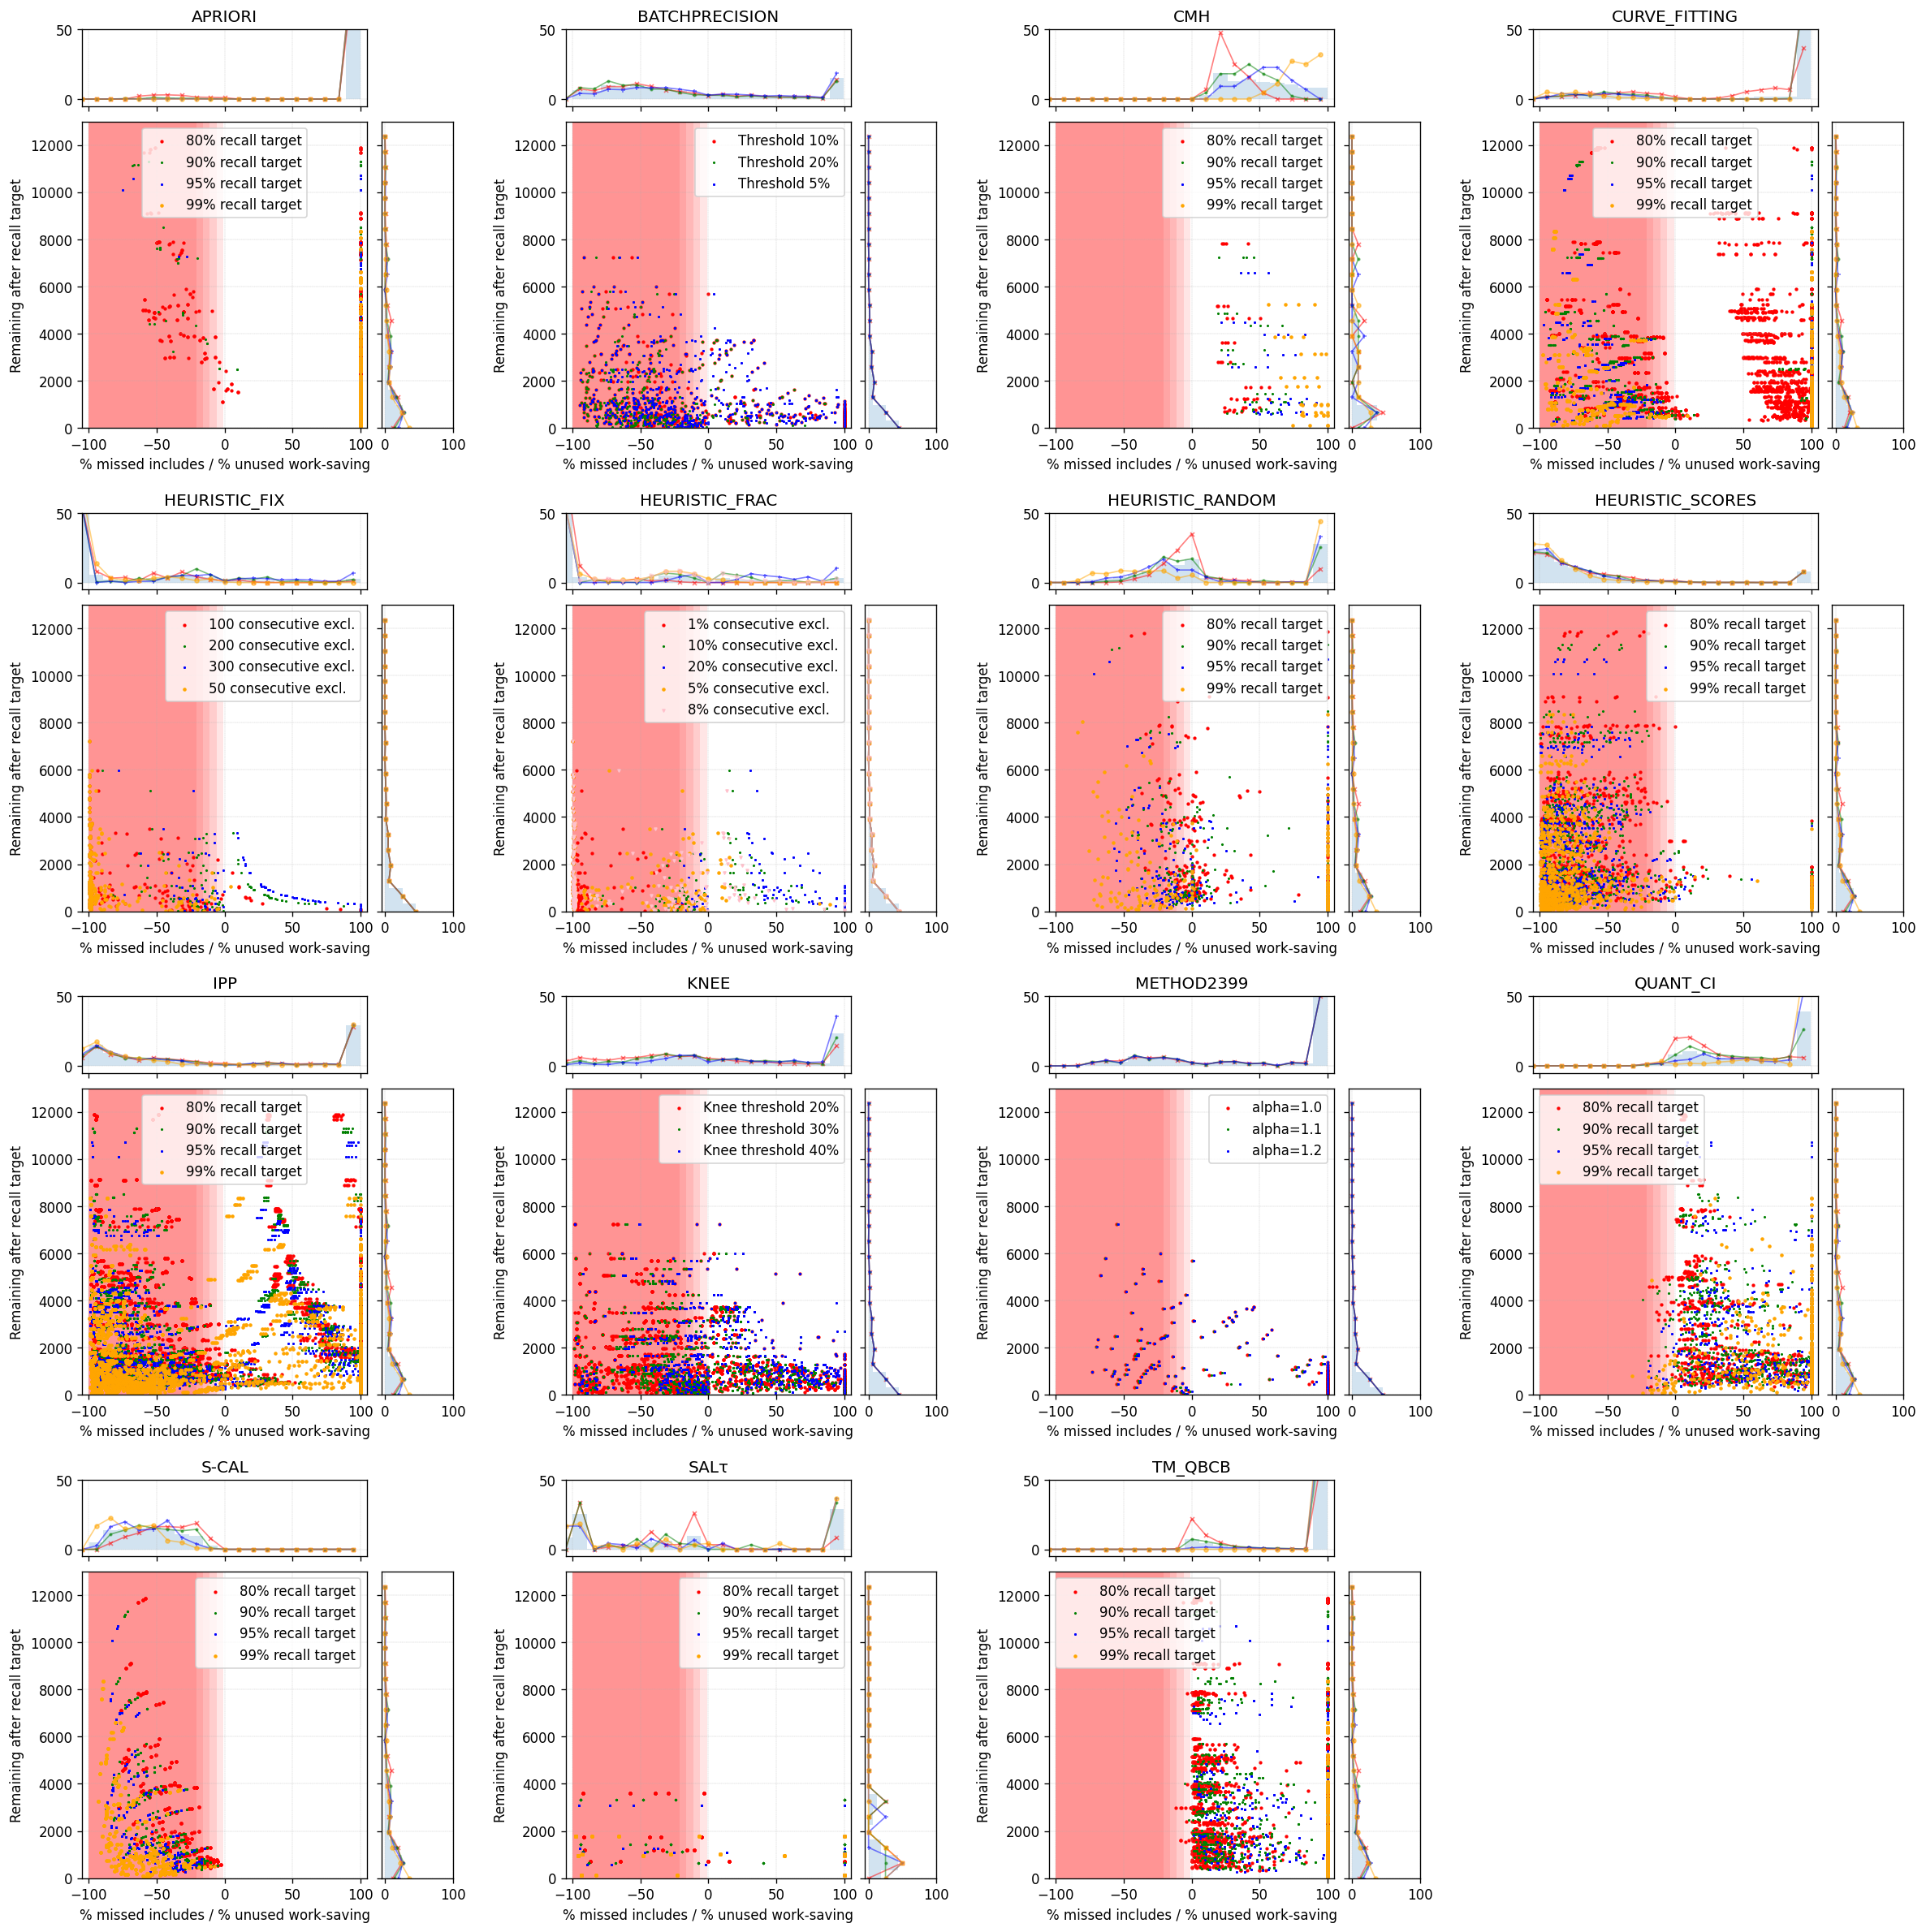

In [215]:
fig, _, df_hx, _ = scattered(
    xval=lambda x: f'tetl_right@recall={x}', xlab='% missed includes / % unused work-saving', xlim=(-105, 105),
    yval=lambda x: f'unseen@recall={x}', ylab='Remaining after recall target', ylim=(0, 13000),
    vred=False, hred=True,
    fname='../data/plots/scatter1.pdf',
)

## Scatter 2 (%missed vs %before/after target)

APRIORI
BATCHPRECISION
CMH
CURVE_FITTING
HEURISTIC_FIX
HEURISTIC_FRAC
HEURISTIC_RANDOM
HEURISTIC_SCORES
IPP
KNEE
METHOD2399
QUANT_CI
S-CAL
SALτ
TM_QBCB
(71291, 7)
4 4
APRIORI (3568, 7)
BATCHPRECISION (2007, 7)
CMH (176, 7)
CURVE_FITTING (11904, 7)
HEURISTIC_FIX (892, 7)
HEURISTIC_FRAC (1115, 7)
HEURISTIC_RANDOM (892, 7)
HEURISTIC_SCORES (3568, 7)
IPP (17840, 7)
KNEE (8028, 7)
METHOD2399 (669, 7)
QUANT_CI (2676, 7)
S-CAL (2436, 7)
SALτ (1920, 7)
TM_QBCB (13600, 7)
dropping axis 3,3
\rot{APRIORI} & \rot{BATCHPRECISION} & \rot{CMH} & \rot{CURVE_FITTING} & \rot{HEURISTIC_FIX} & \rot{HEURISTIC_FRAC} & \rot{HEURISTIC_RANDOM} & \rot{HEURISTIC_SCORES} & \rot{IPP} & \rot{KNEE} & \rot{METHOD2399} & \rot{QUANT_CI} & \rot{S-CAL} & \rot{SALτ} & \rot{TM_QBCB} & \rot{% before/after recall target}
\begin{tabular}{rrrrrrrrrrrrrrrr}
\toprule
APRIORI & BATCHPRECISION & CMH & CURVE_FITTING & HEURISTIC_FIX & HEURISTIC_FRAC & HEURISTIC_RANDOM & HEURISTIC_SCORES & IPP & KNEE & METHOD2399 & QUANT_CI & S-CAL &

\begin{tabular}{rrrrrrrrrrrrrrrr}
\toprule
APRIORI & BATCHPRECISION & CMH & CURVE_FITTING & HEURISTIC_FIX & HEURISTIC_FRAC & HEURISTIC_RANDOM & HEURISTIC_SCORES & IPP & KNEE & METHOD2399 & QUANT_CI & S-CAL & SALτ & TM_QBCB & % missed includes \\
\midrule
95.6 & 35.4 & 100.0 & 74.0 & 13.5 & 18.2 & 51.2 & 8.9 & 40.0 & 56.0 & 72.5 & 96.7 & 0.0 & 34.4 & 99.9 & -5 \\
0.1 & 23.0 & 0.0 & 0.1 & 18.3 & 15.1 & 10.4 & 0.9 & 1.1 & 30.3 & 23.8 & 2.3 & 0.0 & 10.6 & 0.1 & 0 \\
0.1 & 6.8 & 0.0 & 0.6 & 1.8 & 0.9 & 12.2 & 1.1 & 1.0 & 3.3 & 2.4 & 0.6 & 0.0 & 0.8 & 0.0 & 6 \\
0.3 & 2.4 & 0.0 & 0.4 & 0.2 & 0.2 & 8.5 & 1.0 & 0.8 & 0.2 & 1.3 & 0.3 & 0.0 & 2.9 & 0.0 & 11 \\
0.3 & 1.9 & 0.0 & 0.8 & 0.2 & 0.1 & 5.2 & 1.8 & 0.9 & 0.0 & 0.0 & 0.1 & 1.3 & 4.8 & 0.0 & 17 \\
0.3 & 0.9 & 0.0 & 0.7 & 0.0 & 0.1 & 5.2 & 1.4 & 1.1 & 0.0 & 0.0 & 0.0 & 0.6 & 2.5 & 0.0 & 22 \\
0.7 & 0.2 & 0.0 & 1.0 & 0.0 & 0.0 & 3.1 & 1.5 & 1.3 & 0.0 & 0.0 & 0.0 & 2.8 & 0.0 & 0.0 & 28 \\
0.5 & 1.2 & 0.0 & 1.1 & 0.0 & 0.0 & 1.7 & 1.7 & 1.3 &

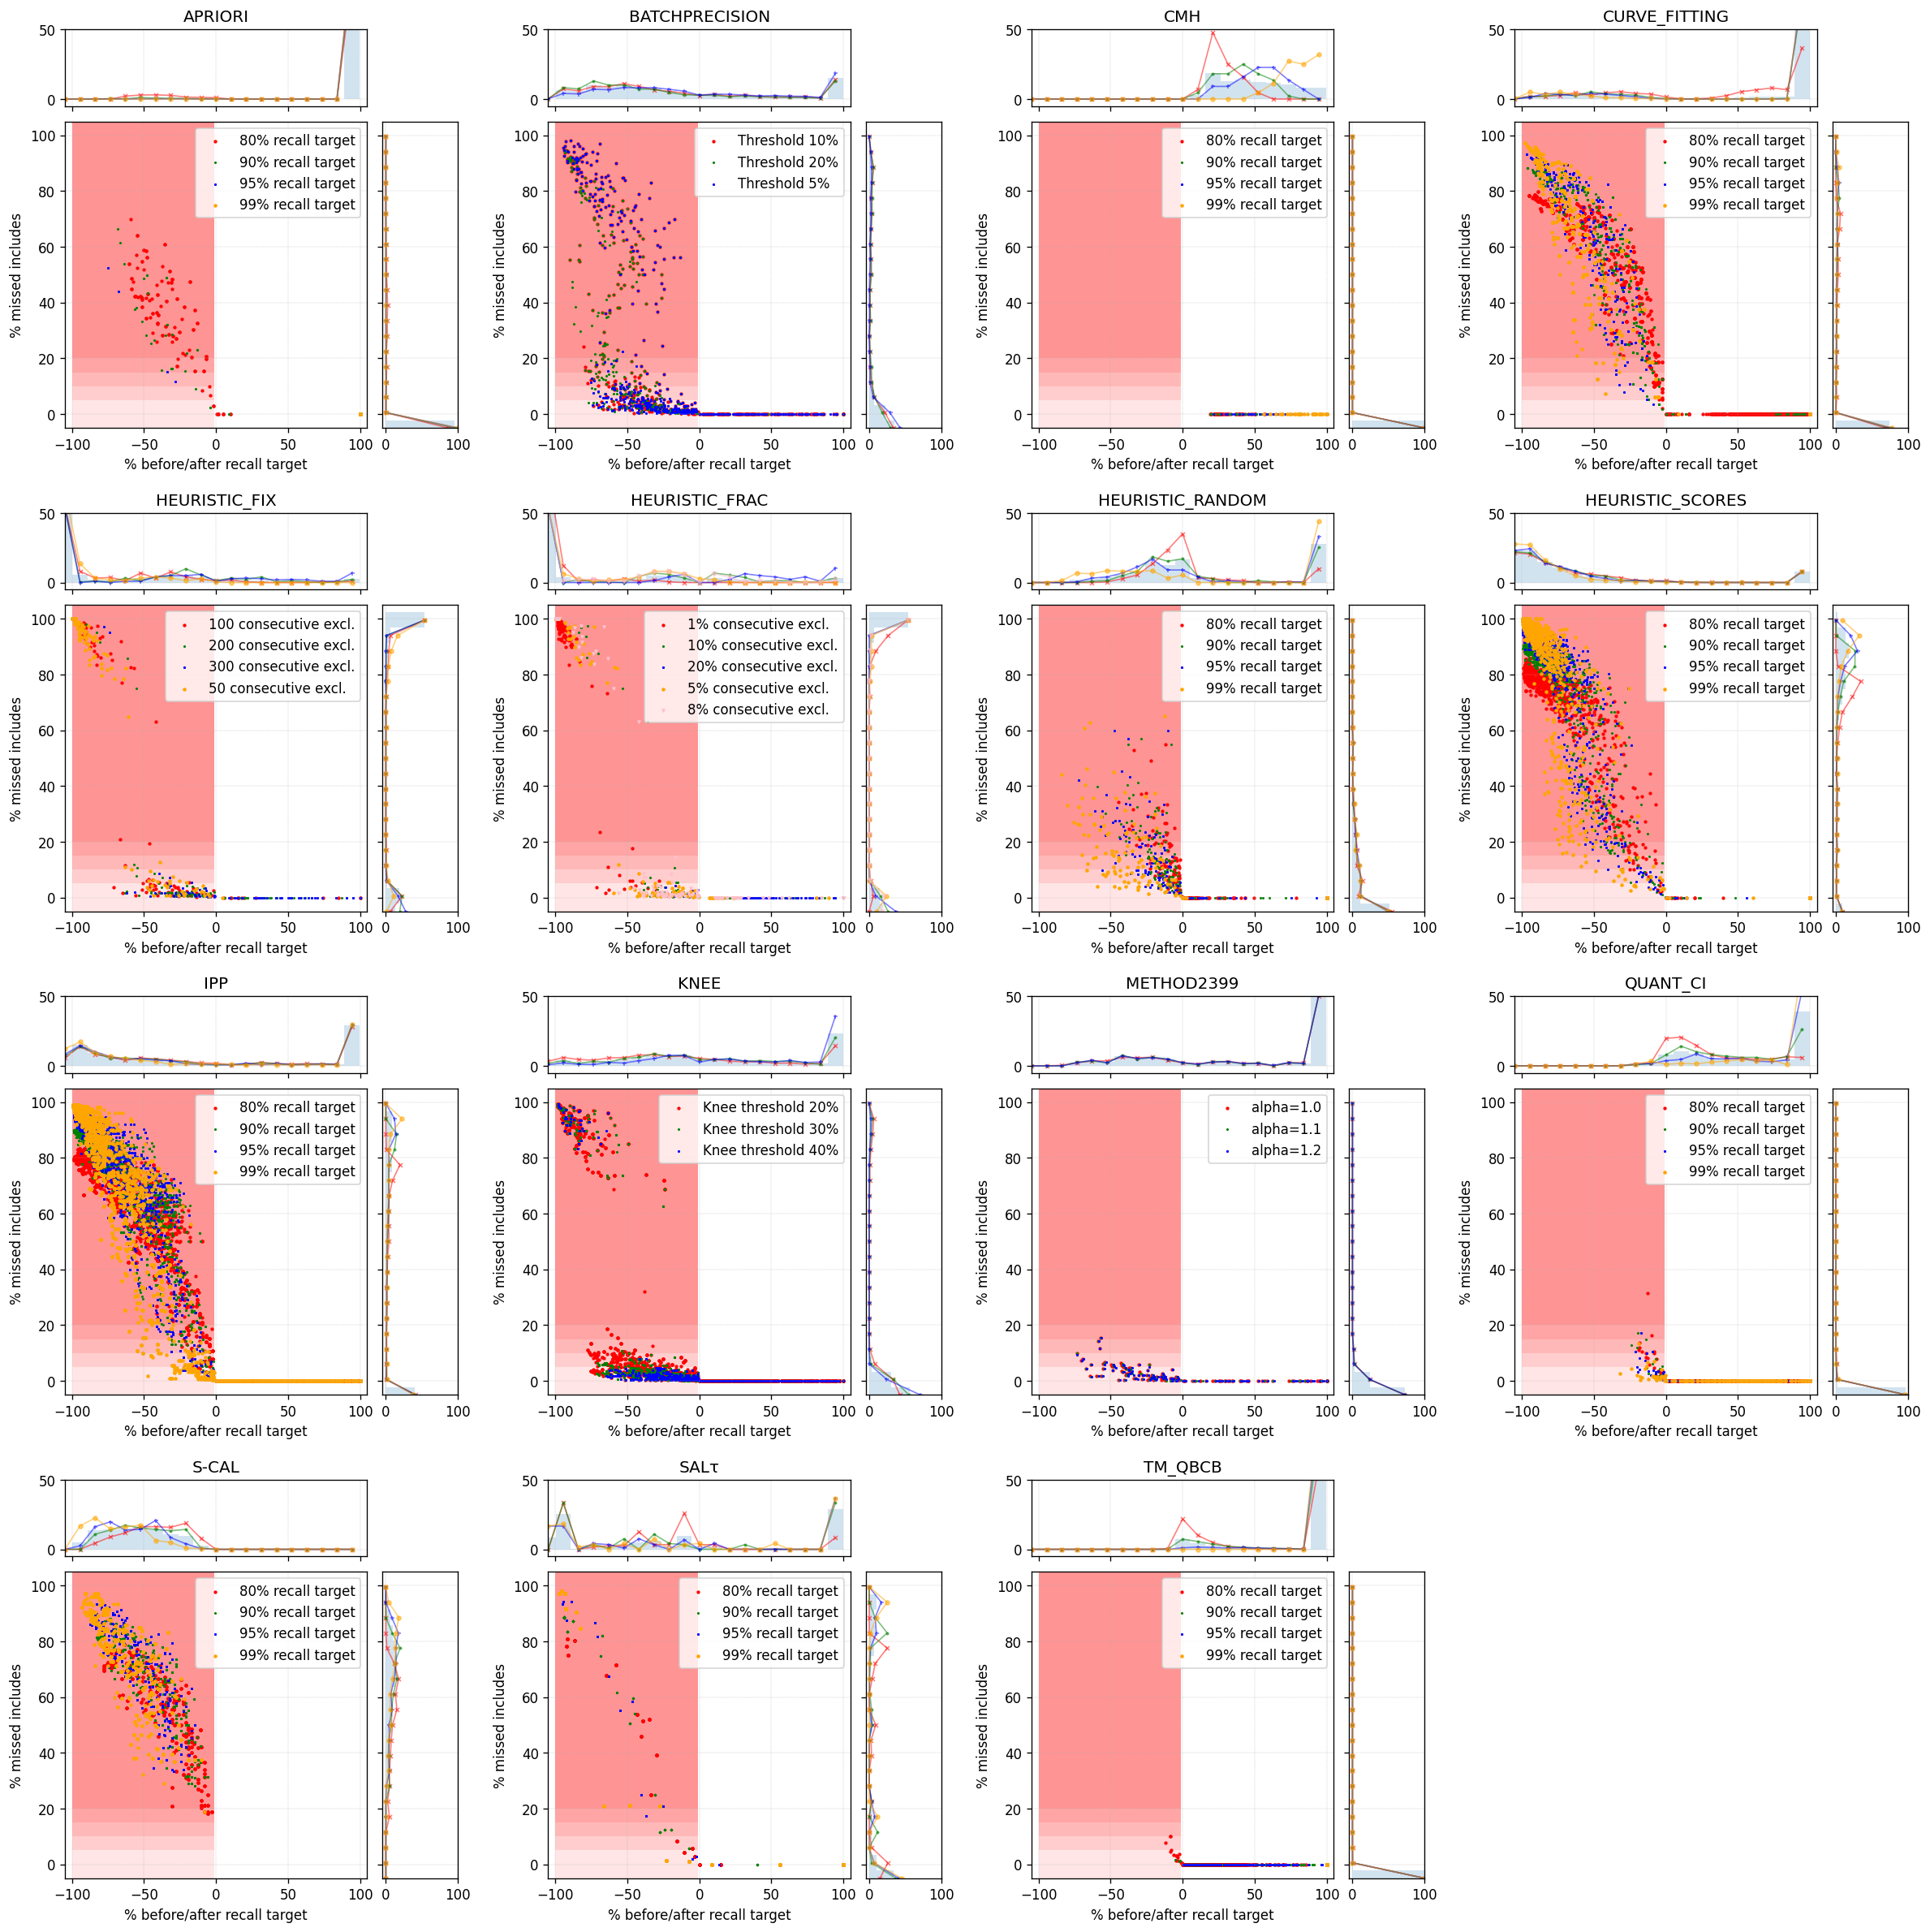

In [24]:
fig, _, _, _ = scattered(
    xval=lambda x: f'tetl_right@recall={x}', xlab='% before/after recall target', xlim=(-105, 105),
    yval=lambda x: f'missed_%@recall={x}', ylab='% missed includes', ylim=(-5, 105),
    vred=True, hred=False,
    fname='../data/plots/scatter2.pdf',
)

## Scatter 3 (recall when stopped vs work savings)

APRIORI
BATCHPRECISION
CMH
CURVE_FITTING
HEURISTIC_FIX
HEURISTIC_FRAC
HEURISTIC_RANDOM
HEURISTIC_SCORES
IPP
KNEE
METHOD2399
QUANT_CI
S-CAL
SALτ
TM_QBCB
(71291, 7)
4 4
APRIORI (3568, 7)
BATCHPRECISION (2007, 7)
CMH (176, 7)
CURVE_FITTING (11904, 7)
HEURISTIC_FIX (892, 7)
HEURISTIC_FRAC (1115, 7)
HEURISTIC_RANDOM (892, 7)
HEURISTIC_SCORES (3568, 7)
IPP (17840, 7)
KNEE (8028, 7)
METHOD2399 (669, 7)
QUANT_CI (2676, 7)
S-CAL (2436, 7)
SALτ (1920, 7)
TM_QBCB (13600, 7)
dropping axis 3,3
\rot{APRIORI} & \rot{BATCHPRECISION} & \rot{CMH} & \rot{CURVE\_FITTING} & \rot{HEURISTIC\_FIX} & \rot{HEURISTIC\_FRAC} & \rot{HEURISTIC\_RANDOM} & \rot{HEURISTIC\_SCORES} & \rot{IPP} & \rot{KNEE} & \rot{METHOD2399} & \rot{QUANT\_CI} & \rot{S-CAL} & \rot{SALτ} & \rot{TM\_QBCB} & \rot{Work saved}
\begin{tabular}{rrrrrrrrrrrrrrrr}
\toprule
APRIORI & BATCHPRECISION & CMH & CURVE_FITTING & HEURISTIC_FIX & HEURISTIC_FRAC & HEURISTIC_RANDOM & HEURISTIC_SCORES & IPP & KNEE & METHOD2399 & QUANT_CI & S-CAL & SALτ & TM_

\begin{tabular}{rrrrrrrrrrrrrrrr}
\toprule
APRIORI & BATCHPRECISION & CMH & CURVE_FITTING & HEURISTIC_FIX & HEURISTIC_FRAC & HEURISTIC_RANDOM & HEURISTIC_SCORES & IPP & KNEE & METHOD2399 & QUANT_CI & S-CAL & SALτ & TM_QBCB & Recall when stopped \\
\midrule
0.0 & 0.0 & 0.0 & 0.0 & 0.0 & 0.0 & 0.0 & 0.0 & 0.0 & 0.0 & 0.0 & 0.0 & 0.0 & 0.0 & 0.0 & -10 \\
0.0 & 0.1 & 0.0 & 0.1 & 55.9 & 55.7 & 0.0 & 23.7 & 12.1 & 1.3 & 0.0 & 0.0 & 0.5 & 16.7 & 0.0 & -3 \\
0.0 & 3.4 & 0.0 & 3.5 & 5.6 & 6.5 & 0.0 & 30.7 & 15.1 & 4.4 & 0.0 & 0.0 & 10.3 & 8.3 & 0.0 & 2 \\
0.0 & 5.2 & 0.0 & 4.8 & 2.4 & 1.8 & 0.0 & 11.2 & 4.7 & 2.5 & 0.0 & 0.0 & 18.2 & 10.2 & 0.0 & 8 \\
0.1 & 4.1 & 0.0 & 2.3 & 1.3 & 0.9 & 0.0 & 6.4 & 5.1 & 1.1 & 0.0 & 0.0 & 15.2 & 1.7 & 0.0 & 14 \\
0.3 & 3.5 & 0.0 & 2.5 & 0.6 & 0.4 & 0.0 & 2.5 & 3.5 & 0.2 & 0.0 & 0.0 & 14.2 & 0.0 & 0.0 & 20 \\
0.3 & 3.1 & 0.0 & 2.6 & 0.0 & 0.1 & 0.3 & 2.0 & 4.4 & 0.4 & 0.0 & 0.0 & 10.5 & 3.5 & 0.0 & 26 \\
0.5 & 2.0 & 0.0 & 2.4 & 0.2 & 0.2 & 0.8 & 1.1 & 3.5 & 0.0 

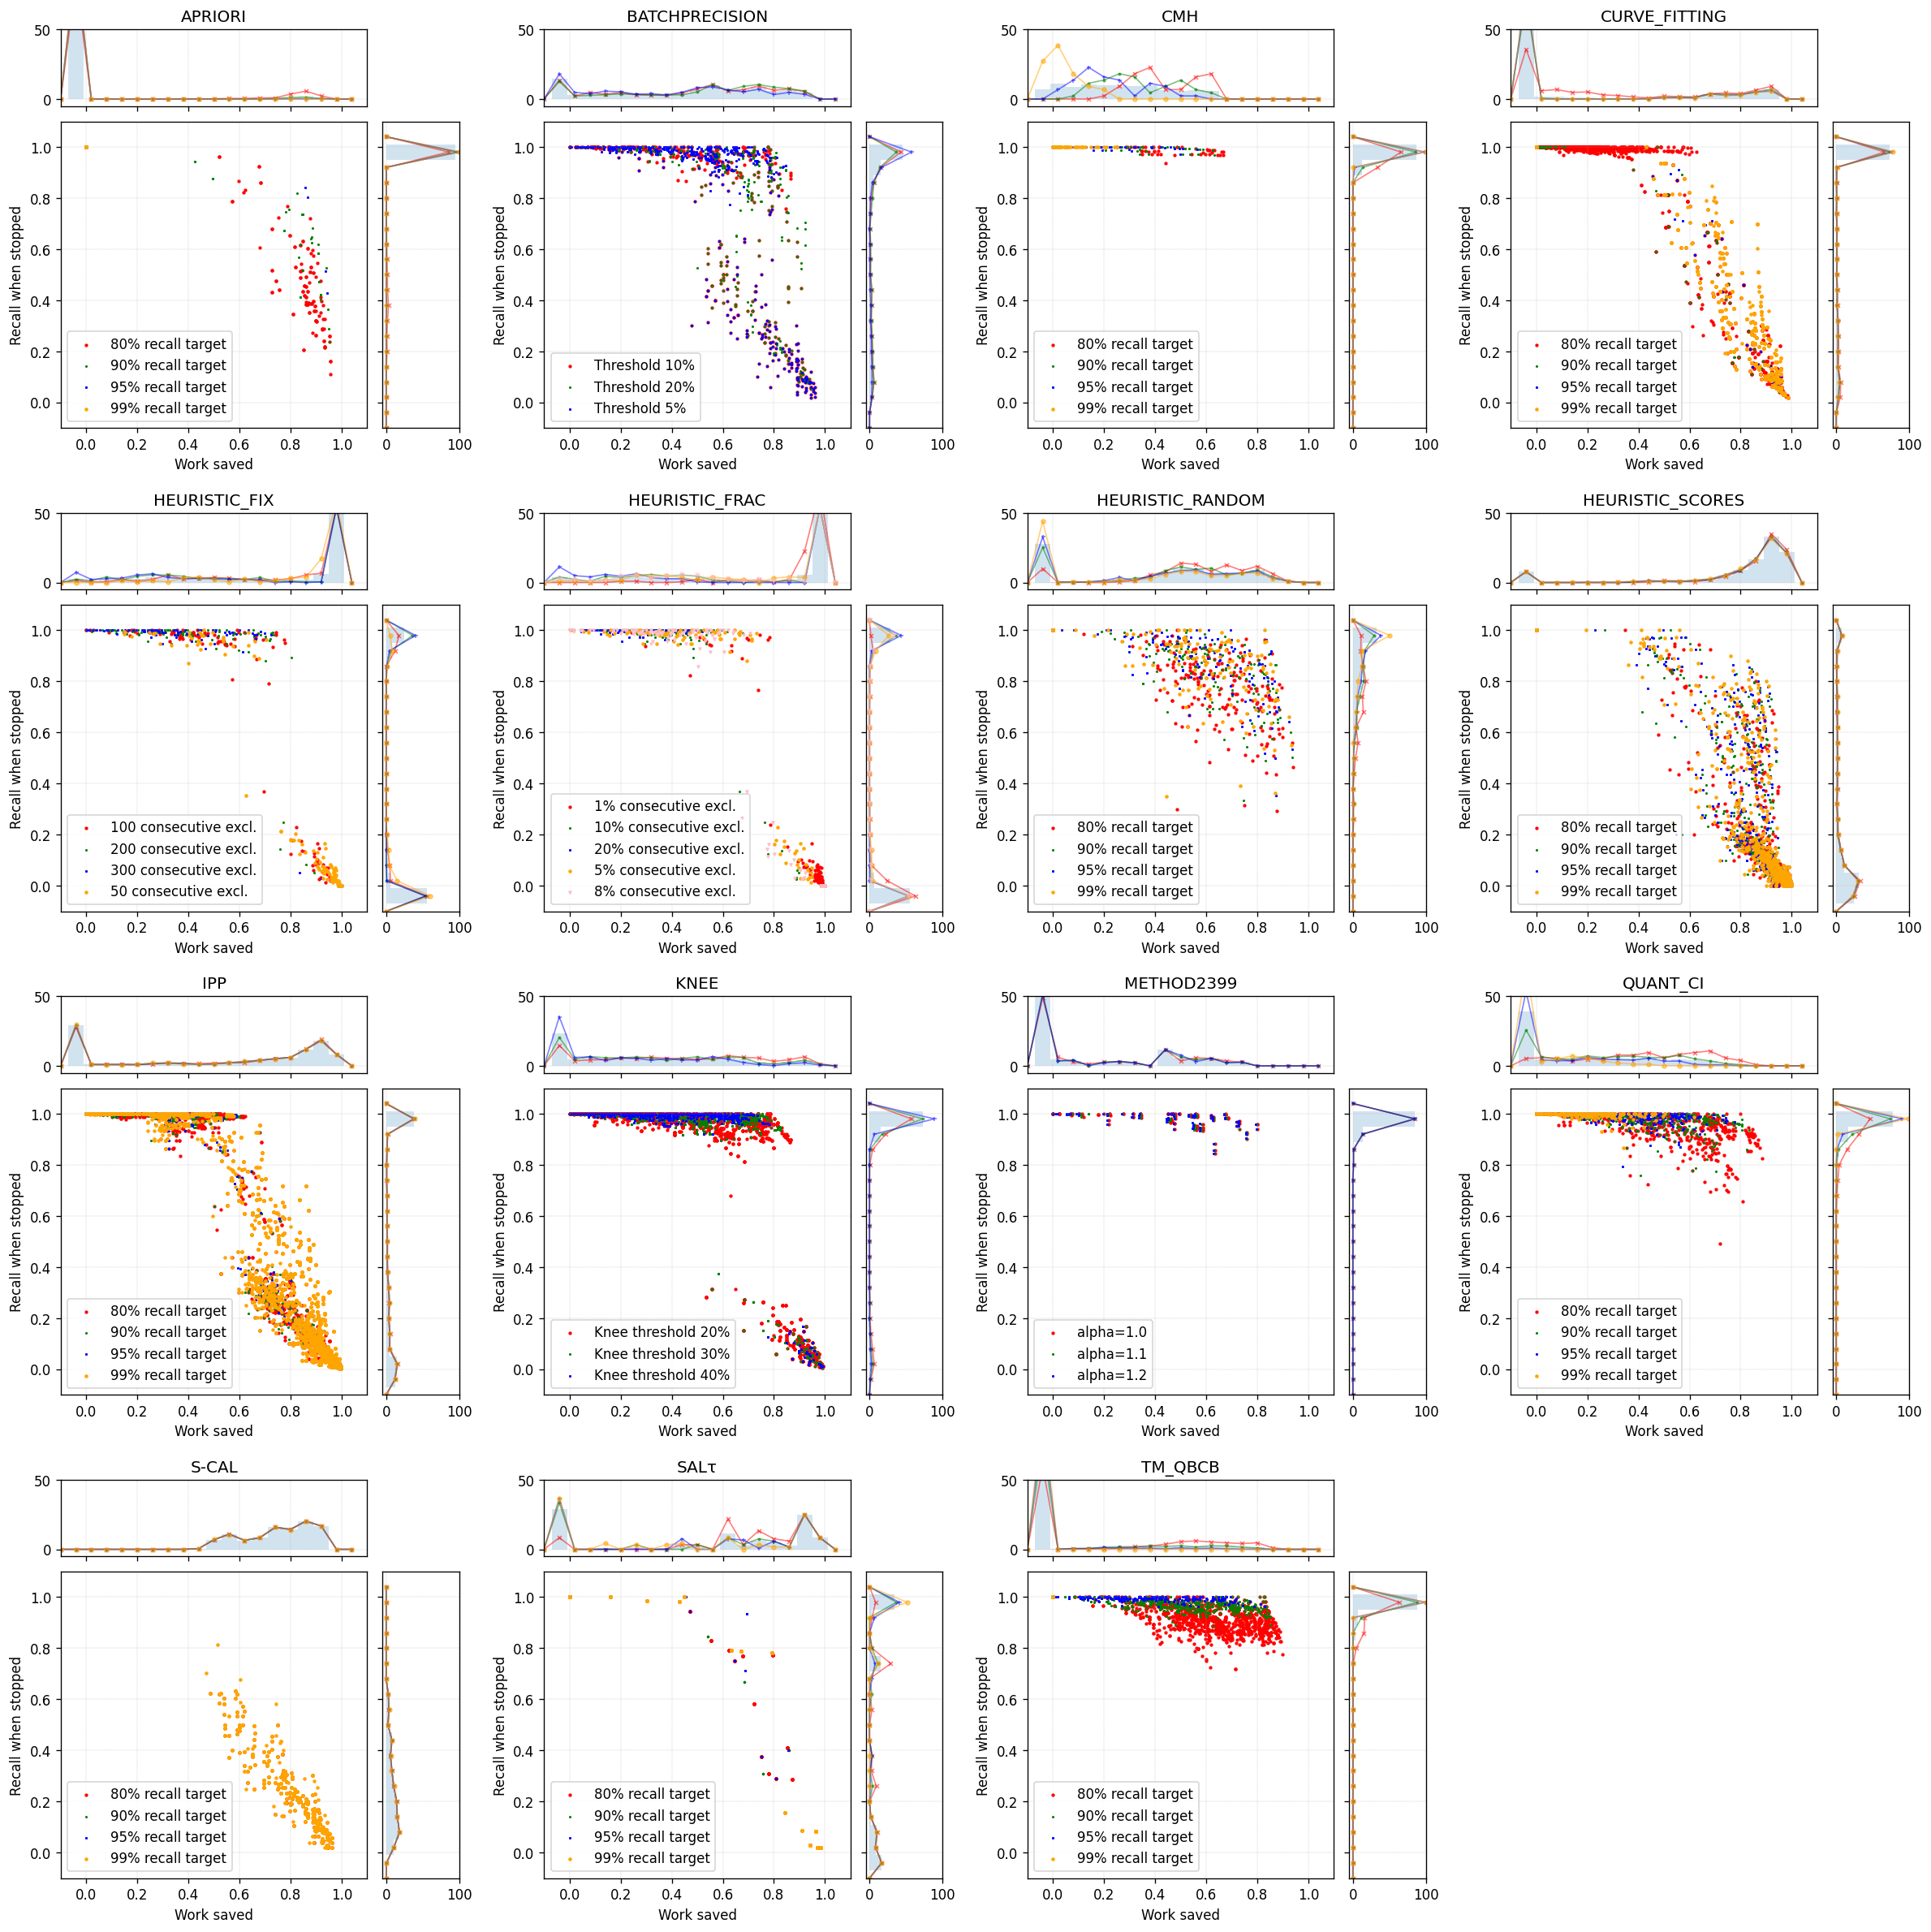

In [158]:
fig, _, _, _ = scattered(
    xval=lambda x: f'work_saved', xlab='Work saved', xlim=(-0.1, 1.1),
    yval=lambda x: f'stop_recall', ylab='Recall when stopped', ylim=(-0.1, 1.1),
    vred=False, hred=False,
    fname='../data/plots/scatter3.pdf',
    scalex=100,scaley=100,
)

# Where did it fail

In [152]:
df_res[(df_res['method']=='CMH')&(df_res['tetl_right']<0)]#.groupby(['dataset', 'method-recall_target','method-confidence_level']).count()

Empty DataFrame
Columns: [dataset, sim-rep, sim_key, batch_i, n_total, n_seen, n_unseen, n_incl, n_incl_seen, n_incl_batch, n_records_batch, method, safe_to_stop, method-hash, method-KEY, method-safe_to_stop, method-score, method-confidence_level, method-recall_target, method-bias, method-est_incl, method-inclusion_threshold, method-batch_size, method-threshold, method-current_precision, method-window_size, method-polyorder, method-threshold_ratio, method-threshold_peak, method-slope_ratio, method-smoothing, method-num_to_stop, method-fraction, method-sample_size, method-n_windows, method-est_recall, method-expected_includes, method-curve_estimate, method-nstd, method-est_var, method-alpha, method-constant, method-num_reviewed, method-num_relevant_reviewed, method-use_adjusted, method-use_margin, method-margin_recall, method-positive_sample_size, method-required_overlap, method-n_overlap, method-n_sample, seen@recall=0.8, unseen@recall=0.8, seen_incl@recall=0.8, too_late@recall=0.8, too_late_left%@recall=0.8, too_late_right%@recall=0.8, too_early@recall=0.8, too_early%@recall=0.8, missed@recall=0.8, missed%@recall=0.8, seen@recall=0.85, unseen@recall=0.85, seen_incl@recall=0.85, too_late@recall=0.85, too_late_left%@recall=0.85, too_late_right%@recall=0.85, too_early@recall=0.85, too_early%@recall=0.85, missed@recall=0.85, missed%@recall=0.85, seen@recall=0.9, unseen@recall=0.9, seen_incl@recall=0.9, too_late@recall=0.9, too_late_left%@recall=0.9, too_late_right%@recall=0.9, too_early@recall=0.9, too_early%@recall=0.9, missed@recall=0.9, missed%@recall=0.9, seen@recall=0.95, unseen@recall=0.95, seen_incl@recall=0.95, too_late@recall=0.95, too_late_left%@recall=0.95, too_late_right%@recall=0.95, too_early@recall=0.95, too_early%@recall=0.95, missed@recall=0.95, missed%@recall=0.95, seen@recall=0.99, unseen@recall=0.99, seen_incl@recall=0.99, too_late@recall=0.99, too_late_left%@recall=0.99, too_late_right%@recall=0.99, too_early@recall=0.99, too_early%@recall=0.99, missed@recall=0.99, ...]
Index: []

In [154]:
pd.options.display.max_columns = 650
pd.options.display.max_rows = 100
df_res[(df_res['method']=='TM_QBCB')&(df_res['tetl_right']<0)]#.groupby(['dataset', 'method-recall_target','method-confidence_level']).count()

dataset  sim-rep  \
17343                               clef-CD009579        2   
37211                               clef-CD012069        3   
40175                               clef-CD012599        3   
56589               generic-paired-ris-Heart 1312        1   
57436               generic-paired-ris-Heart 1406        2   
57500               generic-paired-ris-Heart 1406        2   
57509               generic-paired-ris-Heart 1406        2   
61890        generic-paired-ris-NICE Ian Saunders        1   
61899        generic-paired-ris-NICE Ian Saunders        1   
62397        generic-paired-ris-NICE Ian Saunders        3   
62412        generic-paired-ris-NICE Ian Saunders        3   
62431        generic-paired-ris-NICE Ian Saunders        3   
62444        generic-paired-ris-NICE Ian Saunders        3   
62451        generic-paired-ris-NICE Ian Saunders        3   
62453        generic-paired-ris-NICE Ian Saunders        3   
62454        generic-paired-ris-NICE Ian Saunders        3   
62461        generic-paired-ris-NICE Ian Saunders        3   
62470        generic-paired-ris-NICE Ian Saunders        3   
65128               generic-paired-ris-automation        3   
65141               generic-paired-ris-automation        3   
70920  generic-paired-ris-shareddecisionmaking1.3        2   

                                                 sim_key  batch_i  n_total  \
17343                         clef-CD009579-0-500-2-best       51     4795   
37211                         clef-CD012069-0-500-3-best       85     2903   
40175                         clef-CD012599-0-500-3-best      163     6617   
56589         generic-paired-ris-Heart 1312-0-500-1-best       93     3873   
57436         generic-paired-ris-Heart 1406-0-500-2-best       43     2315   
57500         generic-paired-ris-Heart 1406-0-500-2-best       46     2315   
57509         generic-paired-ris-Heart 1406-0-500-2-best       43     2315   
61890  generic-paired-ris-NICE Ian Saunders-0-500-1-best      140     5288   
61899  generic-paired-ris-NICE Ian Saunders-0-500-1-best      151     5288   
62397  generic-paired-ris-NICE Ian Saunders-0-500-3-best      151     5288   
62412  generic-paired-ris-NICE Ian Saunders-0-500-3-best      151     5288   
62431  generic-paired-ris-NICE Ian Saunders-0-500-3-best      151     5288   
62444  generic-paired-ris-NICE Ian Saunders-0-500-3-best      140     5288   
62451  generic-paired-ris-NICE Ian Saunders-0-500-3-best      182     5288   
62453  generic-paired-ris-NICE Ian Saunders-0-500-3-best      145     5288   
62454  generic-paired-ris-NICE Ian Saunders-0-500-3-best      151     5288   
62461  generic-paired-ris-NICE Ian Saunders-0-500-3-best      134     5288   
62470  generic-paired-ris-NICE Ian Saunders-0-500-3-best      151     5288   
65128         generic-paired-ris-automation-0-500-3-best      129    13095   
65141         generic-paired-ris-automation-0-500-3-best       87    13095   
70920  generic-paired-ris-shareddecisionmaking1.3-0-5...       82     9124   

       n_seen  n_unseen  n_incl  n_incl_seen  n_incl_batch  n_records_batch  \
17343     781      4014     128          100             1               15   
37211    1293      1610     283          223             1               15   
40175    2460      4157     527          467             1               15   
56589    1411      2462     129          101             1               15   
57436     661      1654     110           79             4               15   
57500     706      1609     110           86             1               15   
57509     661      1654     110           79             4               15   
61890    2118      3170    1957         1483            12               15   
61899    2283      3005    1957         1559             4               15   
62397    2283      3005    1957         1560             4               15   
62412    2283      3005    1957         1560             4               15   
62431    228

# Regression analysis of parameter impact

In [26]:
params = [
    # method parameters
    'method-recall_target', 
    'method-confidence_level',
    #'method-bias', 
    #'method-positive_sample_size',
    #'method-nstd',
    
    # dataset characteristics
    'n_total', 'incl_rate', 
    
    # stopping performance
    'additional_work', 'work_saved', 'stop_recall', 'incl_missed', 
    
    # reference metric
    'tetl_right@recall=1.0', 'tetl_right@recall=0.95', 'tetl_right@recall=0.8',
]

In [27]:
print(list(df_res.columns))

['dataset', 'sim-rep', 'sim_key', 'batch_i', 'n_total', 'n_seen', 'n_unseen', 'n_incl', 'n_incl_seen', 'n_incl_batch', 'n_records_batch', 'method', 'safe_to_stop', 'method-hash', 'method-KEY', 'method-safe_to_stop', 'method-score', 'method-confidence_level', 'method-recall_target', 'method-bias', 'method-est_incl', 'method-inclusion_threshold', 'method-batch_size', 'method-threshold', 'method-current_precision', 'method-window_size', 'method-polyorder', 'method-threshold_ratio', 'method-threshold_peak', 'method-slope_ratio', 'method-smoothing', 'method-num_to_stop', 'method-fraction', 'method-sample_size', 'method-n_windows', 'method-est_recall', 'method-expected_includes', 'method-curve_estimate', 'method-nstd', 'method-est_var', 'method-alpha', 'method-constant', 'method-num_reviewed', 'method-num_relevant_reviewed', 'method-use_adjusted', 'method-use_margin', 'method-margin_recall', 'method-positive_sample_size', 'method-required_overlap', 'method-n_overlap', 'method-n_sample', 'see

In [28]:
for rt in RECALL_TARGETS:
    df_res.loc[df_res['method-recall_target']==rt, 'tetl_right'] = df_res[df_res['method-recall_target']==rt][f'tetl_right@recall={rt}']

In [206]:
def regress(px: str, py: str, pz: list[str], dfr_fltr: pd.DataFrame, lx:str, ly:str, lz:list[str], fname:str, ylim: tuple[float,float]=None):
    fig, axes = plt.subplots(1, len(pz)+1, figsize=(5*(len(pz)+1), 3), dpi=120)

    for ax in axes:
        sns.scatterplot(data=dfr_fltr, x=px, y=py,  s=5, ax=ax)
        sns.rugplot(data=dfr_fltr, x=px, y=py, lw=1, alpha=.05, ax=ax)
        ax.set_xlabel(lx)
        ax.set_ylabel(ly)
    
    sns.regplot(data=dfr_fltr, x=px, y=py, scatter=False, line_kws={'color': 'r'}, ci=95, order=1, ax=axes[0])
    if ylim is not None:
        axes[0].set_ylim(*ylim)

    for i, (pzi, lzi) in enumerate(zip(pz, lz), 1):
        display(Markdown(f'''### {lzi}'''))
        
        display(dfr_fltr.groupby([px, pzi])[py].describe())
        display(dfr_fltr.groupby(pzi)[py].describe())
        
        sns.kdeplot(data=dfr_fltr, x=px, y=py, hue=pzi, levels=2, thresh=0.2, warn_singular=False, ax=axes[i])
        sns.move_legend(axes[i], "upper left", bbox_to_anchor=(1, 1), ncol=4)
        axes[i].get_legend().set_title(lzi)
        if ylim is not None:
            axes[i].set_ylim(*ylim)
    
    display(Markdown(f'''### Correlations'''))
    display(dfr_fltr[list(set([px,py]+pz)-set(['method-smoothing']))].corr())
    
    fig.tight_layout()
    fig.show()
    fig.savefig(f'{fname}_base.pdf')

    for i, (pzi, lzi) in enumerate(zip(pz, lz), 1):
        fig, ax = plt.subplots(1, 1, figsize=(5, 4), dpi=120)
        sns.boxplot(data=dfr_fltr, x=px, y=py, hue=pzi, ax=ax)
        #sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
        sns.move_legend(ax, "lower center", bbox_to_anchor=(.5, 0), ncol=5, fontsize=8)
        sns.rugplot(data=dfr_fltr, y=py,  lw=1, alpha=.05, ax=ax)
        if ylim is not None:
            ax.set_ylim(*ylim)
        ax.set_xlabel(lx)
        ax.set_ylabel(ly)
        ax.get_legend().set_title(lzi)
        fig.show()
        fig.savefig(f'{fname}_{pzi}.pdf')

## scal

### Recall target

count     mean       std      min      25%  \
tetl_right method-recall_target                                               
-93.227991 0.99                    3.0  10787.0  0.000000  10787.0  10787.0   
-91.963442 0.99                    3.0  10787.0  0.000000  10787.0  10787.0   
-91.405460 0.99                    3.0   7016.0  0.000000   7016.0   7016.0   
-91.350068 0.99                    3.0  10787.0  0.000000  10787.0  10787.0   
-90.735695 0.99                    2.0  13095.0  0.000000  13095.0  13095.0   
...                                ...      ...       ...      ...      ...   
-5.524862  0.80                    3.0   1328.0  0.000000   1328.0   1328.0   
-5.514706  0.80                    6.0   1247.5  8.215838   1240.0   1240.0   
-5.494505  0.80                    3.0   1093.0  0.000000   1093.0   1093.0   
           0.90                    3.0   1093.0  0.000000   1093.0   1093.0   
-2.824859  0.80                    3.0   1093.0  0.000000   1093.0   1093.0   

                                     50%      75%      max  
tetl_right method-recall_target                             
-93.227991 0.99                  10787.0  10787.0  10787.0  
-91.963442 0.99                  10787.0  10787.0  10787.0  
-91.405460 0.99                   7016.0   7016.0   7016.0  
-91.350068 0.99                  10787.0  10787.0  10787.0  
-90.735695 0.99                  13095.0  13095.0  13095.0  
...                                  ...      ...      ...  
-5.524862  0.80                   1328.0   1328.0   1328.0  
-5.514706  0.80                   1247.5   1255.0   1255.0  
-5.494505  0.80                   1093.0   1093.0   1093.0  
           0.90                   1093.0   1093.0   1093.0  
-2.824859  0.80                   1093.0   1093.0   1093.0  

[743 rows x 8 columns]

count         mean          std     min     25%     50%  \
method-recall_target                                                            
0.80                  609.0  3658.206897  2633.496341  1000.0  1665.0  2602.0   
0.90                  609.0  3658.206897  2633.496341  1000.0  1665.0  2602.0   
0.95                  609.0  3658.206897  2633.496341  1000.0  1665.0  2602.0   
0.99                  609.0  3658.206897  2633.496341  1000.0  1665.0  2602.0   

                         75%      max  
method-recall_target                   
0.80                  4862.0  13095.0  
0.90                  4862.0  13095.0  
0.95                  4862.0  13095.0  
0.99                  4862.0  13095.0

### Sample size

count     mean  std      min      25%      50%  \
tetl_right method-sample_size                                                   
-93.227991 0.5                   1.0  10787.0  NaN  10787.0  10787.0  10787.0   
           0.8                   1.0  10787.0  NaN  10787.0  10787.0  10787.0   
           0.9                   1.0  10787.0  NaN  10787.0  10787.0  10787.0   
-91.963442 0.5                   1.0  10787.0  NaN  10787.0  10787.0  10787.0   
           0.8                   1.0  10787.0  NaN  10787.0  10787.0  10787.0   
...                              ...      ...  ...      ...      ...      ...   
-5.494505  0.8                   2.0   1093.0  0.0   1093.0   1093.0   1093.0   
           0.9                   2.0   1093.0  0.0   1093.0   1093.0   1093.0   
-2.824859  0.5                   1.0   1093.0  NaN   1093.0   1093.0   1093.0   
           0.8                   1.0   1093.0  NaN   1093.0   1093.0   1093.0   
           0.9                   1.0   1093.0  NaN   1093.0   1093.0   1093.0   

                                   75%      max  
tetl_right method-sample_size                    
-93.227991 0.5                 10787.0  10787.0  
           0.8                 10787.0  10787.0  
           0.9                 10787.0  10787.0  
-91.963442 0.5                 10787.0  10787.0  
           0.8                 10787.0  10787.0  
...                                ...      ...  
-5.494505  0.8                  1093.0   1093.0  
           0.9                  1093.0   1093.0  
-2.824859  0.5                  1093.0   1093.0  
           0.8                  1093.0   1093.0  
           0.9                  1093.0   1093.0  

[1619 rows x 8 columns]

count         mean          std     min     25%     50%  \
method-sample_size                                                            
0.5                 812.0  3658.206897  2632.955082  1000.0  1665.0  2602.0   
0.8                 812.0  3658.206897  2632.955082  1000.0  1665.0  2602.0   
0.9                 812.0  3658.206897  2632.955082  1000.0  1665.0  2602.0   

                       75%      max  
method-sample_size                   
0.5                 4862.0  13095.0  
0.8                 4862.0  13095.0  
0.9                 4862.0  13095.0

### bias

count     mean       std      min      25%      50%  \
tetl_right method-bias                                                        
-93.227991 1.0            3.0  10787.0  0.000000  10787.0  10787.0  10787.0   
-91.963442 1.0            3.0  10787.0  0.000000  10787.0  10787.0  10787.0   
-91.405460 1.0            3.0   7016.0  0.000000   7016.0   7016.0   7016.0   
-91.350068 1.0            3.0  10787.0  0.000000  10787.0  10787.0  10787.0   
-90.735695 1.0            2.0  13095.0  0.000000  13095.0  13095.0  13095.0   
...                       ...      ...       ...      ...      ...      ...   
-7.812500  1.0            1.0   1093.0       NaN   1093.0   1093.0   1093.0   
-5.524862  1.0            3.0   1328.0  0.000000   1328.0   1328.0   1328.0   
-5.514706  1.0            6.0   1247.5  8.215838   1240.0   1240.0   1247.5   
-5.494505  1.0            6.0   1093.0  0.000000   1093.0   1093.0   1093.0   
-2.824859  1.0            3.0   1093.0  0.000000   1093.0   1093.0   1093.0   

                            75%      max  
tetl_right method-bias                    
-93.227991 1.0          10787.0  10787.0  
-91.963442 1.0          10787.0  10787.0  
-91.405460 1.0           7016.0   7016.0  
-91.350068 1.0          10787.0  10787.0  
-90.735695 1.0          13095.0  13095.0  
...                         ...      ...  
-7.812500  1.0           1093.0   1093.0  
-5.524862  1.0           1328.0   1328.0  
-5.514706  1.0           1255.0   1255.0  
-5.494505  1.0           1093.0   1093.0  
-2.824859  1.0           1093.0   1093.0  

[587 rows x 8 columns]

count         mean          std     min     25%     50%     75%  \
method-bias                                                                     
1.0          2436.0  3658.206897  2631.873564  1000.0  1665.0  2602.0  4862.0   

                 max  
method-bias           
1.0          13095.0

### Correlations

n_total  method-bias  method-recall_target  \
n_total               1.000000e+00          NaN          3.045667e-16   
method-bias                    NaN          NaN                   NaN   
method-recall_target  3.045667e-16          NaN          1.000000e+00   
tetl_right           -6.726782e-01          NaN         -4.201008e-01   
method-sample_size    1.507855e-16          NaN          6.382191e-18   

                      tetl_right  method-sample_size  
n_total                -0.672678        1.507855e-16  
method-bias                  NaN                 NaN  
method-recall_target   -0.420101        6.382191e-18  
tetl_right              1.000000        1.216462e-03  
method-sample_size      0.001216        1.000000e+00

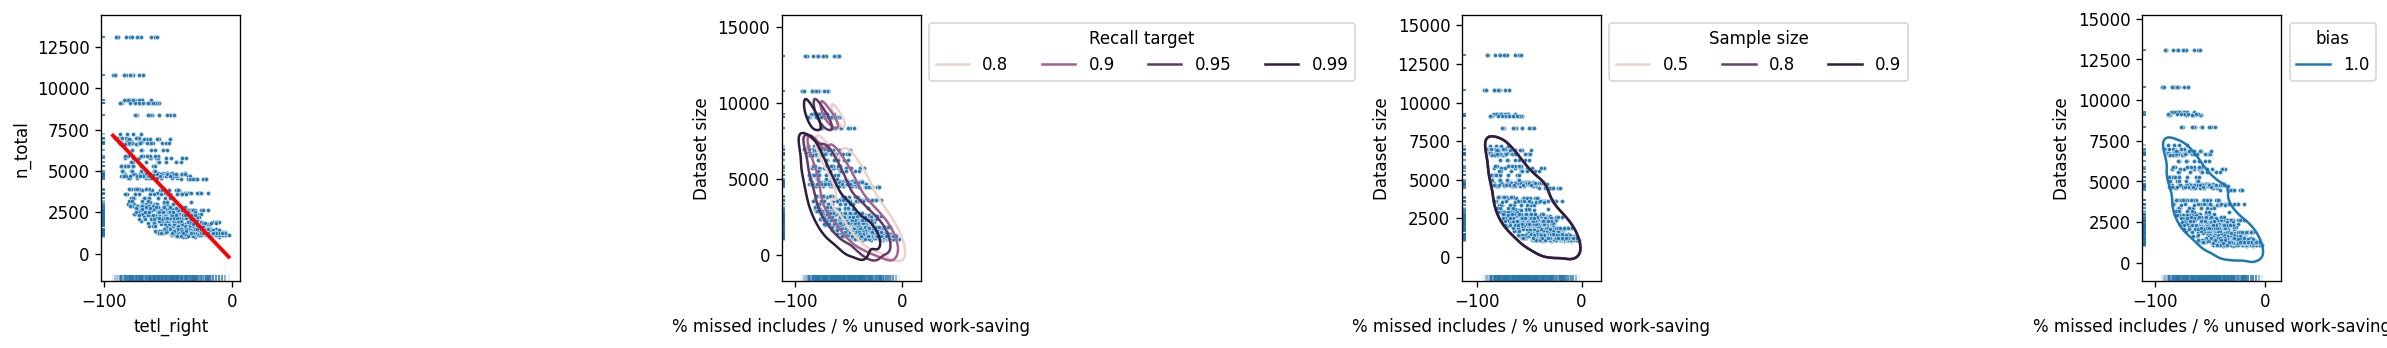

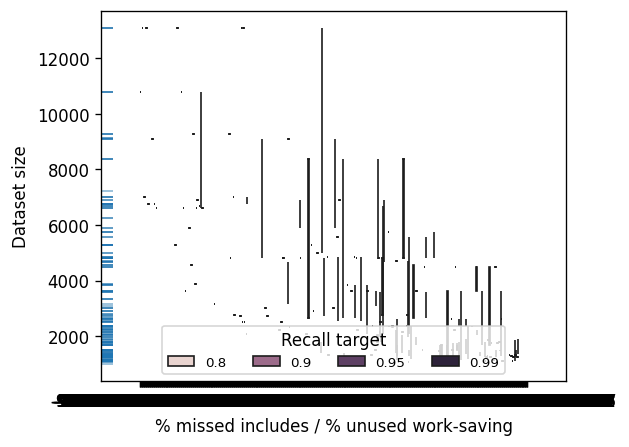

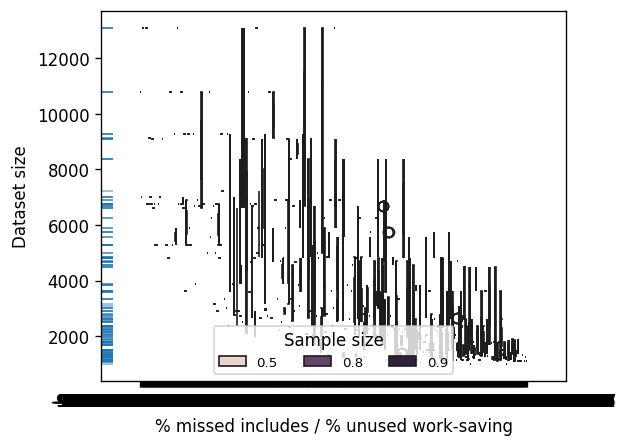

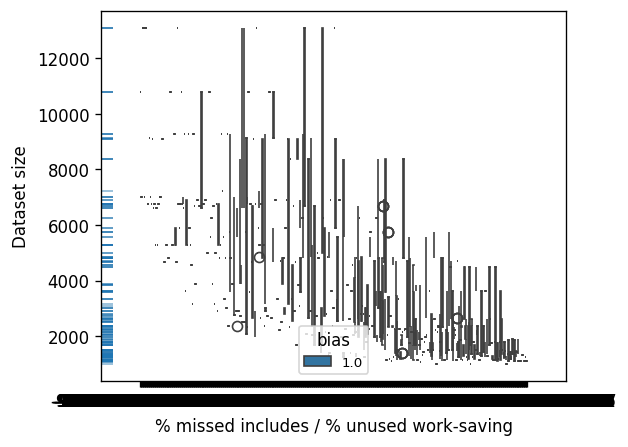

In [210]:
regress(
    dfr_fltr=df_res[(df_res['method']=='S-CAL')],
    py = 'n_total',
    px = 'tetl_right',
    pz = ['method-recall_target', 'method-sample_size', 'method-bias'],
    ly='Dataset size',
    lx='% missed includes / % unused work-saving',
    lz=['Recall target', 'Sample size',  'bias'],
    fname='../data/plots/regress_scal',
    #ylim=(-105, 105),
)

## Knee

### WS

count         mean          std  \
tetl_right@recall=0.85 method-window_size                                    
-95.983168             50.0                  6.0  7016.000000     0.000000   
-95.973154             50.0                  4.0  6617.000000     0.000000   
-94.498778             50.0                  4.0  3873.000000     0.000000   
-93.808050             50.0                 12.0  6746.000000     0.000000   
-93.437044             50.0                  2.0  6743.000000     0.000000   
...                                          ...          ...          ...   
 98.614215             1000.0                3.0  3873.000000     0.000000   
 98.766384             1000.0                4.0  2155.000000     0.000000   
 100.000000            50.0                288.0  2280.736111  1649.648861   
                       500.0               556.0  1956.316547  1504.203942   
                       1000.0              971.0  1759.849640  1156.976639   

                                              min     25%     50%     75%  \
tetl_right@recall=0.85 method-window_size                                   
-95.983168             50.0                7016.0  7016.0  7016.0  7016.0   
-95.973154             50.0                6617.0  6617.0  6617.0  6617.0   
-94.498778             50.0                3873.0  3873.0  3873.0  3873.0   
-93.808050             50.0                6746.0  6746.0  6746.0  6746.0   
-93.437044             50.0                6743.0  6743.0  6743.0  6743.0   
...                                           ...     ...     ...     ...   
 98.614215             1000.0              3873.0  3873.0  3873.0  3873.0   
 98.766384             1000.0              2155.0  2155.0  2155.0  2155.0   
 100.000000            50.0                1000.0  1123.0  1390.0  2903.0   
                       500.0               1000.0  1155.0  1328.0  1921.0   
                       1000.0              1000.0  1240.0  1390.0  1685.0   

                                              max  
tetl_right@recall=0.85 method-window_size          
-95.983168             50.0                7016.0  
-95.973154             50.0                6617.0  
-94.498778             50.0                3873.0  
-93.808050             50.0                6746.0  
-93.437044             50.0                6743.0  
...                                           ...  
 98.614215             1000.0              3873.0  
 98.766384             1000.0              2155.0  
 100.000000            50.0                7016.0  
                       500.0               7016.0  
                       1000.0              7016.0  

[2068 rows x 8 columns]

count        mean          std     min     25%     50%  \
method-window_size                                                            
50.0                2676.0  3601.64574  2589.739616  1000.0  1507.0  2602.0   
500.0               2676.0  3601.64574  2589.739616  1000.0  1507.0  2602.0   
1000.0              2676.0  3601.64574  2589.739616  1000.0  1507.0  2602.0   

                       75%      max  
method-window_size                   
50.0                4862.0  13095.0  
500.0               4862.0  13095.0  
1000.0              4862.0  13095.0

### ratio

count         mean  \
tetl_right@recall=0.85 method-threshold_ratio                       
-95.983168             2.0                       2.0  7016.000000   
                       3.0                       2.0  7016.000000   
                       4.0                       2.0  7016.000000   
-95.973154             2.0                       2.0  6617.000000   
                       3.0                       2.0  6617.000000   
...                                              ...          ...   
 98.766384             7.0                       1.0  2155.000000   
 100.000000            2.0                     388.0  1521.469072   
                       3.0                     391.0  1521.278772   
                       4.0                     417.0  1662.282974   
                       7.0                     619.0  2544.516963   

                                                       std     min     25%  \
tetl_right@recall=0.85 method-threshold_ratio                                
-95.983168             2.0                        0.000000  7016.0  7016.0   
                       3.0                        0.000000  7016.0  7016.0   
                       4.0                        0.000000  7016.0  7016.0   
-95.973154             2.0                        0.000000  6617.0  6617.0   
                       3.0                        0.000000  6617.0  6617.0   
...                                                    ...     ...     ...   
 98.766384             7.0                             NaN  2155.0  2155.0   
 100.000000            2.0                      726.824694  1000.0  1155.0   
                       3.0                      724.027451  1000.0  1155.0   
                       4.0                      986.495583  1000.0  1155.0   
                       7.0                     1883.201664  1000.0  1254.0   

                                                  50%     75%     max  
tetl_right@recall=0.85 method-threshold_ratio                          
-95.983168             2.0                     7016.0  7016.0  7016.0  
                       3.0                     7016.0  7016.0  7016.0  
                       4.0                     7016.0  7016.0  7016.0  
-95.973154             2.0                     6617.0  6617.0  6617.0  
                       3.0                     6617.0  6617.0  6617.0  
...                                               ...     ...     ...  
 98.766384             7.0                     2155.0  2155.0  2155.0  
 100.000000            2.0                     1279.0  1497.0  5288.0  
                       3.0                     1279.0  1497.0  5288.0  
                       4.0                     1328.0  1665.0  7016.0  
                       7.0                     1507.0  3023.0  7016.0  

[5414 rows x 8 columns]

count        mean          std     min     25%  \
method-threshold_ratio                                                    
2.0                     2007.0  3601.64574  2589.900985  1000.0  1507.0   
3.0                     2007.0  3601.64574  2589.900985  1000.0  1507.0   
4.0                     2007.0  3601.64574  2589.900985  1000.0  1507.0   
7.0                     2007.0  3601.64574  2589.900985  1000.0  1507.0   

                           50%     75%      max  
method-threshold_ratio                           
2.0                     2602.0  4862.0  13095.0  
3.0                     2602.0  4862.0  13095.0  
4.0                     2602.0  4862.0  13095.0  
7.0                     2602.0  4862.0  13095.0

### threshold_peak

count         mean          std  \
tetl_right@recall=0.85 method-threshold_peak                                    
-95.983168             0.2                      3.0  7016.000000     0.000000   
                       0.3                      3.0  7016.000000     0.000000   
-95.973154             0.2                      2.0  6617.000000     0.000000   
                       0.3                      2.0  6617.000000     0.000000   
-94.498778             0.2                      2.0  3873.000000     0.000000   
...                                             ...          ...          ...   
 98.614215             0.4                      1.0  3873.000000          NaN   
 98.766384             0.4                      4.0  2155.000000     0.000000   
 100.000000            0.2                    374.0  1942.473262  1518.680475   
                       0.3                    532.0  1821.588346  1375.894720   
                       0.4                    909.0  1933.782178  1296.942507   

                                                 min     25%     50%     75%  \
tetl_right@recall=0.85 method-threshold_peak                                   
-95.983168             0.2                    7016.0  7016.0  7016.0  7016.0   
                       0.3                    7016.0  7016.0  7016.0  7016.0   
-95.973154             0.2                    6617.0  6617.0  6617.0  6617.0   
                       0.3                    6617.0  6617.0  6617.0  6617.0   
-94.498778             0.2                    3873.0  3873.0  3873.0  3873.0   
...                                              ...     ...     ...     ...   
 98.614215             0.4                    3873.0  3873.0  3873.0  3873.0   
 98.766384             0.4                    2155.0  2155.0  2155.0  2155.0   
 100.000000            0.2                    1000.0  1155.0  1328.0  1625.5   
                       0.3                    1000.0  1123.0  1279.0  1665.0   
                       0.4                    1000.0  1240.0  1430.0  1970.0   

                                                 max  
tetl_right@recall=0.85 method-threshold_peak          
-95.983168             0.2                    7016.0  
                       0.3                    7016.0  
-95.973154             0.2                    6617.0  
                       0.3                    6617.0  
-94.498778             0.2                    3873.0  
...                                              ...  
 98.614215             0.4                    3873.0  
 98.766384             0.4                    2155.0  
 100.000000            0.2                    7016.0  
                       0.3                    7016.0  
                       0.4                    7016.0  

[2437 rows x 8 columns]

count        mean          std     min     25%  \
method-threshold_peak                                                    
0.2                    2676.0  3601.64574  2589.739616  1000.0  1507.0   
0.3                    2676.0  3601.64574  2589.739616  1000.0  1507.0   
0.4                    2676.0  3601.64574  2589.739616  1000.0  1507.0   

                          50%     75%      max  
method-threshold_peak                           
0.2                    2602.0  4862.0  13095.0  
0.3                    2602.0  4862.0  13095.0  
0.4                    2602.0  4862.0  13095.0

### Correlations

n_total  method-threshold_peak  \
n_total                 1.000000e+00           2.150399e-15   
method-threshold_peak   2.150399e-15           1.000000e+00   
method-window_size      5.991940e-16           4.778103e-18   
tetl_right@recall=0.85 -4.004282e-01           2.688506e-01   
method-threshold_ratio  2.732830e-16           8.578151e-18   

                        method-window_size  tetl_right@recall=0.85  \
n_total                       5.991940e-16               -0.400428   
method-threshold_peak         4.778103e-18                0.268851   
method-window_size            1.000000e+00                0.414928   
tetl_right@recall=0.85        4.149284e-01                1.000000   
method-threshold_ratio        3.803517e-18                0.143089   

                        method-threshold_ratio  
n_total                           2.732830e-16  
method-threshold_peak             8.578151e-18  
method-window_size                3.803517e-18  
tetl_right@recall=0.85            1.430889e-01  
method-threshold_ratio            1.000000e+00

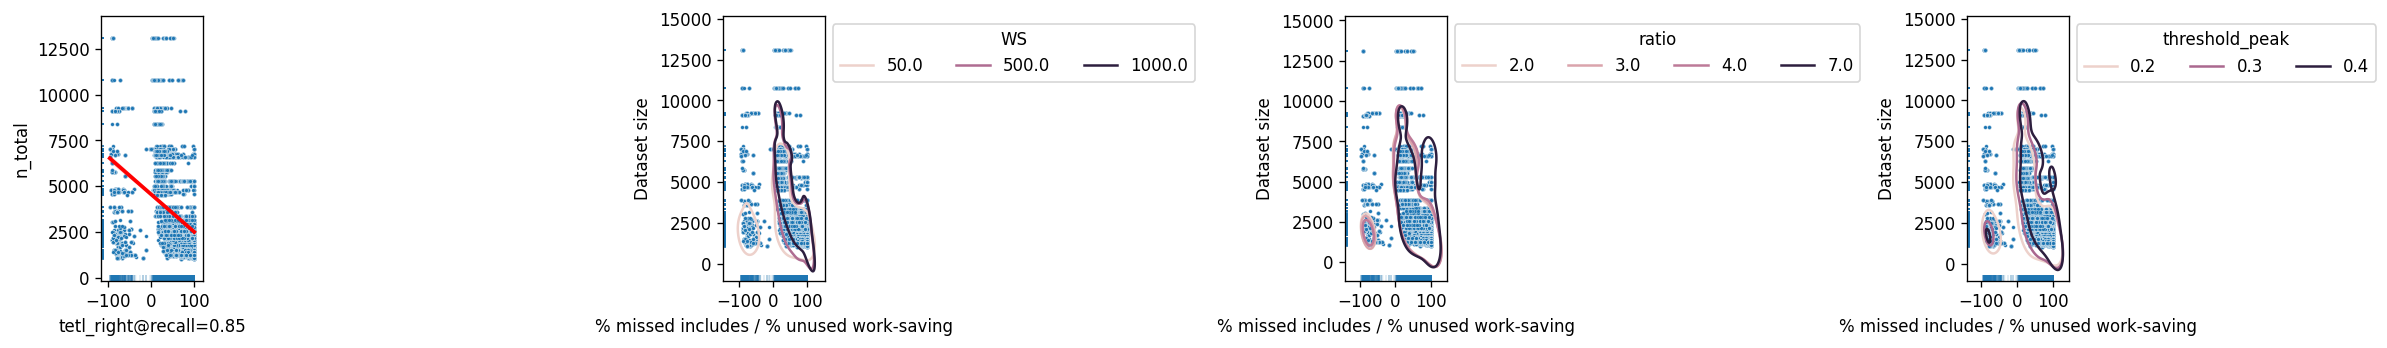

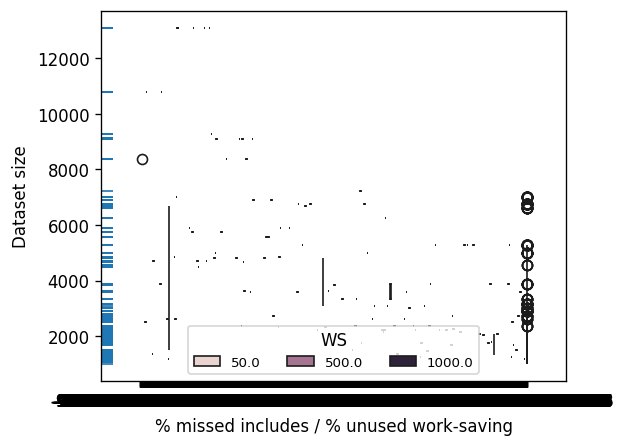

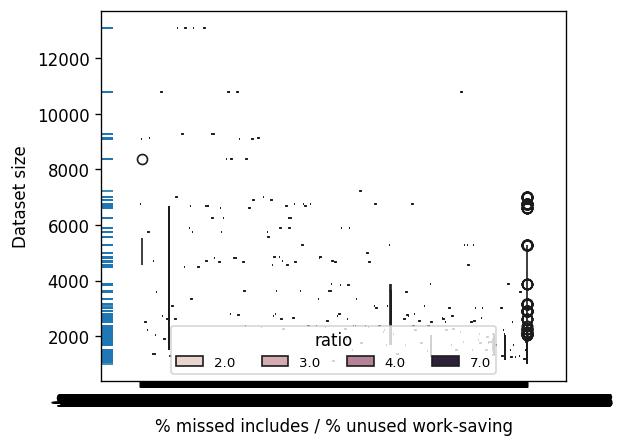

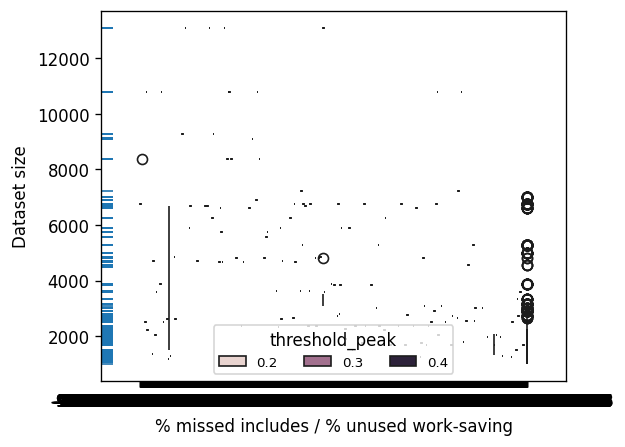

In [207]:
regress(
    dfr_fltr=df_res[(df_res['method']=='KNEE')],
    py = 'n_total',
    px = 'tetl_right@recall=0.85',
    pz = ['method-window_size', 'method-threshold_ratio','method-threshold_peak'],# 'method-polyorder', 'method-smoothing', 
    ly='Dataset size',
    lx='% missed includes / % unused work-saving',
    lz=['WS', 'ratio',  'threshold_peak'],#'polyorder', 'smoothing'
    fname='../data/plots/regress_knee',
    #ylim=(-105, 105),
)

## BATCHPRECISION

### Threshold

count         mean         std  \
tetl_right@recall=0.85 method-threshold                                   
-80.489671             0.05                1.0  7016.000000         NaN   
                       0.10                1.0  7016.000000         NaN   
                       0.20                1.0  7016.000000         NaN   
-79.542720             0.05                1.0  7016.000000         NaN   
                       0.10                1.0  7016.000000         NaN   
...                                        ...          ...         ...   
 96.807954             0.05                1.0  2602.000000         NaN   
 98.623064             0.05                1.0  2157.000000         NaN   
 100.000000            0.05              120.0  1483.291667  419.197501   
                       0.10               91.0  1426.714286  320.990560   
                       0.20               85.0  1416.329412  274.722734   

                                            min      25%     50%     75%  \
tetl_right@recall=0.85 method-threshold                                    
-80.489671             0.05              7016.0  7016.00  7016.0  7016.0   
                       0.10              7016.0  7016.00  7016.0  7016.0   
                       0.20              7016.0  7016.00  7016.0  7016.0   
-79.542720             0.05              7016.0  7016.00  7016.0  7016.0   
                       0.10              7016.0  7016.00  7016.0  7016.0   
...                                         ...      ...     ...     ...   
 96.807954             0.05              2602.0  2602.00  2602.0  2602.0   
 98.623064             0.05              2157.0  2157.00  2157.0  2157.0   
 100.000000            0.05              1000.0  1227.25  1333.0  1670.0   
                       0.10              1000.0  1155.00  1338.0  1665.0   
                       0.20              1000.0  1189.00  1338.0  1665.0   

                                            max  
tetl_right@recall=0.85 method-threshold          
-80.489671             0.05              7016.0  
                       0.10              7016.0  
                       0.20              7016.0  
-79.542720             0.05              7016.0  
                       0.10              7016.0  
...                                         ...  
 96.807954             0.05              2602.0  
 98.623064             0.05              2157.0  
 100.000000            0.05              2903.0  
                       0.10              2537.0  
                       0.20              1970.0  

[1508 rows x 8 columns]

count        mean          std     min     25%     50%  \
method-threshold                                                           
0.05              669.0  3601.64574  2591.193029  1000.0  1507.0  2602.0   
0.10              669.0  3601.64574  2591.193029  1000.0  1507.0  2602.0   
0.20              669.0  3601.64574  2591.193029  1000.0  1507.0  2602.0   

                     75%      max  
method-threshold                   
0.05              4862.0  13095.0  
0.10              4862.0  13095.0  
0.20              4862.0  13095.0

### Batch-size

count         mean         std  \
tetl_right@recall=0.85 method-batch_size                                   
-80.489671             500.0                3.0  7016.000000    0.000000   
-79.542720             500.0                3.0  7016.000000    0.000000   
-77.483444             500.0                2.0  6617.000000    0.000000   
-77.363515             500.0                3.0  7016.000000    0.000000   
-77.181208             500.0                2.0  6617.000000    0.000000   
...                                         ...          ...         ...   
 96.807954             2000.0               1.0  2602.000000         NaN   
 98.623064             2000.0               1.0  2157.000000         NaN   
 100.000000            500.0                8.0  1092.250000   56.937936   
                       1000.0              33.0  1232.090909  145.712123   
                       2000.0             255.0  1485.556863  361.469175   

                                             min      25%     50%     75%  \
tetl_right@recall=0.85 method-batch_size                                    
-80.489671             500.0              7016.0  7016.00  7016.0  7016.0   
-79.542720             500.0              7016.0  7016.00  7016.0  7016.0   
-77.483444             500.0              6617.0  6617.00  6617.0  6617.0   
-77.363515             500.0              7016.0  7016.00  7016.0  7016.0   
-77.181208             500.0              6617.0  6617.00  6617.0  6617.0   
...                                          ...      ...     ...     ...   
 96.807954             2000.0             2602.0  2602.00  2602.0  2602.0   
 98.623064             2000.0             2157.0  2157.00  2157.0  2157.0   
 100.000000            500.0              1000.0  1092.25  1123.0  1123.0   
                       1000.0             1000.0  1123.00  1254.0  1279.0   
                       2000.0             1000.0  1240.00  1390.0  1685.0   

                                             max  
tetl_right@recall=0.85 method-batch_size          
-80.489671             500.0              7016.0  
-79.542720             500.0              7016.0  
-77.483444             500.0              6617.0  
-77.363515             500.0              7016.0  
-77.181208             500.0              6617.0  
...                                          ...  
 96.807954             2000.0             2602.0  
 98.623064             2000.0             2157.0  
 100.000000            500.0              1123.0  
                       1000.0             1497.0  
                       2000.0             2903.0  

[948 rows x 8 columns]

count        mean          std     min     25%     50%  \
method-batch_size                                                           
500.0              669.0  3601.64574  2591.193029  1000.0  1507.0  2602.0   
1000.0             669.0  3601.64574  2591.193029  1000.0  1507.0  2602.0   
2000.0             669.0  3601.64574  2591.193029  1000.0  1507.0  2602.0   

                      75%      max  
method-batch_size                   
500.0              4862.0  13095.0  
1000.0             4862.0  13095.0  
2000.0             4862.0  13095.0

### Correlations

tetl_right@recall=0.85       n_total  \
tetl_right@recall=0.85                1.000000 -4.643630e-01   
n_total                              -0.464363  1.000000e+00   
method-threshold                     -0.161914  1.165575e-16   
method-batch_size                     0.672367  8.104275e-16   

                        method-threshold  method-batch_size  
tetl_right@recall=0.85     -1.619140e-01       6.723672e-01  
n_total                     1.165575e-16       8.104275e-16  
method-threshold            1.000000e+00      -1.843497e-18  
method-batch_size          -1.843497e-18       1.000000e+00

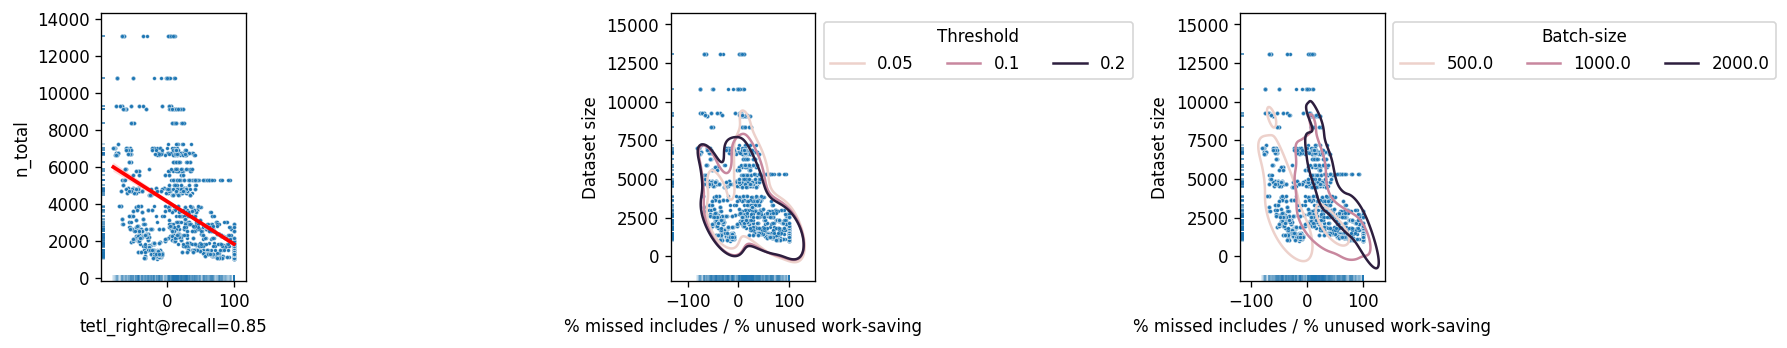

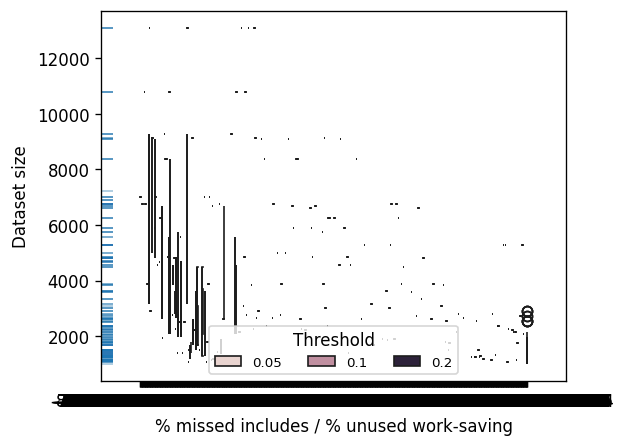

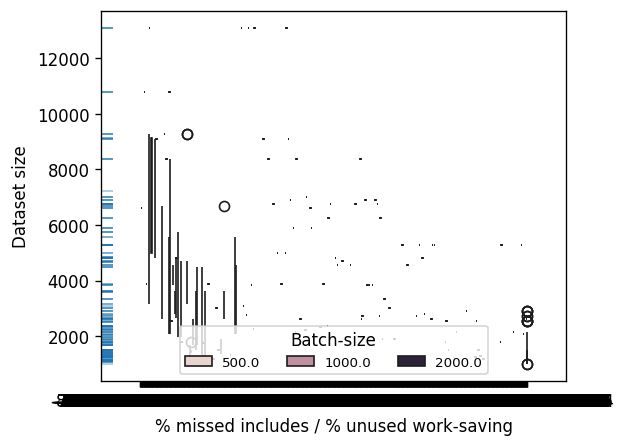

In [196]:
regress(
    dfr_fltr=df_res[(df_res['method']=='BATCHPRECISION')],
    py = 'n_total',
    px = 'tetl_right@recall=0.85',
    pz = ['method-threshold', 'method-batch_size'],
    ly='Dataset size',
    lx='% missed includes / % unused work-saving',
    lz=['Threshold', 'Batch-size'],
    fname='../data/plots/regress_bp',
    #ylim=(-105, 105),
)

## CMH

### Confidence target

count       mean        std  \
method-recall_target method-confidence_level                                
0.80                 0.80                      11.0  25.959861   6.090883   
                     0.90                      11.0  30.450071   8.161852   
                     0.95                      11.0  34.868153   9.796843   
                     0.99                      11.0  43.020863  10.962119   
0.90                 0.80                      11.0  33.865840  11.360650   
                     0.90                      11.0  41.281624  11.709774   
                     0.95                      11.0  47.661901  13.667510   
                     0.99                      11.0  58.521869  14.603097   
0.95                 0.80                      11.0  42.583905  12.477719   
                     0.90                      11.0  54.193435  13.068205   
                     0.95                      11.0  62.449526  12.679206   
                     0.99                      11.0  74.227076  14.636874   
0.99                 0.80                      11.0  73.867942   9.483597   
                     0.90                      11.0  83.877335   9.438765   
                     0.95                      11.0  90.315195   9.094087   
                     0.99                      11.0  96.042724   6.022100   

                                                    min        25%  \
method-recall_target method-confidence_level                         
0.80                 0.80                     18.952473  22.363208   
                     0.90                     19.534433  24.169610   
                     0.95                     22.174226  25.880277   
                     0.99                     26.517944  34.038798   
0.90                 0.80                     19.196704  23.920776   
                     0.90                     24.140062  31.533231   
                     0.95                     26.014418  36.191809   
                     0.99                     33.120494  49.557967   
0.95                 0.80                     21.406320  32.863624   
                     0.90                     30.774366  48.663440   
                     0.95                     39.118825  54.894453   
                     0.99                     46.150423  66.179148   
0.99                 0.80                     56.147384  67.245243   
                     0.90                     67.818463  76.717618   
                     0.95                     72.846828  83.596869   
                     0.99                     81.768953  92.719919   

                                                     50%         75%  \
method-recall_target method-confidence_level                           
0.80                 0.80                      24.114286   28.146569   
                     0.90                      29.769347   38.260566   
                     0.95                      37.157757   41.364565   
                     0.99                      47.066493   50.052265   
0.90                 0.80                      36.635007   44.047295   
                     0.90                      44.623656   50.555762   
                     0.95                      51.017639   57.691789   
                     0.99                      64.080100   67.561562   
0.95                 0.80                      45.664740   51.741338   
                     0.90                      56.502890   63.804144   
                     0.95                      65.739130   71.047975   
                     0.99                      80.346821   83.590224   
0.99                 0.80                      79.987314   81.084518   
                     0.90                      90.453536   90.896702   
                     0.95                      95.213319   96.167819   
                     0.99                     100.000000  100.000000   

                                                     max  
method-recall_target method-confidence_lev

count       mean        std        min        25%  \
method-confidence_level                                                      
0.80                      44.0  44.069387  20.832923  18.952473  25.997763   
0.90                      44.0  52.450616  22.737092  19.534433  32.743946   
0.95                      44.0  58.823694  23.624436  22.174226  40.167783   
0.99                      44.0  67.953133  23.010473  26.517944  49.497878   

                               50%        75%         max  
method-confidence_level                                    
0.80                     41.022228  56.678553   82.261209  
0.90                     50.555762  68.127116   91.756272  
0.95                     57.691789  74.189340  100.000000  
0.99                     67.561562  85.903677  100.000000

### Correlations

method-recall_target  tetl_right  \
method-recall_target             1.000000e+00    0.744166   
tetl_right                       7.441662e-01    1.000000   
method-confidence_level         -3.873022e-17    0.354768   

                         method-confidence_level  
method-recall_target               -3.873022e-17  
tetl_right                          3.547682e-01  
method-confidence_level             1.000000e+00

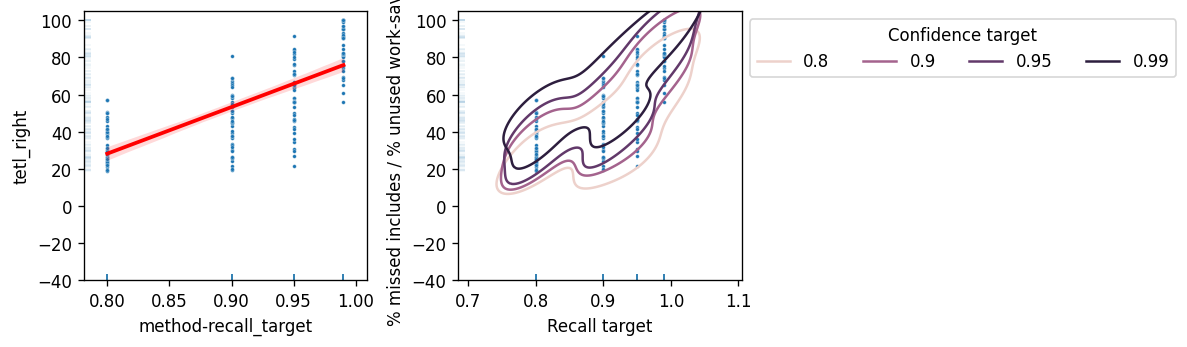

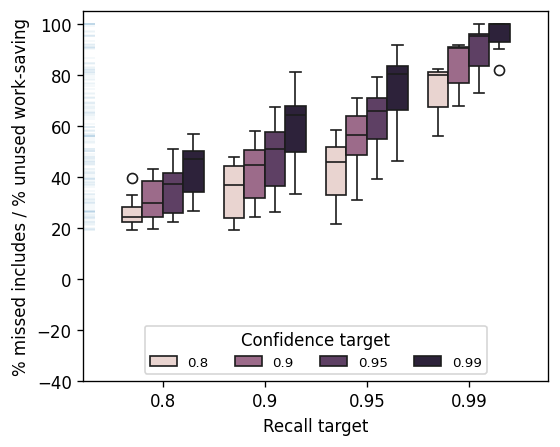

In [197]:
regress(
    dfr_fltr=df_res[(df_res['method']=='CMH')],
    px = 'method-recall_target',
    py = 'tetl_right',
    pz = ['method-confidence_level'],
    lx='Recall target',
    ly='% missed includes / % unused work-saving',
    lz=['Confidence target'],
    fname='../data/plots/regress_cmh',
    ylim=(-40, 105),
)

## QUANT_CI

### Standardisation

count        mean        std         min  \
method-recall_target method-nstd                                             
0.80                 0.0          223.0   24.882429  26.149468  -19.117647   
                     1.0          223.0   33.040009  27.944703  -16.911765   
                     2.0          223.0   48.219115  33.294437  -13.970588   
0.90                 0.0          223.0   32.502196  28.673577  -24.277457   
                     1.0          223.0   54.737893  32.695184   -4.934211   
                     2.0          223.0   78.439914  30.062029    5.737272   
0.95                 0.0          223.0   38.390180  31.075641  -21.200511   
                     1.0          223.0   81.051476  27.532927  -12.266355   
                     2.0          223.0   97.867897  11.111285   22.237325   
0.99                 0.0          223.0   49.541800  35.041631  -31.908127   
                     1.0          223.0  100.000000   0.000000  100.000000   
                     2.0          223.0  100.000000   0.000000  100.000000   

                                         25%         50%         75%  \
method-recall_target method-nstd                                       
0.80                 0.0            7.040318   16.399043   31.327735   
                     1.0           11.774920   23.639661   50.519391   
                     2.0           19.489403   42.202532   79.292929   
0.90                 0.0           11.704293   23.792739   48.867743   
                     1.0           22.692095   53.959965   87.464193   
                     2.0           58.555524  100.000000  100.000000   
0.95                 0.0           16.504850   33.073616   58.399454   
                     1.0           62.425245  100.000000  100.000000   
                     2.0          100.000000  100.000000  100.000000   
0.99                 0.0           24.562148   55.474453   76.583359   
                     1.0          100.000000  100.000000  100.000000   
                     2.0          100.000000  100.000000  100.000000   

                                         max  
method-recall_target method-nstd              
0.80                 0.0           95.059076  
                     1.0          100.000000  
                     2.0          100.000000  
0.90                 0.0           97.911227  
                     1.0          100.000000  
                     2.0          100.000000  
0.95                 0.0          100.000000  
                     1.0          100.000000  
                     2.0          100.000000  
0.99                 0.0          100.000000  
                     1.0          100.000000  
                     2.0          100.000000

count       mean        std        min        25%         50%  \
method-nstd                                                                  
0.0          892.0  36.329151  31.670107 -31.908127  10.882193   29.133492   
1.0          892.0  67.207345  36.027703 -16.911765  31.361364   84.656904   
2.0          892.0  81.131732  31.052575 -13.970588  64.981155  100.000000   

                    75%    max  
method-nstd                     
0.0           60.263422  100.0  
1.0          100.000000  100.0  
2.0          100.000000  100.0

### Correlations

method-recall_target  tetl_right   method-nstd
method-recall_target          1.000000e+00    0.473905 -1.185521e-17
tetl_right                    4.739048e-01    1.000000  4.823825e-01
method-nstd                  -1.185521e-17    0.482383  1.000000e+00

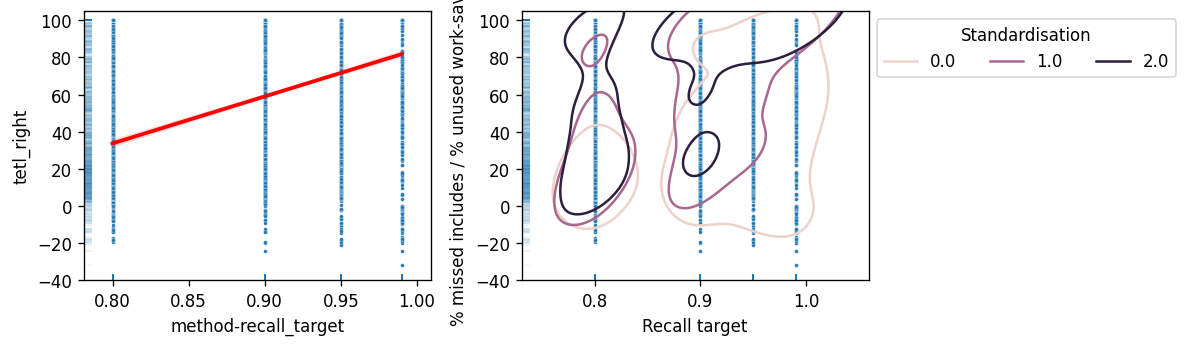

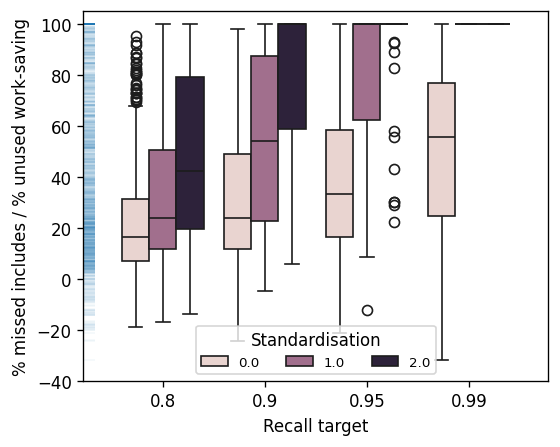

In [198]:
regress(
    dfr_fltr=df_res[(df_res['method']=='QUANT_CI')],
    px = 'method-recall_target',
    py = 'tetl_right',
    pz = ['method-nstd'],
    lx='Recall target',
    ly='% missed includes / % unused work-saving',
    lz=['Standardisation'],
    ylim=(-40, 105),
    fname='../data/plots/regress_quantci',
)

## HEURISTIC_SCORES

### Inclusion threshold

count       mean        std  \
method-recall_target method-inclusion_threshold                                
0.80                 0.25                        223.0 -51.019141  28.456363   
                     0.50                        223.0 -66.468555  20.910456   
                     0.75                        223.0 -64.728165  62.429564   
                     0.90                        223.0 -55.813497  75.532619   
0.90                 0.25                        223.0 -53.824992  27.154471   
                     0.50                        223.0 -68.771871  19.406004   
                     0.75                        223.0 -65.667544  62.573703   
                     0.90                        223.0 -56.411551  75.764807   
0.95                 0.25                        223.0 -58.123824  25.898849   
                     0.50                        223.0 -71.804440  17.889977   
                     0.75                        223.0 -66.850020  62.821581   
                     0.90                        223.0 -57.103560  76.045159   
0.99                 0.25                        223.0 -66.545787  23.960389   
                     0.50                        223.0 -77.714053  15.822112   
                     0.75                        223.0 -69.201064  63.343990   
                     0.90                        223.0 -58.533600  76.641303   

                                                       min        25%  \
method-recall_target method-inclusion_threshold                         
0.80                 0.25                       -95.348837 -73.457083   
                     0.50                       -97.674419 -82.505662   
                     0.75                       -99.130939 -96.578947   
                     0.90                       -99.296105 -97.411128   
0.90                 0.25                       -96.226415 -75.174610   
                     0.50                       -98.113208 -82.985479   
                     0.75                       -99.213012 -96.583224   
                     0.90                       -99.338041 -97.584516   
0.95                 0.25                       -96.296296 -77.363867   
                     0.50                       -98.148148 -85.344267   
                     0.75                       -99.338041 -97.213506   
                     0.90                       -99.404998 -97.853768   
0.99                 0.25                       -96.721311 -83.023398   
                     0.50                       -98.360656 -88.963641   
                     0.75                       -99.617347 -97.884558   
                     0.90                       -99.617347 -98.252752   

                                                       50%        75%  \
method-recall_target method-inclusion_threshold                         
0.80                 0.25                       -54.785779 -29.827472   
                     0.50                       -70.645793 -51.315254   
                     0.75                       -89.682540 -76.069182   
                     0.90                       -92.730210 -80.717553   
0.90                 0.25                       -57.731959 -37.949310   
                     0.50                       -72.340426 -57.208036   
                     0.75                       -90.384615 -78.396099   
                     0.90                       -93.392070 -81.749306   
0.95                 0.25                       -62.201365 -44.503956   
                     0.50                       -74.245473 -62.012987   
                     0.75                       -91.092637 -81.795712   
                     0.90                       -94.047619 -83.999959   
0.99                 0.25                       -71.982046 -58.425212   
                     0.50                       -80.322906 -72.593068   
                     0.75                       -92.907801 -85.917134   
                     0.90                       -95.

count       mean        std        min        25%  \
method-inclusion_threshold                                                      
0.25                        892.0 -57.378436  27.020353 -96.721311 -77.449638   
0.50                        892.0 -71.189730  19.044225 -98.360656 -85.656085   
0.75                        892.0 -66.611698  62.709728 -99.617347 -97.222222   
0.90                        892.0 -56.965552  75.875835 -99.617347 -97.686077   

                                  50%        75%         max  
method-inclusion_threshold                                    
0.25                       -62.843936 -41.754298   60.418280  
0.50                       -74.635639 -60.796555    5.875769  
0.75                       -91.195773 -79.993999  100.000000  
0.90                       -93.985886 -83.540754  100.000000

### Correlations

method-recall_target  tetl_right  \
method-recall_target                1.000000e+00   -0.055297   
tetl_right                         -5.529658e-02    1.000000   
method-inclusion_threshold         -3.773456e-17    0.002320   

                            method-inclusion_threshold  
method-recall_target                     -3.773456e-17  
tetl_right                                2.320258e-03  
method-inclusion_threshold                1.000000e+00

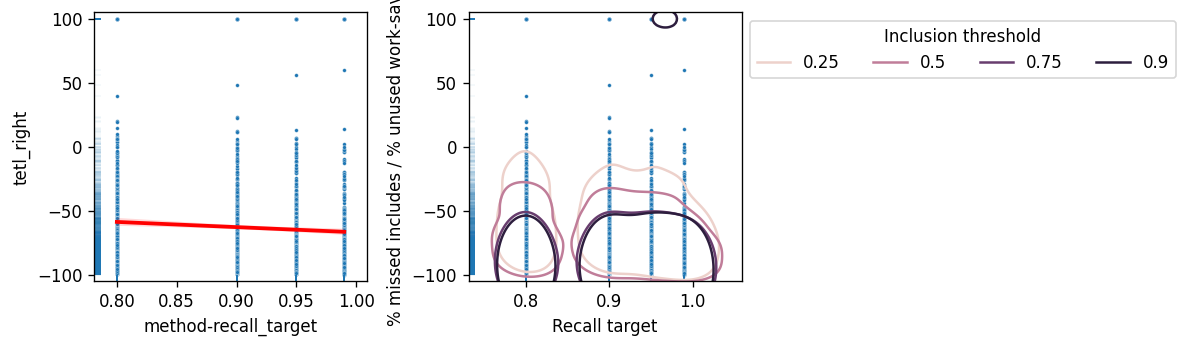

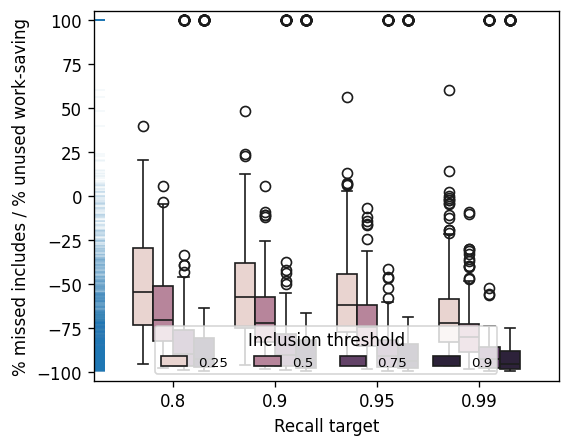

In [199]:
regress(
    dfr_fltr=df_res[(df_res['method']=='HEURISTIC_SCORES')],
    px = 'method-recall_target',
    py = 'tetl_right',
    pz = ['method-inclusion_threshold'],
    lx='Recall target',
    ly='% missed includes / % unused work-saving',
    lz=['Inclusion threshold'],
    ylim=(-105, 105),
    fname='../data/plots/regress_heuristiscores',
)

## TM_QBCB

### Positive sample size

count        mean  \
method-recall_target method-positive_sample_size                      
0.80                 5.0                          680.0  100.000000   
                     10.0                         680.0  100.000000   
                     25.0                         680.0   43.832153   
                     50.0                         680.0   30.732949   
                     100.0                        680.0   48.567379   
0.90                 5.0                          680.0  100.000000   
                     10.0                         680.0  100.000000   
                     25.0                         680.0  100.000000   
                     50.0                         680.0   59.855695   
                     100.0                        680.0   53.773013   
0.95                 5.0                          680.0  100.000000   
                     10.0                         680.0  100.000000   
                     25.0                         680.0  100.000000   
                     50.0                         680.0  100.000000   
                     100.0                        680.0   73.937701   
0.99                 5.0                          680.0  100.000000   
                     10.0                         680.0  100.000000   
                     25.0                         680.0  100.000000   
                     50.0                         680.0  100.000000   
                     100.0                        680.0  100.000000   

                                                        std         min  \
method-recall_target method-positive_sample_size                          
0.80                 5.0                           0.000000  100.000000   
                     10.0                          0.000000  100.000000   
                     25.0                         38.343801   -8.321775   
                     50.0                         37.624916  -11.749347   
                     100.0                        47.022404   -8.430610   
0.90                 5.0                           0.000000  100.000000   
                     10.0                          0.000000  100.000000   
                     25.0                          0.000000  100.000000   
                     50.0                         38.003352   -1.515152   
                     100.0                        43.033872   -5.202312   
0.95                 5.0                           0.000000  100.000000   
                     10.0                          0.000000  100.000000   
                     25.0                          0.000000  100.000000   
                     50.0                          0.000000  100.000000   
                     100.0                        34.525926    0.657519   
0.99                 5.0                           0.000000  100.000000   
                     10.0                          0.000000  100.000000   
                     25.0                          0.000000  100.000000   
                     50.0                          0.000000  100.000000   
                     100.0                         0.000000  100.000000   

                                                         25%         50%  \
method-recall_target method-positive_sample_size                           
0.80                 5.0                          100.000000  100.000000   
                     10.0                         100.000000  100.000000   
                     25.0                          12.926421   26.574240   
                     50.0                           5.315507   12.314768   
                     100.0                          3.714577   14.767657   
0.90                 5.0                          100.000000  100.000000   
                     10.0                         100.000000  100.000000   
                     25.0                         100.000000  100.000000   
                     50.0                          21.224913   59.155937   


count        mean        std         min  \
method-positive_sample_size                                              
5.0                          2720.0  100.000000   0.000000  100.000000   
10.0                         2720.0  100.000000   0.000000  100.000000   
25.0                         2720.0   85.958038  30.966173   -8.321775   
50.0                         2720.0   72.647161  39.606719  -11.749347   
100.0                        2720.0   69.069523  41.486678   -8.430610   

                                    25%    50%    75%    max  
method-positive_sample_size                                   
5.0                          100.000000  100.0  100.0  100.0  
10.0                         100.000000  100.0  100.0  100.0  
25.0                         100.000000  100.0  100.0  100.0  
50.0                          25.406979  100.0  100.0  100.0  
100.0                         17.950368  100.0  100.0  100.0

### Confidence target

count        mean        std  \
method-recall_target method-confidence_level                                 
0.80                 0.80                     850.0   58.716964  45.683220   
                     0.90                     850.0   59.730935  44.583267   
                     0.95                     850.0   62.590210  42.618586   
                     0.99                     850.0   77.467875  37.876393   
0.90                 0.80                     850.0   77.521325  37.998819   
                     0.90                     850.0   80.661627  34.237824   
                     0.95                     850.0   81.190444  33.303745   
                     0.99                     850.0   91.529571  24.634614   
0.95                 0.80                     850.0   91.702613  24.336075   
                     0.90                     850.0   93.723774  19.459426   
                     0.95                     850.0   93.723774  19.459426   
                     0.99                     850.0  100.000000   0.000000   
0.99                 0.80                     850.0  100.000000   0.000000   
                     0.90                     850.0  100.000000   0.000000   
                     0.95                     850.0  100.000000   0.000000   
                     0.99                     850.0  100.000000   0.000000   

                                                     min         25%    50%  \
method-recall_target method-confidence_level                                  
0.80                 0.80                     -11.749347    6.685565  100.0   
                     0.90                      -8.321775    9.885877  100.0   
                     0.95                      -0.652742   14.167091  100.0   
                     0.99                       1.412067   34.625769  100.0   
0.90                 0.80                      -5.202312   39.839958  100.0   
                     0.90                       0.605083   72.583756  100.0   
                     0.95                       1.611199   72.583756  100.0   
                     0.99                       2.508361  100.000000  100.0   
0.95                 0.80                       0.657519  100.000000  100.0   
                     0.90                       2.801601  100.000000  100.0   
                     0.95                       2.801601  100.000000  100.0   
                     0.99                     100.000000  100.000000  100.0   
0.99                 0.80                     100.000000  100.000000  100.0   
                     0.90                     100.000000  100.000000  100.0   
                     0.95                     100.000000  100.000000  100.0   
                     0.99                     100.000000  100.000000  100.0   

                                                75%    max  
method-recall_target method-confidence_level                
0.80                 0.80                     100.0  100.0  
                     0.90                     100.0  100.0  
                     0.95                     100.0  100.0  
                     0.99                     100.0  100.0  
0.90                 0.80                     100.0  100.0  
                     0.90                     100.0  100.0  
                     0.95                     100.0  100.0  
                     0.99                     100.0  100.0  
0.95                 0.80                     100.0  100.0  
                     0.90                     100.0  100.0  
                     0.95                     100.0  100.0  
                     0.99                     100.0  100.0  
0.99                 0.80                     100.0  100.0  
                     0.90                     100.0  100.0  
                     0.95                     100.0  100.0  
                     0.99                     100.0  100.0

count       mean        std        min    25%  \
method-confidence_level                                                   
0.80                     3400.0  81.985225  35.707348 -11.749347  100.0   
0.90                     3400.0  83.529084  33.487008  -8.321775  100.0   
0.95                     3400.0  84.376107  32.084790  -0.652742  100.0   
0.99                     3400.0  92.249361  24.387182   1.412067  100.0   

                           50%    75%    max  
method-confidence_level                       
0.80                     100.0  100.0  100.0  
0.90                     100.0  100.0  100.0  
0.95                     100.0  100.0  100.0  
0.99                     100.0  100.0  100.0

### Correlations

method-recall_target  tetl_right  \
method-recall_target                 1.000000e+00    0.424548   
tetl_right                           4.245476e-01    1.000000   
method-positive_sample_size         -9.586286e-18   -0.371968   
method-confidence_level              3.891320e-19    0.099254   

                             method-positive_sample_size  \
method-recall_target                       -9.586286e-18   
tetl_right                                 -3.719682e-01   
method-positive_sample_size                 1.000000e+00   
method-confidence_level                    -2.098695e-17   

                             method-confidence_level  
method-recall_target                    3.891320e-19  
tetl_right                              9.925390e-02  
method-positive_sample_size            -2.098695e-17  
method-confidence_level                 1.000000e+00

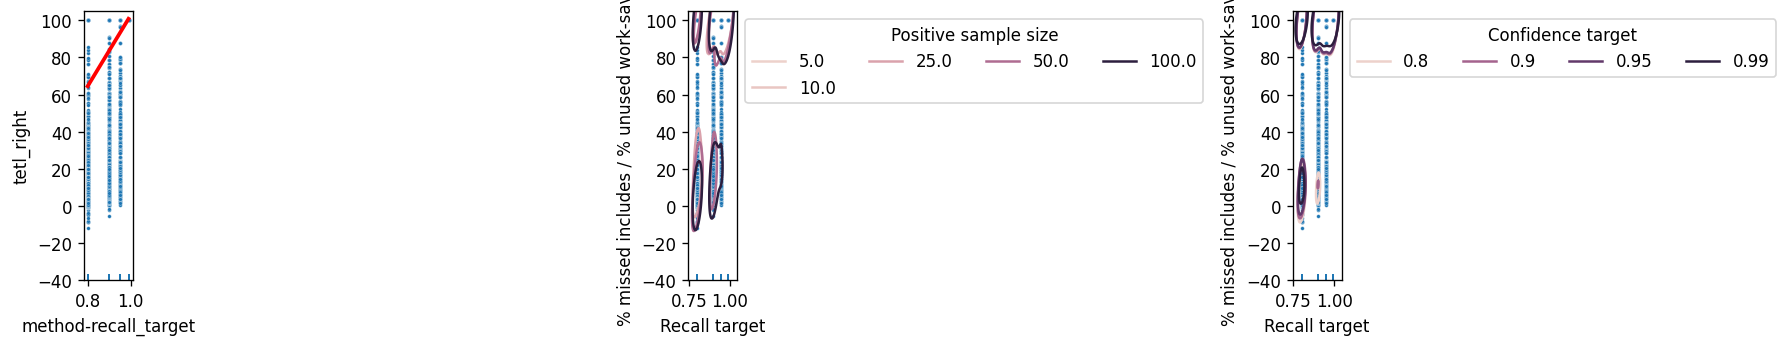

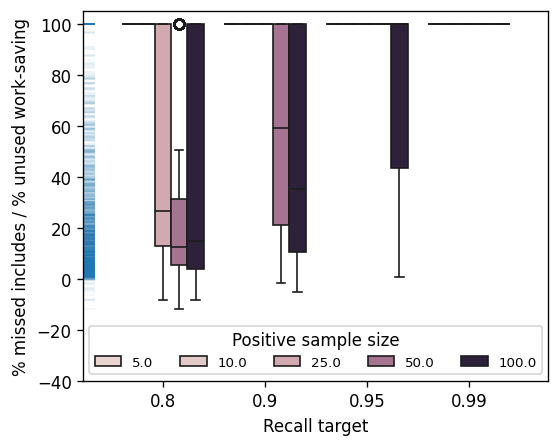

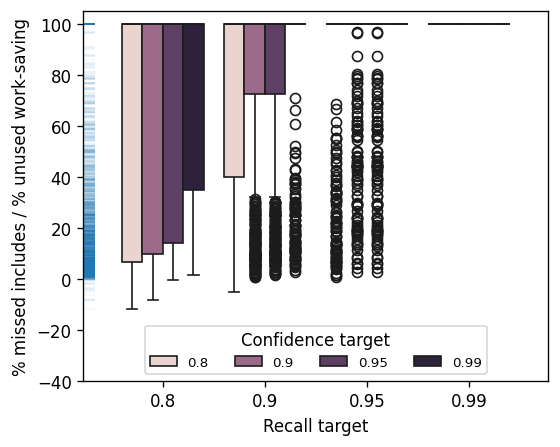

In [200]:
regress(
    dfr_fltr=df_res[(df_res['method']=='TM_QBCB')],
    px = 'method-recall_target',
    py = 'tetl_right',
    pz = ['method-positive_sample_size', 'method-confidence_level'],
    lx='Recall target',
    ly='% missed includes / % unused work-saving',
    lz=['Positive sample size', 'Confidence target'],
    ylim=(-40, 105),
    fname='../data/plots/regress_tmqbcb',
)

## Crosstab

  0%|          | 0/121 [00:00<?, ?it/s]

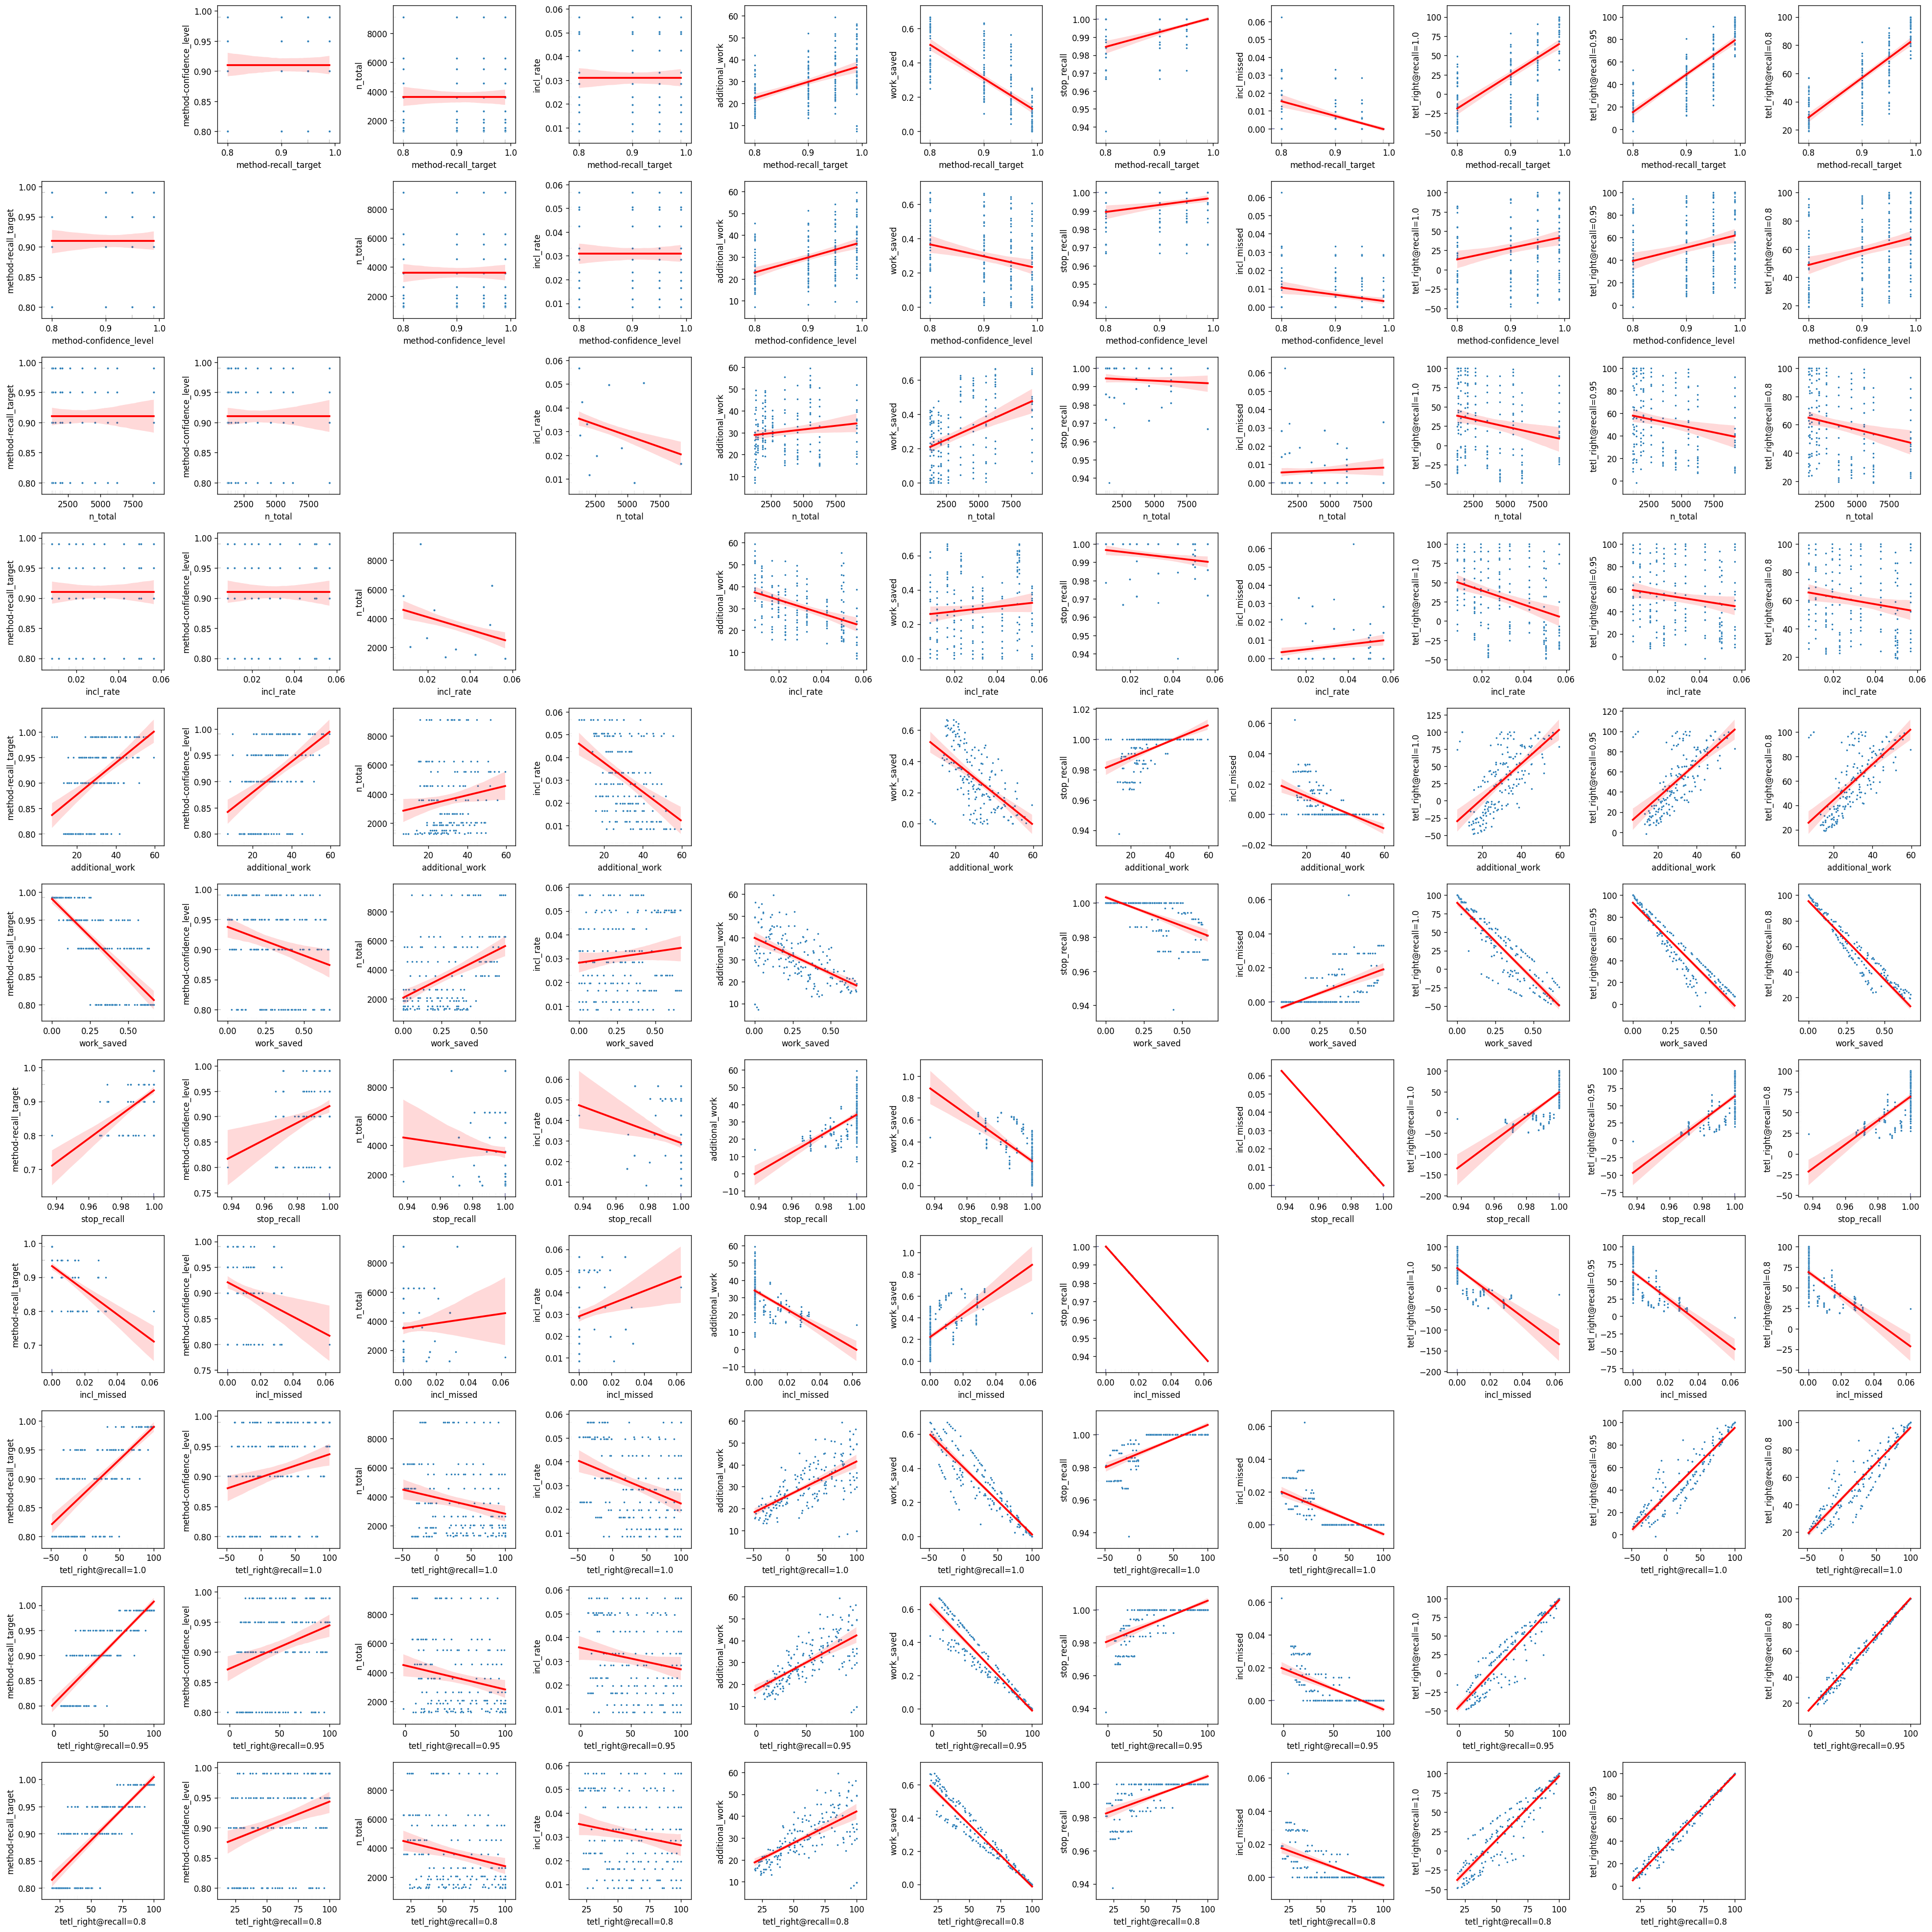

Exception in thread Thread-5:
Traceback (most recent call last):
  File "/usr/lib/python3.13/threading.py", line 1043, in _bootstrap_inner
    self.run()
    ~~~~~~~~^^
  File "/home/rept/workspace/stopping-methods/venv/lib/python3.13/site-packages/tqdm/_monitor.py", line 84, in run
    instance.refresh(nolock=True)
    ~~~~~~~~~~~~~~~~^^^^^^^^^^^^^
  File "/home/rept/workspace/stopping-methods/venv/lib/python3.13/site-packages/tqdm/std.py", line 1347, in refresh
    self.display()
    ~~~~~~~~~~~~^^
  File "/home/rept/workspace/stopping-methods/venv/lib/python3.13/site-packages/tqdm/notebook.py", line 171, in display
    rtext.value = right
    ^^^^^^^^^^^
  File "/home/rept/workspace/stopping-methods/venv/lib/python3.13/site-packages/traitlets/traitlets.py", line 716, in __set__
    self.set(obj, value)
    ~~~~~~~~^^^^^^^^^^^^
  File "/home/rept/workspace/stopping-methods/venv/lib/python3.13/site-packages/traitlets/traitlets.py", line 706, in set
    obj._notify_trait(self.name, old

In [34]:
fig, axes = plt.subplots(len(params), len(params), figsize=(3 * len(params), 3 * len(params)), dpi=120)

dfr_fltr = df_res[(df_res['method']=='CMH') & (df_res['incl_rate']<0.2)]
#dfr_fltr = df_res[(df_res['method']=='TM_QBCB') & (df_res['incl_rate']<0.2)]
#dfr_fltr = df_res[(df_res['method']=='QUANT_CI') & (df_res['incl_rate']<0.2)]

bar = tqdm(total=len(params)*len(params))
for i, pi in enumerate(params):
    for j, pj in enumerate(params):
        bar.update()
        bar.set_description(f'{pi} -> {pj}')
        if pi == pj:
            fig.delaxes(axes[i][j])
        else:
            sns.scatterplot(data=dfr_fltr, x=pi, y=pj,  s=5, ax=axes[i][j])
            sns.rugplot(data=dfr_fltr, x=pi, y=pj, lw=1, alpha=.005, ax=axes[i][j])
            sns.regplot(data=dfr_fltr, x=pi, y=pj, scatter=False, line_kws={'color': 'r'}, ax=axes[i][j], ci=95, order=1)
            #axes[i][j].scatter(dfr_fltr[pi], dfr_fltr[pj], s=2)
            #axes[i][j].set_xlabel(pi)
            #axes[i][j].set_ylabel(pj)

fig.tight_layout()

# Previous figure versions

In [ ]:
hists_y = {}
hists_x = {}

rt = 0.95  # recall target
bins = 20
late_ref = ['left', 'right'][1]

n_methods = len(df_res['method'].unique())
n_cols = 3
n_rows = (n_methods // n_cols)+1
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5*n_rows), dpi=120)

markers = ['x', '.', '+', 'o', 'v', '2', 'D', 's']
colours = ['red', 'green', 'blue', 'orange', 'pink']

#xval, xlab, xlim = ('work_saved', 'Work saved', (-0.1, 1.1))
#yval, ylab, ylim = ('stop_recall', 'Recall when stopped', (-0.1, 1.1))

#xval, xlab, xlim = ('x', '% missed includes / % additional work', (-105, 500))
#yval, ylab, ylim = ('stop_recall', 'Recall when stopped', (-0.1, 1.1))

#df_res['te'] = df_res[f'too_early%@recall={rt}'].fillna(0) * -100
#xval, xlab, xlim = ('x', '% missed includes / % additional work', (-105, 500))
#yval, ylab, ylim = ('te', '% stopped before target', (-5, 105))

xval, xlab, xlab2, xlim = (lambda x: f'tetl_right@recall={x}', f'% missed includes / % unused work-saving (RT={rt:.0%})', '% missed includes / % unused work-saving',  (-105, 105)) # 400
yval, ylab, ylab2, ylim = (lambda x: 'n_total', 'Number of records', 'Number of records', (0, 13000))

#xval, xlab, xlab2, xlim = (lambda x: f'tetl_right@recall={x}', f'% before/after {rt:.0%} recall target', '% before/after recall target',  (-105, 105))
#yval, ylab, ylab2, ylim = (lambda x: f'missed_%@recall={x}', f'% missed includes (RT={rt:.0%})', '% missed includes',  (-5, 105))

#xval, xlab, xlim = (f'missed%@recall={rt}', 'Missed', (-1.1, 0.1))
#yval, ylab, ylim = (f'too_late_{late_ref}%@recall={rt}', 'Overshoot', (-0.1, 5))

vred = False
hred = True

for mi, meth in enumerate(sorted(df_res['method'].unique())):
    ax = axes[int(mi/n_cols)][mi%n_cols]
    mask = df_res['method'] == meth
    df_meth = df_res[mask]

   # ax.set_aspect('equal')
    ax_histx = ax.inset_axes([0, 1.05, 1, 0.25])
    ax_histy = ax.inset_axes([1.05, 0, 0.25, 1])

    recall_targets = sorted(df_meth['method-recall_target'].unique())
    if len(recall_targets) > 1:
        group_col = 'method-recall_target'
        group_lab = lambda v_: f'{v_:.0%} recall target'
    elif meth == 'BATCHPRECISION':
        group_col = 'method-threshold'
        group_lab = lambda v_: f'Threshold {v_:.0%}'
    elif meth == 'HEURISTIC_FIX':
        group_col = 'method-num_to_stop'
        group_lab = lambda v_: f'{v_:,.0f} consecutive excl.'
    elif meth == 'HEURISTIC_FRAC':
        group_col = 'method-fraction'
        group_lab = lambda v_: f'{v_:.0%} consecutive excl.'
    elif meth == 'KNEE':
        group_col = 'method-threshold_peak'
        group_lab = lambda v_: f'Knee threshold {v_:.0%}'
    elif meth == 'METHOD2399':
        group_col = 'method-alpha'
        group_lab = lambda v_: f'alpha={v_:.1f}'
    else:
        group_col = None

    if vred:
        ax.fill_between(np.arange(len(df_meth)) - 100, 5, ylim[1], where=(np.arange(len(df_meth))-100) < 0, facecolor='red', alpha=0.1)
        ax.fill_between(np.arange(len(df_meth)) - 100, 10, ylim[1], where=(np.arange(len(df_meth))-100) < 0, facecolor='red', alpha=0.1)
        ax.fill_between(np.arange(len(df_meth)) - 100, 15, ylim[1], where=(np.arange(len(df_meth))-100) < 0, facecolor='red', alpha=0.1)
        ax.fill_between(np.arange(len(df_meth)) - 100, 20, ylim[1], where=(np.arange(len(df_meth))-100) < 0, facecolor='red', alpha=0.1)
        ax.fill_between(np.arange(len(df_meth)) - 100, ylim[0], ylim[1], where=(np.arange(len(df_meth))-100) < 0, facecolor='red', alpha=0.1)
    if hred:
        ax.fill_between(np.arange(len(df_meth)) - 100, ylim[0], ylim[1], where=(np.arange(len(df_meth))-100) < 0, facecolor='red', alpha=0.1)
        ax.fill_between(np.arange(len(df_meth)) - 100, ylim[0], ylim[1], where=(np.arange(len(df_meth))-100) < -5, facecolor='red', alpha=0.1)
        ax.fill_between(np.arange(len(df_meth)) - 100, ylim[0], ylim[1], where=(np.arange(len(df_meth))-100) < -10, facecolor='red', alpha=0.1)
        ax.fill_between(np.arange(len(df_meth)) - 100, ylim[0], ylim[1], where=(np.arange(len(df_meth))-100) < -15, facecolor='red', alpha=0.1)
        ax.fill_between(np.arange(len(df_meth)) - 100, ylim[0], ylim[1], where=(np.arange(len(df_meth))-100) < -20, facecolor='red', alpha=0.1)

    if len(recall_targets) <= 1:
        histx, edgex = np.histogram(df_meth[xval(rt)], bins=bins, range=xlim)
        histy, edgey = np.histogram(df_meth[yval(rt)], bins=bins, range=ylim)
        hists_x[meth] = histx
        hists_y[meth] = histy
      
        ax_histx.bar(edgex[:-1], height=histx / histx.sum() * 100, width=(edgex[-1] - edgex[0]) / bins, alpha=0.2)
        ax_histy.barh(y=edgey[:-1], width=histy / histy.sum() * 100, height=(edgey[-1] - edgey[0]) / bins, alpha=0.2)
    
    if group_col is None:
        df_meth.plot.scatter(x=xval, y=yval, ax=ax, s=1)
    else:
        values = sorted(df_meth[group_col].unique())
        for vi, v in enumerate(values):
            xy = df_meth[df_meth[group_col] == v].rename(columns={xval(v if len(recall_targets) > 1 else rt): 'x', yval(v if len(recall_targets) > 1 else rt): 'y'})[['x', 'y']]
            ax.scatter(xy['x'], xy['y'], s=3, c=colours[vi], marker=markers[vi], label=group_lab(v))

            histx, edgex = np.histogram(df_meth[df_meth[group_col] == v][xval(v if len(recall_targets) > 1 else rt)], bins=bins, range=xlim)
            histy, edgey = np.histogram(df_meth[df_meth[group_col] == v][yval(v if len(recall_targets) > 1 else rt)], bins=bins, range=ylim)
            ax_histx.plot(edgex[:-1], histx / histx.sum() * 100, alpha=0.5, c=colours[vi], marker=markers[vi], ms=3, lw=1)
            ax_histy.plot(histy / histy.sum() * 100, edgey[:-1], alpha=0.5, c=colours[vi], marker=markers[vi], ms=3, lw=1)
        
           # xhist = np.linspace(xlim[0], xlim[1], bins)
           # xv = df_meth[df_meth[group_col] == v][xval]
           # gx = gaussian_kde(xv)(xhist) if np.var(xv) > 0 else np.ones_like(xhist) * xv.mean()
           # ax_histx.plot(xhist, gx / (gx + 1e-6).sum(), alpha=0.5, c=colours[vi], marker=markers[vi])
           # yhist = np.linspace(ylim[0], ylim[1], bins)
           # yv = df_meth[df_meth[group_col] == v][yval]
           # gy = gaussian_kde(yv)(yhist) if np.var(yv) > 0 else np.ones_like(yhist) * yv.mean()
           # ax_histy.plot(gy / (gy + 1e-6).sum(), yhist, alpha=0.5, c=colours[vi], marker=markers[vi])
        ax.legend()
    #ax_histy.set_xscale('log')
    ax_histx.tick_params(axis="x", labelbottom=False)
    ax_histy.tick_params(axis="y", labelleft=False)
    ax.axes.xaxis.set_visible(True)
    ax.axes.yaxis.set_visible(True)
    
    ax.set_title(meth)
    ax.set_xlabel(xlab if len(recall_targets) <= 1 else xlab2)
    ax.set_ylabel(ylab if len(recall_targets) <= 1 else ylab2)
    ax.grid(lw=0.2, ls='--')
    ax_histx.grid(lw=0.2, ls='--')
    ax_histy.grid(lw=0.2, ls='--')

    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    ax_histx.set_xlim(xlim)
    ax_histx.set_ylim(-5, 50)
    ax_histy.set_xlim(-5, 100)
    ax_histy.set_ylim(ylim)

fig.delaxes(axes[3][2])
fig.delaxes(axes[3][1])
    
fig.tight_layout()
#fig.show()
#fig.savefig('../data/plots/scatter.pdf')

In [ ]:
fig.savefig('../data/plots/scatter.pdf')

In [ ]:
pd.DataFrame(hists_y | {'Recall': edgey[:-1]}).style.background_gradient(cmap='Blues', axis=0)

In [ ]:
pd.DataFrame(hists_x | {'Work saved': edgex[:-1]}).style.background_gradient(cmap='Blues', axis=0)

In [ ]:
df_res[(df_res['method'] == 'CMH') & (df_res['stop_recall'] < 0.9)]

In [ ]:
hists_y = {}
hists_x = {}

n_methods = len(df_res['method'].unique())
n_cols = 3
n_rows = (n_methods // n_cols)+1
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5*n_rows), dpi=120)

markers = ['x', '.', '+', 'o', 'v', '2', 'D', 's']
colours = ['red', 'green', 'blue', 'orange', 'pink']

xval = 'work_saved'
xlab = 'Work saved'
for mi, meth in enumerate(sorted(df_res['method'].unique())):
    ax = axes[int(mi/n_cols)][mi%n_cols]
    mask = df_res['method'] == meth
    df_meth = df_res[mask]
    
    ax.set_aspect('equal')
    ax_histx = ax.inset_axes([0, 1.05, 1, 0.25])
    ax_histy = ax.inset_axes([1.05, 0, 0.25, 1])


    ax.set_title(meth)
    ax.set_ylabel('Recall when stopped')
    ax.set_xlabel(xlab)
    ax.grid(lw=0.2, ls='--')
    
    bins = 20
    binwidth = 1 / bins
    bins = np.arange(0, 1 + binwidth, binwidth)
    
    recall_targets = sorted(df_meth['method-recall_target'].unique())
    if len(recall_targets) > 1:
        for rti, rt in enumerate(recall_targets):
            df_meth[df_meth['method-recall_target'] == rt].plot.scatter(x=xval, y='stop_recall', ax=ax, s=3, c=colours[rti], marker=markers[rti], label=f'{rt:.0%} recall target')
        ax.legend()
    elif meth == 'BATCHPRECISION':
        thresholds = sorted(df_meth['method-threshold'].unique())
        for thi, th in enumerate(thresholds):
            df_meth[df_meth['method-threshold'] == th].plot.scatter(x=xval, y='stop_recall', ax=ax, s=3, c=colours[thi], marker=markers[thi], label=f'Threshold {th:.0%}')
        ax.legend()
    elif meth == 'HEURISTIC_FIX':
        values = sorted(df_meth['method-num_to_stop'].unique())
        for vi, v in enumerate(values):
            df_meth[df_meth['method-num_to_stop'] == v].plot.scatter(x=xval, y='stop_recall', ax=ax, s=3, c=colours[vi], marker=markers[vi], label=f'{v:,.0f} consecutive excl.')
    elif meth == 'HEURISTIC_FRAC':
        values = sorted(df_meth['method-fraction'].unique())
        for vi, v in enumerate(values):
            df_meth[df_meth['method-fraction'] == v].plot.scatter(x=xval, y='stop_recall', ax=ax, s=3, c=colours[vi], marker=markers[vi], label=f'{v:.0%} consecutive excl.')
        ax.legend()
    elif meth == 'KNEE':
        values = sorted(df_meth['method-threshold_peak'].unique())
        for vi, v in enumerate(values):
            df_meth[df_meth['method-threshold_peak'] == v].plot.scatter(x=xval, y='stop_recall', ax=ax, s=3, c=colours[vi], marker=markers[vi], label=f'Knee threshold {v:.0%}')
        ax.legend()
    elif meth == 'METHOD2399':
        values = sorted(df_meth['method-alpha'].unique())
        for vi, v in enumerate(values):
            df_meth[df_meth['method-alpha'] == v].plot.scatter(x=xval, y='stop_recall', ax=ax, s=3, c=colours[vi], marker=markers[vi], label=f'alpha={v:.1f}')
        ax.legend()
    else:
        df_meth.plot.scatter(x=xval, y='stop_recall', ax=ax, s=1)

    histx, _ = np.histogram(df_meth[xval], bins=bins)
    histy, _ = np.histogram(df_meth['stop_recall'], bins=bins)
    ax_histx.bar(bins[:-1], height=histx / histx.sum(), width=binwidth)
    ax_histy.barh(y=bins[:-1], width=histy / histy.sum(), height=binwidth)
    
    hists_x[meth] = histx
    hists_y[meth] = histy

    ax_histx.tick_params(axis="x", labelbottom=False)
    ax_histy.tick_params(axis="y", labelleft=False)
    ax.axes.xaxis.set_visible(True)
    ax.axes.yaxis.set_visible(True)

    
    ax.set_ylim(-0.1, 1.1)
    ax.set_xlim(-0.1, 1.1)
    ax_histx.set_xlim(-0.1, 1.1)
    ax_histx.set_ylim(-0.1, 1.1)
    ax_histy.set_xlim(-0.1, 1.1)
    ax_histy.set_ylim(-0.1, 1.1)

fig.delaxes(axes[3][2])
fig.delaxes(axes[3][1])
    
fig.tight_layout()
#fig.show()

In [ ]:
plots = df_res.groupby('method').plot.scatter(x='te', y='n_total')
fig, axes = plt.subplots(4, 3)
for i, (m, p) in enumerate(plots.items()):
    axes[i//3][i%3].axes(p)
    p.set_title(m)


In [ ]:
df.head()

In [ ]:
df.groupby('dataset').first()['n_total'].hist()

In [ ]:
df_meth